<h1 align=center><font size = 8> Clustering Neighborhoods in San Francisco by Incidents/Crimes</font></h1>

<h2 align=center><font size = 5> Second Notebook</font></h2>

<font size = 5> **Author**: Angelo Di Marco

## Introduction

In this Notebook, we perform a cluster segmentation of the neighborhoods in San Francisco in terms of the incidents/crimes categories which are most common in each neighborhood. We use the dataset available at the [link](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783) to have access to the incidents/crimes reported by the Police Department of San Francisco from 2018 till present time and we apply the __*k*-means__ clustering technique to this data in order to group the neighborhoods into clusters.

**_Note_**: this is the *Second Notebook* submitted for the "Capstone Project" of the *Applied Data Science Capstone* course, part of the **IBM Data Science Professional Certificate** issued by [Coursera.org](http://www.coursera.org).

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Importing and Exploring Neighborhoods and Crimes Datasets</a>

2. <a href="#item2">Exploring Incidents in San Francisco</a>

3. <a href="#item3">Analyzing Each Neighborhood</a>

4. <a href="#item4">Neighborhoods Clustering</a>

5. <a href="#item5">Clustering Neighborhoods Without "Larceny Theft"</a> 

6. <a href="#item6">Conclusions</a> 
</font>
</div>

## Libraries

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't installed the package yet
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns


from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium

print('Libraries imported.')

Libraries imported.


--------------------------

<a id='item1'></a>

## 1. Importing and Exploring Neighborhoods and Crimes Datasets

## 1.1 San Francisco Neighborhoods

The city of San Francisco is usually divided in neighborhoods. Several divisions exist and they are used for different purposes. In this project, we will consider two of them. The first one is the so-called "Planning Neighborhood Groups Map", available at this [link](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Planning-Neighborhood-Groups-Map/iacs-ws63). It offers a "fair" division of the area of the city which is more suitable for its use as for the Foursquare venues search, for instance. The second one, on the other hand, is called "Analysis Neighborhoods" (see the [link](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h)) and it is used, e.g., by the Police Department to locate the incidents/crimes occurring in San Francisco. In this Jupyter Notebook, we will use these two types of neighborhoods to understand how the most common incidents/crimes are distributed in San Francisco.

### "Planning Neighborhood Groups Map"

We start by considering the "Planning Neighborhood Groups Map" division. We import the corresponding list of neighborhoods of San Francisco with the coordinates of their "centers" from the CSV file *SF_neighborhoods_latlon_ADM.csv* created by the author of this Notebook. We use *pandas* to convert it into a dataframe:

In [2]:
neighborhoods_SF_coord = pd.read_csv('SF_neighborhoods_latlon_ADM.csv', sep=';')
neighborhoods_SF_coord.head()

SF_neighborhoods   latitude   longitude
0          Seacliff  37.784973 -122.501423
1    Outer Richmond  37.777818 -122.492410
2  Golden Gate Park  37.769383 -122.481940
3      Outer Sunset  37.755419 -122.493805
4          Parkside  37.742096 -122.489641

In [3]:
neighborhoods_SF_coord.shape

(37, 3)

In [4]:
print('The dataframe has {} neighborhoods.'.format(
        len(neighborhoods_SF_coord['SF_neighborhoods'].unique())
    )
)

The dataframe has 37 neighborhoods.


We rename the columns of this dataframe

In [5]:
neighborhoods_SF_coord.rename(columns={'SF_neighborhoods':'Neighborhood','latitude':'Latitude','longitude':'Longitude'}, inplace=True)
neighborhoods_SF_coord.head()

Neighborhood   Latitude   Longitude
0          Seacliff  37.784973 -122.501423
1    Outer Richmond  37.777818 -122.492410
2  Golden Gate Park  37.769383 -122.481940
3      Outer Sunset  37.755419 -122.493805
4          Parkside  37.742096 -122.489641

In [6]:
neighborhoods_SF_coord['Neighborhood'].unique()

array(['Seacliff', 'Outer Richmond', 'Golden Gate Park', 'Outer Sunset',
       'Parkside', 'Lakeshore', 'Presidio', 'Inner Richmond',
       'Inner Sunset', 'West of Twin Peaks', 'Oceanview',
       'Presidio Heights', 'Haight-Ashbury', 'Twin-Peaks',
       'Outer Mission', 'Crocker Amazon', 'Marina', 'Pacific Heights',
       'Western Addition', 'Castro-Upper Market', 'Noe Valley',
       'Diamond Heights', 'Glen Park', 'Russian Hill', 'Nob Hill',
       'Downtown-Tenderloin', 'Mission', 'Bernal Heights', 'Excelsior',
       'Visitacion Valley', 'North Beach', 'Chinatown',
       'Financial District', 'South of Market', 'Potrero Hill', 'Bayview',
       'Treasure Island'], dtype=object)

At this point we want to create a __Choropleth map of San Francisco__ showing the "Planning Neighborhood Groups Map". We get the latitude and longitude of San Francisco using the Geopy library

In [7]:
address = 'San Francisco, California'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of San Francisco are 37.7790262, -122.4199061.


We now load the GeoJson file containing the "borders" of the "Planning Neighborhood Groups Map" neighborhoods that can be downloaded from the [link](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Planning-Neighborhood-Groups-Map/iacs-ws63). After few adjustments to the names of the neighborhoods made in order to match the ones in the dataframe *neighborhoods_SF_coord*, we have the new file *SF_planning_neighborhood_groups_map_ADM.geojson* and we import it as follows:

In [8]:
import os

san_francisco_geo_PN = os.path.join('...insert path...', 'SF_planning_neighborhood_groups_map_ADM.geojson')

We create a new dataframe with alphabetically ordered neighborhoods and with a reset index column to be used in the Choropleth map as follows:

In [9]:
neighborhoods_SF_coord_index = neighborhoods_SF_coord.sort_values(by='Neighborhood',ascending=True)
neighborhoods_SF_coord_index = neighborhoods_SF_coord_index.reset_index()
neighborhoods_SF_coord_index.drop(['index'],axis=1,inplace=True)
neighborhoods_SF_coord_index = neighborhoods_SF_coord_index.reset_index()
neighborhoods_SF_coord_index.head()

index         Neighborhood   Latitude   Longitude
0      0              Bayview  37.733346 -122.385360
1      1       Bernal Heights  37.740775 -122.415181
2      2  Castro-Upper Market  37.762550 -122.434634
3      3            Chinatown  37.794167 -122.407229
4      4       Crocker Amazon  37.711768 -122.439130

We create then a map of San Francisco with the neighborhoods. A click on the black spot on each neighborhood will show the corresponding name. Notice that the different colors are used only for a better visualization of the neighborhoods.

In [10]:
san_francisco_map_PN = folium.Map(location=[latitude, longitude], zoom_start=12)

san_francisco_map_PN.choropleth(
    geo_data=san_francisco_geo_PN,
    data=neighborhoods_SF_coord_index,
    columns=['Neighborhood','index'],
    key_on='feature.properties.neighborho',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=1,
    legend_name='PN Neighborhoods in San Francisco',
    reset=True
)

# add markers to the map
markers_colors = []
for lat, lon, neighborhood in zip(neighborhoods_SF_coord['Latitude'], neighborhoods_SF_coord['Longitude'], neighborhoods_SF_coord['Neighborhood']):
    label = folium.Popup(str(neighborhood), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=['black'],
#         color=rainbow[cluster-1],
#         color=['red','orange','green','blue'],
        fill=True,
        fill_color='black',
#         fill_color=['red','orange','green','blue'],
        fill_opacity=1).add_to(san_francisco_map_PN)


san_francisco_map_PN

We see that this division considers neighborhoods which have mostly a comparable size with each other and only few of them are maybe "too small". In addition, most of them have a "regular", "squared" shape. We think that they are suitable for the analysis of their most common venues obtained via Foursquare API calls.

-----------

### "Analysis Neighborhoods"

Let us have a look now at the "Analysis Neighborhoods" division of San Francisco. As mentioned, these neighborhoods are used by the Police Department when reporting incidents/crimes occurring in the city. We list them in the array below:

In [11]:
analysis_neighborhoods = ['Sunset/Parkside', 'South of Market', 'Bayview Hunters Point',
       'Chinatown', 'Marina', 'Financial District/South Beach', 'Portola',
       'Lone Mountain/USF', 'McLaren Park', 'Lakeshore', 'Western Addition', 'Russian Hill',
       'Castro/Upper Market', 'Hayes Valley', 'Japantown', 'Tenderloin',
       'Nob Hill', 'Haight Ashbury', 'Lincoln Park', 'Presidio',
       'Mission', 'Mission Bay', 'Outer Richmond', 'Noe Valley',
       'Inner Sunset', 'Pacific Heights', 'West of Twin Peaks',
       'Golden Gate Park', 'North Beach', 'Potrero Hill', 'Excelsior',
       'Inner Richmond', 'Visitacion Valley', 'Presidio Heights',
       'Outer Mission', 'Oceanview/Merced/Ingleside', 'Bernal Heights',
       'Glen Park', 'Seacliff', 'Treasure Island', 'Twin Peaks']

In [12]:
len(analysis_neighborhoods)

41

We see that the "Analysis Neighborhoods" are 41. We store them in a dataframe:

In [13]:
analysis_neighborhoods_data = {'Neighborhood' : analysis_neighborhoods}

In [14]:
df_analysis_neighborhoods = pd.DataFrame(analysis_neighborhoods_data)
df_analysis_neighborhoods.head()

Neighborhood
0        Sunset/Parkside
1        South of Market
2  Bayview Hunters Point
3              Chinatown
4                 Marina

In [15]:
df_analysis_neighborhoods.shape

(41, 1)

In [16]:
df_analysis_neighborhoods.reset_index(inplace=True)
df_analysis_neighborhoods.head()

index           Neighborhood
0      0        Sunset/Parkside
1      1        South of Market
2      2  Bayview Hunters Point
3      3              Chinatown
4      4                 Marina

We load the GeoJson file containing the "borders" of the "Analysis Neighborhoods" available for download at the [link](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Planning-Neighborhood-Groups-Map/iacs-ws63) as follows

In [17]:
import os

san_francisco_geo_AN = os.path.join('...insert path...', 'SF_analysis_neighborhoods.geojson')

Finally we create a map of San Francisco with the neighborhoods. Notice that the different colors are used only for a better visualization of the neighborhoods.

In [18]:
san_francisco_map_AN = folium.Map(location=[latitude, longitude], zoom_start=12)

san_francisco_map_AN.choropleth(
    geo_data=san_francisco_geo_AN,
    data=df_analysis_neighborhoods,
    columns=['Neighborhood','index'],
    key_on='feature.properties.nhood',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=1,
    legend_name='AN Neighborhoods in San Francisco',
    reset=True
)

san_francisco_map_AN

We see that this type of division consists of both "large" and "very small" neighborhoods with shapes more irregular compared to the "Planning Neighborhood Groups Map". To have a more even and regular division of the city we will focus on the "Planning Neighborhood Groups Map".

-------------------

## 1.2 San Francisco Incidents/Crimes

We import now the dataset containing the incidents/crimes reported by the Police Department of San Francisco from 2018 till present time. The dataset can be dowloaded at the [link](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783). We store it in the following dataframe:

In [19]:
incidents_SF_full = pd.read_csv('Police_Department_Incident_Reports__2018_to_Present.csv')
incidents_SF_full.head()

Incident Datetime Incident Date Incident Time  Incident Year  \
0  2019/05/01 01:00:00 AM    2019/05/01         01:00           2019   
1  2019/06/22 07:45:00 AM    2019/06/22         07:45           2019   
2  2019/06/03 04:16:00 PM    2019/06/03         16:16           2019   
3  2018/11/16 04:34:00 PM    2018/11/16         16:34           2018   
4  2019/05/27 02:25:00 AM    2019/05/27         02:25           2019   

  Incident Day of Week         Report Datetime       Row ID  Incident ID  \
0            Wednesday  2019/06/12 08:27:00 PM  81097515200       810975   
1             Saturday  2019/06/22 08:05:00 AM  81465564020       814655   
2               Monday  2019/06/03 04:16:00 PM  80769875000       807698   
3               Friday  2018/11/16 04:34:00 PM  73857915041       738579   
4               Monday  2019/05/27 02:55:00 AM  80509204134       805092   

   Incident Number   CAD Number Report Type Code Report Type Description  \
0        190424067  191634131.0               II                 Initial   
1        190450880  191730737.0               II                 Initial   
2        190397016  191533509.0               IS      Initial Supplement   
3        180870806  183202539.0               IS      Initial Supplement   
4        190378555  191470256.0               II                 Initial   

  Filed Online  Incident Code                         Incident Category  \
0          NaN          15200  Offences Against The Family And Children   
1          NaN          64020                              Non-Criminal   
2          NaN          75000                            Missing Person   
3          NaN          15041  Offences Against The Family And Children   
4          NaN           4134                                   Assault   

  Incident Subcategory                               Incident Description  \
0                Other                 Domestic Violence (secondary only)   
1                Other                            Mental Health Detention   
2       Missing Person                                       Found Person   
3      Family Offenses  Elder Adult or Dependent Abuse (not Embezzleme...   
4       Simple Assault                                            Battery   

             Resolution             Intersection         CNN Police District  \
0        Open or Active     40TH AVE \ IRVING ST  27789000.0         Taraval   
1        Open or Active       06TH ST \ MINNA ST  24285000.0        Southern   
2        Open or Active  EGBERT AVE \ INGALLS ST  20447000.0         Bayview   
3  Cite or Arrest Adult  MERCHANT ST \ KEARNY ST  24773000.0         Central   
4        Open or Active     LAGUNA ST \ UNION ST  26583000.0        Northern   

   Analysis Neighborhood  Supervisor District   Latitude   Longitude  \
0        Sunset/Parkside                  4.0  37.762569 -122.499627   
1        South of Market                  6.0  37.780535 -122.408161   
2  Bayview Hunters Point                 10.0  37.721600 -122.390745   
3              Chinatown                  3.0  37.794860 -122.404876   
4                 Marina                  2.0  37.797716 -122.430559   

                                       point  SF Find Neighborhoods  \
0   (37.76256939715695, -122.49962745519909)                   39.0   
1    (37.7805353858225, -122.40816079455212)                   32.0   
2   (37.72159985216247, -122.39074534279013)                   88.0   
3  (37.794859532228344, -122.40487561154785)                  104.0   
4   (37.79771621229674, -122.43055896140594)                   15.0   

   Current Police Districts  Current Supervisor Districts  \
0                      10.0                           7.0   
1                       1.0                          10.0   
2                       2.0                           9.0   
3                       6.0                           3.0   
4                       4.0                           6.0   

   Analysis Neighborhoods  HSOC Zones a

In [20]:
incidents_SF_full.shape

(364275, 36)

We see that the report contains 364275 entries registered from 2018 to present time.

From the *incidents_SF_full* dataframe, we select only the attributes which are relevant for this project namely

In [21]:
incidents_SF_full[['Incident Category','Incident Subcategory','Incident Description','Analysis Neighborhood','Latitude','Longitude']].head(10)

Incident Category      Incident Subcategory  \
0  Offences Against The Family And Children                     Other   
1                              Non-Criminal                     Other   
2                            Missing Person            Missing Person   
3  Offences Against The Family And Children           Family Offenses   
4                                   Assault            Simple Assault   
5                                  Burglary          Burglary - Other   
6                             Larceny Theft    Larceny - From Vehicle   
7                       Other Miscellaneous                     Other   
8                              Non-Criminal              Non-Criminal   
9                  Traffic Violation Arrest  Traffic Violation Arrest   

                                Incident Description  \
0                 Domestic Violence (secondary only)   
1                            Mental Health Detention   
2                                       Found Person   
3  Elder Adult or Dependent Abuse (not Embezzleme...   
4                                            Battery   
5          Burglary, Non-residential, Forcible Entry   
6                  Theft, From Locked Vehicle, >$950   
7                            Investigative Detention   
8                             Search Warrant Service   
9                           Traffic Violation Arrest   

            Analysis Neighborhood   Latitude   Longitude  
0                 Sunset/Parkside  37.762569 -122.499627  
1                 South of Market  37.780535 -122.408161  
2           Bayview Hunters Point  37.721600 -122.390745  
3                       Chinatown  37.794860 -122.404876  
4                          Marina  37.797716 -122.430559  
5  Financial District/South Beach  37.785829 -122.401490  
6               Lone Mountain/USF  37.782488 -122.445821  
7                 South of Market  37.780006 -122.411933  
8                Western Addition  37.780802 -122.437260  
9                    Russian Hill  37.806780 -122.419577

and we create a new dataframe

In [22]:
incidents_SF = incidents_SF_full[['Incident Category','Incident Subcategory','Incident Description','Analysis Neighborhood','Latitude','Longitude']]

In [23]:
incidents_SF.head()

Incident Category Incident Subcategory  \
0  Offences Against The Family And Children                Other   
1                              Non-Criminal                Other   
2                            Missing Person       Missing Person   
3  Offences Against The Family And Children      Family Offenses   
4                                   Assault       Simple Assault   

                                Incident Description  Analysis Neighborhood  \
0                 Domestic Violence (secondary only)        Sunset/Parkside   
1                            Mental Health Detention        South of Market   
2                                       Found Person  Bayview Hunters Point   
3  Elder Adult or Dependent Abuse (not Embezzleme...              Chinatown   
4                                            Battery                 Marina   

    Latitude   Longitude  
0  37.762569 -122.499627  
1  37.780535 -122.408161  
2  37.721600 -122.390745  
3  37.794860 -122.404876  
4  37.797716 -122.430559

In [24]:
incidents_SF.count()

Incident Category        364068
Incident Subcategory     364068
Incident Description     364275
Analysis Neighborhood    345193
Latitude                 345262
Longitude                345262
dtype: int64

We see that the incidents/crimes are reported with the coordinates of the location where they occurred and, most importantly, with the name of the neighborhood belonging to the "Analysis Neighborhoods" division.

------------

### Exploring "Analysis Neighborhoods"

Let us now have a look at how many incidents are reported per each neighborhood:

In [25]:
incidents_SF.groupby('Analysis Neighborhood').count()

Incident Category  Incident Subcategory  \
Analysis Neighborhood                                                     
Bayview Hunters Point                       20514                 20514   
Bernal Heights                               6097                  6097   
Castro/Upper Market                         10572                 10572   
Chinatown                                    6865                  6865   
Excelsior                                    5657                  5657   
Financial District/South Beach              31349                 31349   
Glen Park                                    1780                  1780   
Golden Gate Park                             3669                  3669   
Haight Ashbury                               5818                  5818   
Hayes Valley                                 9543                  9543   
Inner Richmond                               4584                  4584   
Inner Sunset                                 4125                  4125   
Japantown                                    3593                  3593   
Lakeshore                                    4128                  4128   
Lincoln Park                                  424                   424   
Lone Mountain/USF                            4250                  4250   
Marina                                       8461                  8461   
McLaren Park                                  355                   355   
Mission                                     39544                 39544   
Mission Bay                                  5930                  5930   
Nob Hill                                    10097                 10097   
Noe Valley                                   3339                  3339   
North Beach                                 10558                 10558   
Oceanview/Merced/Ingleside                   3557                  3557   
Outer Mission                                4822                  4822   
Outer Richmond                               7646                  7646   
Pacific Heights                              5938                  5938   
Portola                                      3861                  3861   
Potrero Hill                                 5658                  5658   
Presidio                                      798                   798   
Presidio Heights                             2099                  2099   
Russian Hill                                 7862                  7862   
Seacliff                                      396                   396   
South of Market                             29839                 29839   
Sunset/Parkside                             10111                 10111   
Tenderloin                                  35920                 35920   
Treasure Island                              1133                  1133   
Twin Peaks                                   1795                  1795   
Visitacion Valley                            3916                  3916   
West of Twin Peaks                           6920                  6920   
Western Addition                            11463                 11463   

                                Incident Description  Latitude  Longitude  
Analysis Neighborhood                                                      
Bayview Hunters Point                          20528     20528      20528  
Bernal Heights                                  6102      6102       6102  
Castro/Upper Market                            10581     10581      10581  
Chinatown                                       6869      6869       6869  
Excelsior                                       5661      5661       5661  
Financial District/South Beach                 31364     31364      31364  
Glen Park                                       1781      1781       1781  
Golden Gate Park                                3669      3669       3669  
Haight Ashbury                                

In [26]:
incidents_SF['Analysis Neighborhood'].unique()

array(['Sunset/Parkside', 'South of Market', 'Bayview Hunters Point',
       'Chinatown', 'Marina', 'Financial District/South Beach',
       'Lone Mountain/USF', 'Western Addition', 'Russian Hill',
       'Castro/Upper Market', 'Hayes Valley', 'Japantown', 'Tenderloin',
       'Nob Hill', 'Haight Ashbury', nan, 'Lincoln Park', 'Presidio',
       'Mission', 'Mission Bay', 'Outer Richmond', 'Noe Valley',
       'Inner Sunset', 'Pacific Heights', 'West of Twin Peaks',
       'Golden Gate Park', 'North Beach', 'Potrero Hill', 'Excelsior',
       'Inner Richmond', 'Visitacion Valley', 'Presidio Heights',
       'Outer Mission', 'Oceanview/Merced/Ingleside', 'Bernal Heights',
       'Glen Park', 'Seacliff', 'Treasure Island', 'Twin Peaks',
       'Portola', 'McLaren Park', 'Lakeshore'], dtype=object)

In [27]:
incidents_SF['Analysis Neighborhood'].unique().shape

(42,)

In [28]:
incidents_SF['Analysis Neighborhood'].head(30)

0                    Sunset/Parkside
1                    South of Market
2              Bayview Hunters Point
3                          Chinatown
4                             Marina
5     Financial District/South Beach
6                  Lone Mountain/USF
7                    South of Market
8                   Western Addition
9                       Russian Hill
10               Castro/Upper Market
11                      Hayes Valley
12    Financial District/South Beach
13                      Russian Hill
14                         Japantown
15                        Tenderloin
16                        Tenderloin
17                          Nob Hill
18                    Haight Ashbury
19                               NaN
20                         Chinatown
21             Bayview Hunters Point
22                   Sunset/Parkside
23             Bayview Hunters Point
24    Financial District/South Beach
25                      Lincoln Park
26                      Hayes Valley
2

__IMPORTANT__ We notice that there are entries with NaN values for the "Analysis Neighborhood" attribute. This explains why it contains 42 unique values rather than 41 as expected.

------------

### Exploring "Incident Category"

We explore also how many incident categories there are in the dataframe:

In [29]:
incidents_SF.groupby('Incident Category').count()

Incident Subcategory  \
Incident Category                                                    
Arson                                                          889   
Assault                                                      21532   
Burglary                                                     17547   
Case Closure                                                  1538   
Civil Sidewalks                                                861   
Courtesy Report                                               1077   
Disorderly Conduct                                            6384   
Drug Offense                                                  9184   
Drug Violation                                                 120   
Embezzlement                                                   514   
Family Offense                                                 473   
Fire Report                                                    391   
Forgery And Counterfeiting                                    1556   
Fraud                                                        10715   
Gambling                                                        21   
Homicide                                                        44   
Human Trafficking (A), Commercial Sex Acts                     105   
Human Trafficking (B), Involuntary Servitude                     1   
Human Trafficking, Commercial Sex Acts                          17   
Juvenile Offenses                                                1   
Larceny Theft                                               114278   
Liquor Laws                                                     73   
Lost Property                                                12653   
Malicious Mischief                                           22408   
Miscellaneous Investigation                                   3284   
Missing Person                                                8318   
Motor Vehicle Theft                                          14227   
Motor Vehicle Theft?                                            49   
Non-Criminal                                                 22411   
Offences Against The Family And Children                      7108   
Other                                                         2566   
Other Miscellaneous                                          27208   
Other Offenses                                                2902   
Prostitution                                                   808   
Rape                                                            98   
Recovered Vehicle                                            11208   
Robbery                                                       8571   
Sex Offense                                                   1061   
Stolen Property                                               1876   
Suicide                                                        168   
Suspicious                                                      66   
Suspicious Occ                                                6913   
Traffic Collision                                              689   
Traffic Violation Arrest                                      4509   
Vandalism                                                      531   
Vehicle Impounded                                              261   
Vehicle Misplaced                                              159   
Warrant                                                      12792   
Weapons Carrying Etc                                          1928   
Weapons Offence                                                 17   
Weapons Offense                                               1958   

                                              Incident Description  \
Incident Category                                                    
Arson                                                          889   
Assault                                                      21532   
Burglary                                               

In [30]:
incidents_SF['Incident Category'].unique()

array(['Offences Against The Family And Children', 'Non-Criminal',
       'Missing Person', 'Assault', 'Burglary', 'Larceny Theft',
       'Other Miscellaneous', 'Traffic Violation Arrest', 'Drug Offense',
       'Sex Offense', 'Other Offenses', 'Malicious Mischief',
       'Weapons Carrying Etc', 'Warrant', 'Family Offense',
       'Recovered Vehicle', 'Prostitution', 'Case Closure',
       'Weapons Offense', 'Motor Vehicle Theft', 'Lost Property',
       'Suspicious Occ', 'Fraud', 'Other', 'Fire Report', 'Vandalism',
       'Stolen Property', 'Miscellaneous Investigation', 'Robbery',
       'Forgery And Counterfeiting', 'Disorderly Conduct', 'Gambling',
       'Embezzlement', 'Courtesy Report', 'Drug Violation',
       'Traffic Collision', 'Civil Sidewalks', 'Arson', nan,
       'Human Trafficking (A), Commercial Sex Acts', 'Homicide',
       'Suicide', 'Vehicle Impounded', 'Liquor Laws', 'Suspicious',
       'Vehicle Misplaced', 'Rape', 'Weapons Offence',
       'Motor Vehicle Theft

In [31]:
incidents_SF['Incident Category'].unique().shape

(52,)

There are 52 unique "Incident Category" but we notice that one of them is NaN, so the categories are actually 51.

------------

### Exploring "Incident Subcategory"

We finally have a look at the sub-categories:

In [32]:
incidents_SF.groupby('Incident Subcategory').count()

Incident Category  \
Incident Subcategory                                            
Aggravated Assault                                       7669   
Arrest                                                      3   
Arson                                                     889   
Bad Checks                                                 30   
Bribery                                                     5   
Burglary - Commercial                                    2315   
Burglary - Hot Prowl                                     1910   
Burglary - Other                                         7551   
Burglary - Residential                                   5771   
Case Closure                                             1538   
Child Abuse                                              1034   
Courtesy Report                                          1077   
Disorderly Conduct                                       1157   
Drug Violation                                           9408   
Drunkenness                                               639   
Embezzlement                                              514   
Extortion-Blackmail                                       133   
Family Offenses                                          2105   
Fire Report                                               391   
Forgery And Counterfeiting                               1556   
Fraud                                                   11428   
Gambling                                                   21   
Homicide                                                   21   
Human Trafficking (A), Commercial Sex Acts                  1   
Human Trafficking, Commercial Sex Acts                    121   
Human Trafficking, Involuntary Servitude                    1   
Intimidation                                             4183   
Kidnapping                                                342   
Larceny - Auto Parts                                      493   
Larceny - From Vehicle                                  64975   
Larceny Theft - Bicycle                                  1380   
Larceny Theft - From Building                            6918   
Larceny Theft - Other                                   28256   
Larceny Theft - Pickpocket                               1681   
Larceny Theft - Purse Snatch                               76   
Larceny Theft - Shoplifting                              6236   
Liquor Law Violation                                      327   
Loitering                                                 770   
Lost Property                                           12653   
Manslaughter                                               23   
Miscellaneous Investigation                              3277   
Missing Adult                                            4004   
Missing Person                                           4314   
Motor Vehicle Theft                                     14140   
Motor Vehicle Theft (Attempted)                           136   
Non-Criminal                                            12315   
Other                                                   49373   
Other Offenses                                           1481   
Prostitution                                              810   
Rape                                                       67   
Rape - Attempted                                           31   
Recovered Vehicle                                       11208   
Robbery - Carjacking                                      289   
Robbery - Commercial                                     2031   
Robbery - Other                                          4331   
Robbery - Residential                                      16   
Robbery - Street                                         1904   
Sex Offense                                               439   
Sex Offense, Child                                         59   
Simple Assault                                          13863   
Stalking      

In [33]:
incidents_SF['Incident Subcategory'].unique()

array(['Other', 'Missing Person', 'Family Offenses', 'Simple Assault',
       'Burglary - Other', 'Larceny - From Vehicle', 'Non-Criminal',
       'Traffic Violation Arrest', 'Drug Violation', 'Sex Offense',
       'Aggravated Assault', 'Vandalism', 'Other Offenses',
       'Weapons Offense', 'Larceny Theft - Other', 'Child Abuse',
       'Recovered Vehicle', 'Prostitution', 'Case Closure',
       'Theft From Vehicle', 'Motor Vehicle Theft',
       'Larceny Theft - Shoplifting', 'Lost Property',
       'Larceny Theft - Bicycle', 'Larceny Theft - From Building',
       'Warrant', 'Suspicious Occ', 'Missing Adult', 'Fraud',
       'Fire Report', 'Burglary - Residential', 'Trespass',
       'Larceny - Auto Parts', 'Stolen Property',
       'Miscellaneous Investigation', 'Burglary - Hot Prowl', 'Loitering',
       'Burglary - Commercial', 'Robbery - Commercial', 'Robbery - Other',
       'Forgery And Counterfeiting', 'Robbery - Carjacking',
       'Intimidation', 'Motor Vehicle Theft (Atte

In [34]:
incidents_SF['Incident Subcategory'].unique().shape

(76,)

Also in the "Incident Subcategory" attribute we see that a NaN occurs.

---------------

### Neighborhoods and Crime Incident Categories

In this project, we focus on the attributes "Analysis Neighborhood" and "Incidents Category" of the __incidents_SF__ dataframe which give the two relevant informaton that will be used to clusterize San Francisco neighborhoods in terms of crimes category.

In [35]:
incidents_SF_relevant = incidents_SF_full[['Incident Category','Analysis Neighborhood']]

In [36]:
incidents_SF_relevant.head()

Incident Category  Analysis Neighborhood
0  Offences Against The Family And Children        Sunset/Parkside
1                              Non-Criminal        South of Market
2                            Missing Person  Bayview Hunters Point
3  Offences Against The Family And Children              Chinatown
4                                   Assault                 Marina

In [37]:
incidents_SF_relevant.dtypes

Incident Category        object
Analysis Neighborhood    object
dtype: object

In [38]:
incidents_SF_relevant.count()

Incident Category        364068
Analysis Neighborhood    345193
dtype: int64

In [39]:
incidents_SF_relevant.dropna().count()

Incident Category        344986
Analysis Neighborhood    344986
dtype: int64

__IMPORTANT__ We see that the difference in number of elements between "Incident Category" and "Analysis Neighborhood" is maily due to the fact that there are many crimes with a NaN location/neighborhood attribute. We will remove the rows with NaN neighborhood attribute in the next section.

---------------------

### Removing Rows with NaN values

Before analyzing more in details the incidents/crimes in San Francisco, we need to "clean" the *incidents_SF_relevant* dataframe from NaN entries.

In [40]:
incidents_SF_relevant.head(40)

Incident Category           Analysis Neighborhood
0   Offences Against The Family And Children                 Sunset/Parkside
1                               Non-Criminal                 South of Market
2                             Missing Person           Bayview Hunters Point
3   Offences Against The Family And Children                       Chinatown
4                                    Assault                          Marina
5                                   Burglary  Financial District/South Beach
6                              Larceny Theft               Lone Mountain/USF
7                        Other Miscellaneous                 South of Market
8                               Non-Criminal                Western Addition
9                   Traffic Violation Arrest                    Russian Hill
10                              Drug Offense             Castro/Upper Market
11                               Sex Offense                    Hayes Valley
12                             Larceny Theft  Financial District/South Beach
13                              Non-Criminal                    Russian Hill
14                             Larceny Theft                       Japantown
15                            Other Offenses                      Tenderloin
16                                   Assault                      Tenderloin
17                              Non-Criminal                        Nob Hill
18                        Malicious Mischief                  Haight Ashbury
19                            Other Offenses                             NaN
20                             Larceny Theft                       Chinatown
21                              Non-Criminal           Bayview Hunters Point
22                                  Burglary                 Sunset/Parkside
23                      Weapons Carrying Etc           Bayview Hunters Point
24                                   Warrant  Financial District/South Beach
25                             Larceny Theft                    Lincoln Park
26                             Larceny Theft                    Hayes Valley
27                                   Warrant                        Presidio
28                                   Assault                         Mission
29                       Other Miscellaneous  Financial District/South Beach
30                                   Warrant                         Mission
31                             Larceny Theft  Financial District/South Beach
32  Offences Against The Family And Children                      Tenderloin
33                            Family Offense                     Mission Bay
34                         Recovered Vehicle                  Outer Richmond
35                                   Warrant                      Tenderloin
36                         Recovered Vehicle                             NaN
37                              Prostitution  Financial District/South Beach
38                              Case Closure                      Noe Valley
39                             Larceny Theft           Bayview Hunters Point

In [41]:
incidents_SF_relevant[incidents_SF_relevant['Analysis Neighborhood']=='NaN'].head()

Empty DataFrame
Columns: [Incident Category, Analysis Neighborhood]
Index: []

In [42]:
incidents_SF_relevant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364275 entries, 0 to 364274
Data columns (total 2 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Incident Category      364068 non-null  object
 1   Analysis Neighborhood  345193 non-null  object
dtypes: object(2)
memory usage: 5.6+ MB


In [43]:
incidents_SF_relevant = incidents_SF_relevant.astype("str")

In [44]:
incidents_SF_relevant[incidents_SF_relevant['Analysis Neighborhood']=='nan'].head()

Incident Category Analysis Neighborhood
19     Other Offenses                   nan
36  Recovered Vehicle                   nan
44  Recovered Vehicle                   nan
54      Larceny Theft                   nan
67  Recovered Vehicle                   nan

We remove then the rows containing NaN values from the __incidents_SF_relevant__ dataframe:

In [45]:
incidents_SF_relevant.dropna().head(40)

Incident Category           Analysis Neighborhood
0   Offences Against The Family And Children                 Sunset/Parkside
1                               Non-Criminal                 South of Market
2                             Missing Person           Bayview Hunters Point
3   Offences Against The Family And Children                       Chinatown
4                                    Assault                          Marina
5                                   Burglary  Financial District/South Beach
6                              Larceny Theft               Lone Mountain/USF
7                        Other Miscellaneous                 South of Market
8                               Non-Criminal                Western Addition
9                   Traffic Violation Arrest                    Russian Hill
10                              Drug Offense             Castro/Upper Market
11                               Sex Offense                    Hayes Valley
12                             Larceny Theft  Financial District/South Beach
13                              Non-Criminal                    Russian Hill
14                             Larceny Theft                       Japantown
15                            Other Offenses                      Tenderloin
16                                   Assault                      Tenderloin
17                              Non-Criminal                        Nob Hill
18                        Malicious Mischief                  Haight Ashbury
19                            Other Offenses                             nan
20                             Larceny Theft                       Chinatown
21                              Non-Criminal           Bayview Hunters Point
22                                  Burglary                 Sunset/Parkside
23                      Weapons Carrying Etc           Bayview Hunters Point
24                                   Warrant  Financial District/South Beach
25                             Larceny Theft                    Lincoln Park
26                             Larceny Theft                    Hayes Valley
27                                   Warrant                        Presidio
28                                   Assault                         Mission
29                       Other Miscellaneous  Financial District/South Beach
30                                   Warrant                         Mission
31                             Larceny Theft  Financial District/South Beach
32  Offences Against The Family And Children                      Tenderloin
33                            Family Offense                     Mission Bay
34                         Recovered Vehicle                  Outer Richmond
35                                   Warrant                      Tenderloin
36                         Recovered Vehicle                             nan
37                              Prostitution  Financial District/South Beach
38                              Case Closure                      Noe Valley
39                             Larceny Theft           Bayview Hunters Point

We see that __.dropna()__ does not work since all the _nan_ values are now strings. We use then the following:

In [46]:
incidents_SF_relevant.drop(incidents_SF_relevant[incidents_SF_relevant['Analysis Neighborhood']=='nan'].index,axis=0,inplace=True)

In [47]:
incidents_SF_relevant.count()

Incident Category        345193
Analysis Neighborhood    345193
dtype: int64

Actually there are also _nan_ values in the "Incident Category" attribute. Infact

In [48]:
incidents_SF_relevant[incidents_SF_relevant['Incident Category']=='nan'].head()

Incident Category Analysis Neighborhood
807                nan        Inner Richmond
1676               nan        Haight Ashbury
2263               nan            Tenderloin
3173               nan      Western Addition
8056               nan        Bernal Heights

We remove those rows too as done for the "Analysis Neighborhood" attribute:

In [49]:
incidents_SF_relevant.drop(incidents_SF_relevant[incidents_SF_relevant['Incident Category']=='nan'].index,axis=0,inplace=True)

In [50]:
incidents_SF_relevant.count()

Incident Category        344986
Analysis Neighborhood    344986
dtype: int64

and now all the rows containing at least one _nan_ values are removed !!!

----------

### From "Analysis Neighborhoods" to "Planning Neighborhood Groups Map"

As we have seen, the report of the Police of San Francisco used in this project contains also the names of the neighborhoods where the incident occurred. These neighborhoods are 41 and they belong to the so-called "Analysis Neighborhoods" list which is one of the ways the city can be divided (see the [link](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Analysis-Neighborhoods/p5b7-5n3h)). However we are interested in another kind of division called "Planning Neighborhood Groups Map" where the neighborhoods are 37 and the San Francisco area is more "evenly" divided (see the [link](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Planning-Neighborhood-Groups-Map/iacs-ws63)).

In this section, we want to pass from the "Analysis Neighborhoods" division used in the Police report to the "Planning Neighborhood Groups Map". We decide how to group the neighborhoods in the Police report in order to get the ones we want to use by comparing the maps with the two type of neighborhoods divisions.

We will "relate" the "Planning Neighborhood Groups Map" (PN) and the "Analysis Neighborhoods" (AN) as follows:

- __Seacliff (PN) <<-->> Seacliff (AN) + Lincoln Park (AN)__
- Outer Richmond (PN) <<-->> Outer Richmond (AN)
- Golden Gate Park (PN) <<-->> Golden Gate Park (AN)
- __Outer Sunset (PN) + Parkside (PN) <<-->> Sunset/Parkside (AN)__
- Lakeshore (PN) <<-->> Lakeshore (AN)
- Presidio (PN) <<-->> Presidio (AN)
- __Inner Richmond (PN) <<-->> Inner Richmond (AN) + Lone Mountain/USF (AN)__
- Presidio Heights (PN) <<-->> Presidio Heights (AN)
- Inner Sunset (PN) <<-->> Inner Sunset (AN)
- West of Twin Peaks (PN) <<-->> West of Twin Peaks (AN)
- Oceanview (PN) <<-->> Oceanview/Merced/Ingleside (AN)
- Haight-Ashbury (PN) <<-->> Haight Ashbury (AN)
- Twin-Peaks (PN) <<-->> Twin Peaks (AN)
- __Glen Park (PN) + Diamond Heights (PN) <<-->> Glen Park (AN)__
- Outer Mission (PN) <<-->> Outer Mission (AN)
- Marina (PN) <<-->> Marina (AN)
- Pacific Heights (PN) <<-->> Pacific Heights (AN)
- __Western Addition (PN) <<-->> Japantown (AN) + Western Addition (AN) + Hayes Valley (AN)__
- Castro-Upper Market (PN) <<-->> Castro/Upper Market (AN)
- Noe Valley (PN) <<-->> Noe Valley (AN)
- __Excelsior (PN) + Crocker Amazon (PN) <<-->> Excelsior (AN) + Portola (AN)__
- __Visitacion Valley (PN) <<-->> McLaren Park (AN) + Visitacion Valley (AN)__
- Mission (PN) <<-->> Mission (AN)
- Bernal Heights (PN) <<-->> Bernal Heights (AN)
- Bayview (PN) <<-->> Bayview Hunters Point (AN)
- Potrero Hill (PN) <<-->> Potrero Hill (AN)
- __South of Market (PN) <<-->> Mission Bay (AN) + South of Market (AN)__
- Downtown-Tenderloin (PN) <<-->> Tenderloin (AN)
- Financial District (PN) <<-->> Financial District/South Beach (AN)
- Nob Hill (PN) <<-->> Nob Hill (AN)
- Chinatown (PN) <<-->> Chinatown (AN)
- Russian Hill (PN) <<-->> Russian Hill (AN)
- North Beach (PN) <<-->> North Beach (AN)
- Treasure Island (PN) <<-->> Treasure Island (AN)

As a result, the final neighborhoods that we will consider are 34. Most of them are approximately the same as the (PN) neighborhoods. In the list above, we highlighted with a bold font the neighborhoods that will be "modified". 6 of them are the result of merging of 2 or 3 (AN) neighborhoods namely

- Seacliff (PN) <<-->> Seacliff (AN) + Lincoln Park (AN)
- Inner Richmond (PN) <<-->> Inner Richmond (AN) + Lone Mountain/USF (AN) 
- Western Addition (PN) <<-->> Japantown (AN) + Western Addition (AN) + Hayes Valley (AN) 
- Excelsior (PN) + Crocker Amazon (PN) <<-->> Excelsior (AN) + Portola (AN) 
- Visitacion Valley (PN) <<-->> McLaren Park (AN) + Visitacion Valley (AN) 
- South of Market (PN) <<-->> Mission Bay (AN) + South of Market (AN) 

On the other hand, we will rename few (AN) neighborhoods in order to match the corresponding (PN) neighborhoods:

- Outer Sunset (PN) + Parkside (PN) <<-->> Sunset/Parkside (AN)
- Oceanview (PN) <<-->> Oceanview/Merced/Ingleside (AN)
- Castro-Upper Market (PN) <<-->> Castro/Upper Market (AN)
- Bayview (PN) <<-->> Bayview Hunters Point (AN)
- Downtown-Tenderloin (PN) <<-->> Tenderloin (AN)
- Financial District (PN) <<-->> Financial District/South Beach (AN)
- Twin-Peaks (PN) <<-->> Twin Peaks (AN)
- Haight-Ashbury (PN) <<-->> Haight Ashbury (AN)

The merging operation is just a neighborhoods "renaming" as follows:

In [51]:
neighboorhoods_old = ['Lincoln Park','Lone Mountain/USF','Japantown','Hayes Valley','Portola','McLaren Park','Mission Bay']
neighboorhoods_new = ['Seacliff','Inner Richmond','Western Addition','Western Addition','Excelsior','Visitacion Valley','South of Market']

In [52]:
incidents_SF_relevant.replace(neighboorhoods_old,neighboorhoods_new,inplace=True)

We check that we get the correct dataframe

In [53]:
incidents_SF_relevant['Analysis Neighborhood'].unique()

array(['Sunset/Parkside', 'South of Market', 'Bayview Hunters Point',
       'Chinatown', 'Marina', 'Financial District/South Beach',
       'Inner Richmond', 'Western Addition', 'Russian Hill',
       'Castro/Upper Market', 'Tenderloin', 'Nob Hill', 'Haight Ashbury',
       'Seacliff', 'Presidio', 'Mission', 'Outer Richmond', 'Noe Valley',
       'Inner Sunset', 'Pacific Heights', 'West of Twin Peaks',
       'Golden Gate Park', 'North Beach', 'Potrero Hill', 'Excelsior',
       'Visitacion Valley', 'Presidio Heights', 'Outer Mission',
       'Oceanview/Merced/Ingleside', 'Bernal Heights', 'Glen Park',
       'Treasure Island', 'Twin Peaks', 'Lakeshore'], dtype=object)

In [54]:
incidents_SF_relevant['Analysis Neighborhood'].unique().shape

(34,)

In [55]:
incidents_SF_relevant.count()

Incident Category        344986
Analysis Neighborhood    344986
dtype: int64

We finally "rename" also the other neighborhoods:

In [56]:
neighboorhoods_old_2 = ['Sunset/Parkside','Oceanview/Merced/Ingleside','Castro/Upper Market','Bayview Hunters Point','Tenderloin','Financial District/South Beach','Haight Ashbury', 'Twin Peaks']
neighboorhoods_new_2 = ['Outer Sunset','Oceanview','Castro-Upper Market','Bayview','Downtown-Tenderloin','Financial District','Haight-Ashbury', 'Twin-Peaks']

In [57]:
incidents_SF_relevant.replace(neighboorhoods_old_2,neighboorhoods_new_2,inplace=True)

The final list of neighborhoods is

In [58]:
incidents_SF_relevant.groupby('Analysis Neighborhood').count()

Incident Category
Analysis Neighborhood                   
Bayview                            20514
Bernal Heights                      6097
Castro-Upper Market                10572
Chinatown                           6865
Downtown-Tenderloin                35920
Excelsior                           9518
Financial District                 31349
Glen Park                           1780
Golden Gate Park                    3669
Haight-Ashbury                      5818
Inner Richmond                      8834
Inner Sunset                        4125
Lakeshore                           4128
Marina                              8461
Mission                            39544
Nob Hill                           10097
Noe Valley                          3339
North Beach                        10558
Oceanview                           3557
Outer Mission                       4822
Outer Richmond                      7646
Outer Sunset                       10111
Pacific Heights                     5938
Potrero Hill                        5658
Presidio                             798
Presidio Heights                    2099
Russian Hill                        7862
Seacliff                             820
South of Market                    35769
Treasure Island                     1133
Twin-Peaks                          1795
Visitacion Valley                   4271
West of Twin Peaks                  6920
Western Addition                   24599

In [59]:
incidents_SF_relevant.count()

Incident Category        344986
Analysis Neighborhood    344986
dtype: int64

Before going to the next session we reset the index of the dataframe:

In [60]:
incidents_SF_relevant.head(30)

Incident Category Analysis Neighborhood
0   Offences Against The Family And Children          Outer Sunset
1                               Non-Criminal       South of Market
2                             Missing Person               Bayview
3   Offences Against The Family And Children             Chinatown
4                                    Assault                Marina
5                                   Burglary    Financial District
6                              Larceny Theft        Inner Richmond
7                        Other Miscellaneous       South of Market
8                               Non-Criminal      Western Addition
9                   Traffic Violation Arrest          Russian Hill
10                              Drug Offense   Castro-Upper Market
11                               Sex Offense      Western Addition
12                             Larceny Theft    Financial District
13                              Non-Criminal          Russian Hill
14                             Larceny Theft      Western Addition
15                            Other Offenses   Downtown-Tenderloin
16                                   Assault   Downtown-Tenderloin
17                              Non-Criminal              Nob Hill
18                        Malicious Mischief        Haight-Ashbury
20                             Larceny Theft             Chinatown
21                              Non-Criminal               Bayview
22                                  Burglary          Outer Sunset
23                      Weapons Carrying Etc               Bayview
24                                   Warrant    Financial District
25                             Larceny Theft              Seacliff
26                             Larceny Theft      Western Addition
27                                   Warrant              Presidio
28                                   Assault               Mission
29                       Other Miscellaneous    Financial District
30                                   Warrant               Mission

In [61]:
incidents_SF_relevant.reset_index(inplace=True)

In [62]:
incidents_SF_relevant.head(30)

index                         Incident Category Analysis Neighborhood
0       0  Offences Against The Family And Children          Outer Sunset
1       1                              Non-Criminal       South of Market
2       2                            Missing Person               Bayview
3       3  Offences Against The Family And Children             Chinatown
4       4                                   Assault                Marina
5       5                                  Burglary    Financial District
6       6                             Larceny Theft        Inner Richmond
7       7                       Other Miscellaneous       South of Market
8       8                              Non-Criminal      Western Addition
9       9                  Traffic Violation Arrest          Russian Hill
10     10                              Drug Offense   Castro-Upper Market
11     11                               Sex Offense      Western Addition
12     12                             Larceny Theft    Financial District
13     13                              Non-Criminal          Russian Hill
14     14                             Larceny Theft      Western Addition
15     15                            Other Offenses   Downtown-Tenderloin
16     16                                   Assault   Downtown-Tenderloin
17     17                              Non-Criminal              Nob Hill
18     18                        Malicious Mischief        Haight-Ashbury
19     20                             Larceny Theft             Chinatown
20     21                              Non-Criminal               Bayview
21     22                                  Burglary          Outer Sunset
22     23                      Weapons Carrying Etc               Bayview
23     24                                   Warrant    Financial District
24     25                             Larceny Theft              Seacliff
25     26                             Larceny Theft      Western Addition
26     27                                   Warrant              Presidio
27     28                                   Assault               Mission
28     29                       Other Miscellaneous    Financial District
29     30                                   Warrant               Mission

In [63]:
incidents_SF_relevant.drop(columns=['index'],inplace=True)

In [64]:
incidents_SF_relevant.head(30)

Incident Category Analysis Neighborhood
0   Offences Against The Family And Children          Outer Sunset
1                               Non-Criminal       South of Market
2                             Missing Person               Bayview
3   Offences Against The Family And Children             Chinatown
4                                    Assault                Marina
5                                   Burglary    Financial District
6                              Larceny Theft        Inner Richmond
7                        Other Miscellaneous       South of Market
8                               Non-Criminal      Western Addition
9                   Traffic Violation Arrest          Russian Hill
10                              Drug Offense   Castro-Upper Market
11                               Sex Offense      Western Addition
12                             Larceny Theft    Financial District
13                              Non-Criminal          Russian Hill
14                             Larceny Theft      Western Addition
15                            Other Offenses   Downtown-Tenderloin
16                                   Assault   Downtown-Tenderloin
17                              Non-Criminal              Nob Hill
18                        Malicious Mischief        Haight-Ashbury
19                             Larceny Theft             Chinatown
20                              Non-Criminal               Bayview
21                                  Burglary          Outer Sunset
22                      Weapons Carrying Etc               Bayview
23                                   Warrant    Financial District
24                             Larceny Theft              Seacliff
25                             Larceny Theft      Western Addition
26                                   Warrant              Presidio
27                                   Assault               Mission
28                       Other Miscellaneous    Financial District
29                                   Warrant               Mission

And finally we rename the attribute "Analysis Neighborhood" with "Neighborhood" and get

In [65]:
incidents_SF_final = incidents_SF_relevant.copy()

In [66]:
incidents_SF_final.rename(columns={"Analysis Neighborhood": "Neighborhood"},inplace=True)

In [67]:
incidents_SF_final.head()

Incident Category     Neighborhood
0  Offences Against The Family And Children     Outer Sunset
1                              Non-Criminal  South of Market
2                            Missing Person          Bayview
3  Offences Against The Family And Children        Chinatown
4                                   Assault           Marina

In [68]:
incidents_SF_relevant.shape

(344986, 2)

In [69]:
incidents_SF_final.shape

(344986, 2)

In [70]:
incidents_SF_relevant['Incident Category'].unique().shape

(51,)

In [71]:
incidents_SF_final['Incident Category'].unique().shape

(51,)

In [72]:
incidents_SF_relevant['Analysis Neighborhood'].unique().shape

(34,)

In [73]:
incidents_SF_final['Neighborhood'].unique().shape

(34,)

------------------

<a id='item2'></a>

## 2. Exploring Incidents in San Francisco

### Total Number of Incidents per Neighborhood

In [74]:
tot_incidents_SF_final_neighborhood = incidents_SF_final.groupby('Neighborhood').count()
tot_incidents_SF_final_neighborhood

Incident Category
Neighborhood                          
Bayview                          20514
Bernal Heights                    6097
Castro-Upper Market              10572
Chinatown                         6865
Downtown-Tenderloin              35920
Excelsior                         9518
Financial District               31349
Glen Park                         1780
Golden Gate Park                  3669
Haight-Ashbury                    5818
Inner Richmond                    8834
Inner Sunset                      4125
Lakeshore                         4128
Marina                            8461
Mission                          39544
Nob Hill                         10097
Noe Valley                        3339
North Beach                      10558
Oceanview                         3557
Outer Mission                     4822
Outer Richmond                    7646
Outer Sunset                     10111
Pacific Heights                   5938
Potrero Hill                      5658
Presidio                           798
Presidio Heights                  2099
Russian Hill                      7862
Seacliff                           820
South of Market                  35769
Treasure Island                   1133
Twin-Peaks                        1795
Visitacion Valley                 4271
West of Twin Peaks                6920
Western Addition                 24599

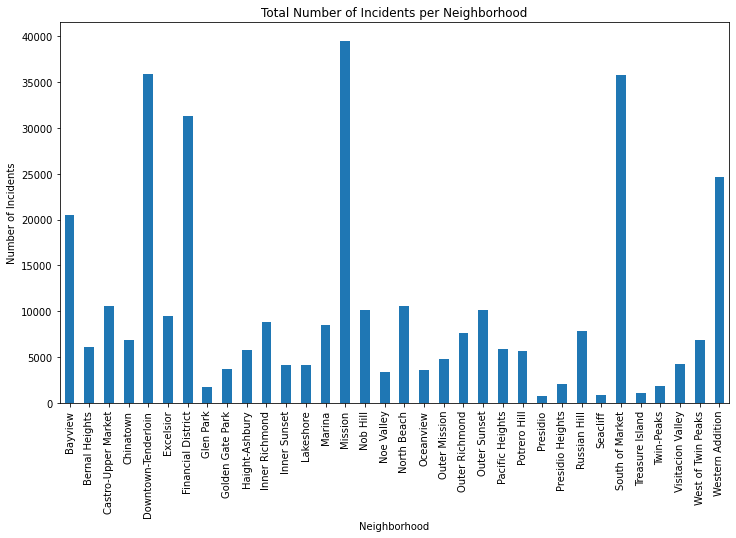

In [75]:
tot_incidents_SF_final_neighborhood.plot(kind='bar', figsize=(12, 7))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of Incidents') # add y-label to the plot
plt.title('Total Number of Incidents per Neighborhood') # add title to the plot
plt.legend('',frameon=False)


plt.show()

In [76]:
tot_incidents_SF_final_neighborhood_sorted = tot_incidents_SF_final_neighborhood.copy()

In [77]:
tot_incidents_SF_final_neighborhood_sorted.sort_values(['Incident Category'], ascending=True, axis=0, inplace=True)
tot_incidents_SF_final_neighborhood_sorted

Incident Category
Neighborhood                          
Presidio                           798
Seacliff                           820
Treasure Island                   1133
Glen Park                         1780
Twin-Peaks                        1795
Presidio Heights                  2099
Noe Valley                        3339
Oceanview                         3557
Golden Gate Park                  3669
Inner Sunset                      4125
Lakeshore                         4128
Visitacion Valley                 4271
Outer Mission                     4822
Potrero Hill                      5658
Haight-Ashbury                    5818
Pacific Heights                   5938
Bernal Heights                    6097
Chinatown                         6865
West of Twin Peaks                6920
Outer Richmond                    7646
Russian Hill                      7862
Marina                            8461
Inner Richmond                    8834
Excelsior                         9518
Nob Hill                         10097
Outer Sunset                     10111
North Beach                      10558
Castro-Upper Market              10572
Bayview                          20514
Western Addition                 24599
Financial District               31349
South of Market                  35769
Downtown-Tenderloin              35920
Mission                          39544

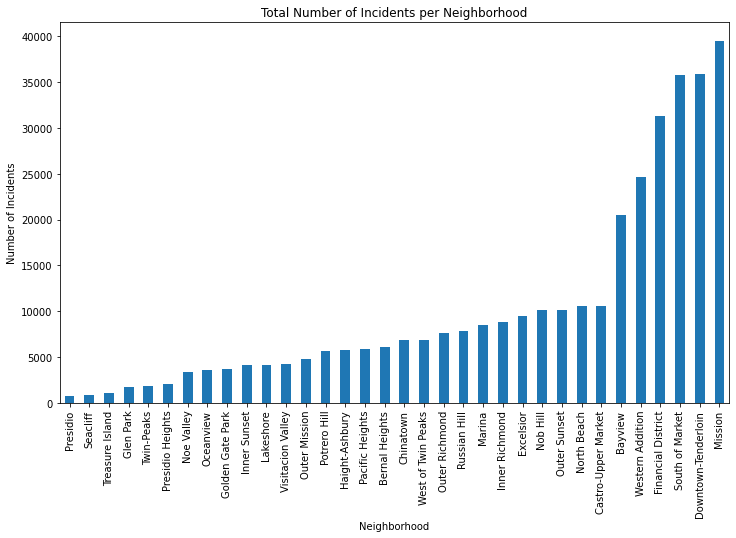

In [78]:
tot_incidents_SF_final_neighborhood_sorted.plot(kind='bar', figsize=(12, 7))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of Incidents') # add y-label to the plot
plt.title('Total Number of Incidents per Neighborhood') # add title to the plot
plt.legend('',frameon=False)


plt.show()

We see that the number of incidents reported by the Police of San Francisco from 2018 to Present is particularly high in the 6 following neighborhoods:

1. Mission
2. Downtown-Tenderloin
3. South of Market
4. Financial District
5. Western Addition
6. Bayview

### Total Number of Incidents per Neighborhood: Choropleth Map

We want now visualize how the total number of incidents is distributed on each neighborhood. To do that we create a Choropleth map using the dataframe below

In [79]:
tot_incidents_SF_final_neighborhood.head()

Incident Category
Neighborhood                          
Bayview                          20514
Bernal Heights                    6097
Castro-Upper Market              10572
Chinatown                         6865
Downtown-Tenderloin              35920

In [80]:
tot_incidents_SF_final_neighborhood.shape

(34, 1)

In this dataframe, the neighborhoods "Parkside", "Diamond Heights" and "Crocker Amazon" are missing because the data are included into "Outer Sunset", "Glen Park" and "Excelsior", respectively. To create the map, we include them also by copying the rows for "Outer Sunset", "Glen Park" and "Excelsior" and renaming them into "Parkside", "Diamond Heights" and "Crocker Amazon".

We include the missing neighborhoods as follows

In [81]:
tot_incidents_SF_final_neighborhood_new = tot_incidents_SF_final_neighborhood.T
tot_incidents_SF_final_neighborhood_new

Neighborhood       Bayview  Bernal Heights  Castro-Upper Market  Chinatown  \
Incident Category    20514            6097                10572       6865   

Neighborhood       Downtown-Tenderloin  Excelsior  Financial District  \
Incident Category                35920       9518               31349   

Neighborhood       Glen Park  Golden Gate Park  Haight-Ashbury  \
Incident Category       1780              3669            5818   

Neighborhood       Inner Richmond  Inner Sunset  Lakeshore  Marina  Mission  \
Incident Category            8834          4125       4128    8461    39544   

Neighborhood       Nob Hill  Noe Valley  North Beach  Oceanview  \
Incident Category     10097        3339        10558       3557   

Neighborhood       Outer Mission  Outer Richmond  Outer Sunset  \
Incident Category           4822            7646         10111   

Neighborhood       Pacific Heights  Potrero Hill  Presidio  Presidio Heights  \
Incident Category             5938          5658       798              2099   

Neighborhood       Russian Hill  Seacliff  South of Market  Treasure Island  \
Incident Category          7862       820            35769             1133   

Neighborhood       Twin-Peaks  Visitacion Valley  West of Twin Peaks  \
Incident Category        1795               4271                6920   

Neighborhood       Western Addition  
Incident Category             24599

In [82]:
tot_incidents_SF_final_neighborhood_new['Crocker Amazon'] = tot_incidents_SF_final_neighborhood_new['Excelsior']
tot_incidents_SF_final_neighborhood_new['Diamond Heights'] = tot_incidents_SF_final_neighborhood_new['Glen Park']
tot_incidents_SF_final_neighborhood_new['Parkside'] = tot_incidents_SF_final_neighborhood_new['Outer Sunset']

In [83]:
tot_incidents_SF_final_neighborhood_new

Neighborhood       Bayview  Bernal Heights  Castro-Upper Market  Chinatown  \
Incident Category    20514            6097                10572       6865   

Neighborhood       Downtown-Tenderloin  Excelsior  Financial District  \
Incident Category                35920       9518               31349   

Neighborhood       Glen Park  Golden Gate Park  Haight-Ashbury  \
Incident Category       1780              3669            5818   

Neighborhood       Inner Richmond  Inner Sunset  Lakeshore  Marina  Mission  \
Incident Category            8834          4125       4128    8461    39544   

Neighborhood       Nob Hill  Noe Valley  North Beach  Oceanview  \
Incident Category     10097        3339        10558       3557   

Neighborhood       Outer Mission  Outer Richmond  Outer Sunset  \
Incident Category           4822            7646         10111   

Neighborhood       Pacific Heights  Potrero Hill  Presidio  Presidio Heights  \
Incident Category             5938          5658       798              2099   

Neighborhood       Russian Hill  Seacliff  South of Market  Treasure Island  \
Incident Category          7862       820            35769             1133   

Neighborhood       Twin-Peaks  Visitacion Valley  West of Twin Peaks  \
Incident Category        1795               4271                6920   

Neighborhood       Western Addition  Crocker Amazon  Diamond Heights  Parkside  
Incident Category             24599            9518             1780     10111

In [84]:
tot_incidents_SF_final_neighborhood_new = tot_incidents_SF_final_neighborhood_new.T
tot_incidents_SF_final_neighborhood_new

Incident Category
Neighborhood                          
Bayview                          20514
Bernal Heights                    6097
Castro-Upper Market              10572
Chinatown                         6865
Downtown-Tenderloin              35920
Excelsior                         9518
Financial District               31349
Glen Park                         1780
Golden Gate Park                  3669
Haight-Ashbury                    5818
Inner Richmond                    8834
Inner Sunset                      4125
Lakeshore                         4128
Marina                            8461
Mission                          39544
Nob Hill                         10097
Noe Valley                        3339
North Beach                      10558
Oceanview                         3557
Outer Mission                     4822
Outer Richmond                    7646
Outer Sunset                     10111
Pacific Heights                   5938
Potrero Hill                      5658
Presidio                           798
Presidio Heights                  2099
Russian Hill                      7862
Seacliff                           820
South of Market                  35769
Treasure Island                   1133
Twin-Peaks                        1795
Visitacion Valley                 4271
West of Twin Peaks                6920
Western Addition                 24599
Crocker Amazon                    9518
Diamond Heights                   1780
Parkside                         10111

In [85]:
tot_incidents_SF_final_neighborhood_new.reset_index(inplace=True)

We create then a map of San Francisco with the neighborhoods. A click on the black spot on each neighborhood will show the corresponding name. Darker colors refer to a higher number of incidents/crimes in that neighborhood.

In [86]:
san_francisco_map_PN = folium.Map(location=[latitude, longitude], zoom_start=12)

san_francisco_map_PN.choropleth(
    geo_data=san_francisco_geo_PN,
    data=tot_incidents_SF_final_neighborhood_new,
    columns=['Neighborhood','Incident Category'],
    key_on='feature.properties.neighborho',
    fill_color='YlOrRd',
    fill_opacity=0.6,
    line_opacity=1,
    legend_name='Total Incidents/Crimes in San Francisco',
    reset=True
)

# add markers to the map
markers_colors = []
for lat, lon, neighborhood in zip(neighborhoods_SF_coord['Latitude'], neighborhoods_SF_coord['Longitude'], neighborhoods_SF_coord['Neighborhood']):
    label = folium.Popup(str(neighborhood), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=['black'],
#         color=rainbow[cluster-1],
#         color=['red','orange','green','blue'],
        fill=True,
        fill_color='black',
#         fill_color=['red','orange','green','blue'],
        fill_opacity=1).add_to(san_francisco_map_PN)


san_francisco_map_PN

With the help of this map we see now clearly that "Mission", "Downtown-Tenderloin", "South of Market", "Financial District", "Western Addition", and "Bayview" are the neighborhoods where incidents/crimes occur the most.

---------------

### Total Number of Incidents per Category

In [87]:
tot_incidents_SF_final_category = incidents_SF_final.groupby('Incident Category').count()
tot_incidents_SF_final_category

Neighborhood
Incident Category                                         
Arson                                                  888
Assault                                              21454
Burglary                                             17336
Case Closure                                          1488
Civil Sidewalks                                        859
Courtesy Report                                       1042
Disorderly Conduct                                    6369
Drug Offense                                          9121
Drug Violation                                         116
Embezzlement                                           513
Family Offense                                         471
Fire Report                                            391
Forgery And Counterfeiting                            1540
Fraud                                                10623
Gambling                                                21
Homicide                                                42
Human Trafficking (A), Commercial Sex Acts             105
Human Trafficking (B), Involuntary Servitude             1
Human Trafficking, Commercial Sex Acts                  17
Juvenile Offenses                                        1
Larceny Theft                                       103475
Liquor Laws                                             73
Lost Property                                        10138
Malicious Mischief                                   21393
Miscellaneous Investigation                           3271
Missing Person                                        8302
Motor Vehicle Theft                                  14037
Motor Vehicle Theft?                                    47
Non-Criminal                                         22124
Offences Against The Family And Children              7092
Other                                                 2563
Other Miscellaneous                                  27113
Other Offenses                                        2631
Prostitution                                           808
Rape                                                    98
Recovered Vehicle                                     8255
Robbery                                               8502
Sex Offense                                           1046
Stolen Property                                       1860
Suicide                                                167
Suspicious                                              66
Suspicious Occ                                        6902
Traffic Collision                                      685
Traffic Violation Arrest                              4500
Vandalism                                              531
Vehicle Impounded                                      252
Vehicle Misplaced                                      156
Warrant                                              12668
Weapons Carrying Etc                                  1868
Weapons Offence                                         17
Weapons Offense                                       1948

In [88]:
tot_incidents_SF_final_category.shape

(51, 1)

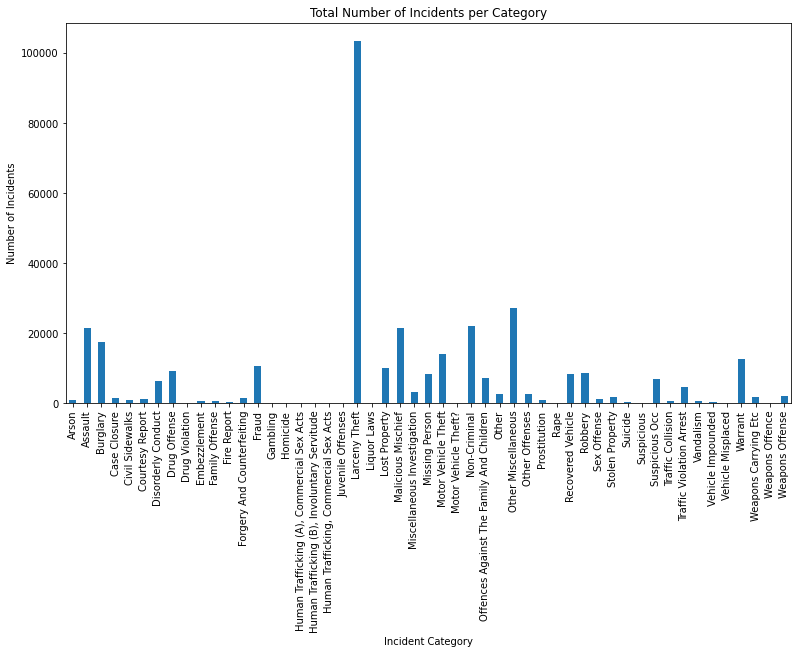

In [89]:
tot_incidents_SF_final_category.plot(kind='bar', figsize=(13, 7))

plt.xlabel('Incident Category') # add to x-label to the plot
plt.ylabel('Number of Incidents') # add y-label to the plot
plt.title('Total Number of Incidents per Category') # add title to the plot
plt.legend('',frameon=False)


plt.show()

In [90]:
tot_incidents_SF_final_category_sorted = tot_incidents_SF_final_category.copy()

In [91]:
tot_incidents_SF_final_category_sorted.sort_values(['Neighborhood'], ascending=True, axis=0, inplace=True)
tot_incidents_SF_final_category_sorted

Neighborhood
Incident Category                                         
Juvenile Offenses                                        1
Human Trafficking (B), Involuntary Servitude             1
Human Trafficking, Commercial Sex Acts                  17
Weapons Offence                                         17
Gambling                                                21
Homicide                                                42
Motor Vehicle Theft?                                    47
Suspicious                                              66
Liquor Laws                                             73
Rape                                                    98
Human Trafficking (A), Commercial Sex Acts             105
Drug Violation                                         116
Vehicle Misplaced                                      156
Suicide                                                167
Vehicle Impounded                                      252
Fire Report                                            391
Family Offense                                         471
Embezzlement                                           513
Vandalism                                              531
Traffic Collision                                      685
Prostitution                                           808
Civil Sidewalks                                        859
Arson                                                  888
Courtesy Report                                       1042
Sex Offense                                           1046
Case Closure                                          1488
Forgery And Counterfeiting                            1540
Stolen Property                                       1860
Weapons Carrying Etc                                  1868
Weapons Offense                                       1948
Other                                                 2563
Other Offenses                                        2631
Miscellaneous Investigation                           3271
Traffic Violation Arrest                              4500
Disorderly Conduct                                    6369
Suspicious Occ                                        6902
Offences Against The Family And Children              7092
Recovered Vehicle                                     8255
Missing Person                                        8302
Robbery                                               8502
Drug Offense                                          9121
Lost Property                                        10138
Fraud                                                10623
Warrant                                              12668
Motor Vehicle Theft                                  14037
Burglary                                             17336
Malicious Mischief                                   21393
Assault                                              21454
Non-Criminal                                         22124
Other Miscellaneous                                  27113
Larceny Theft                                       103475

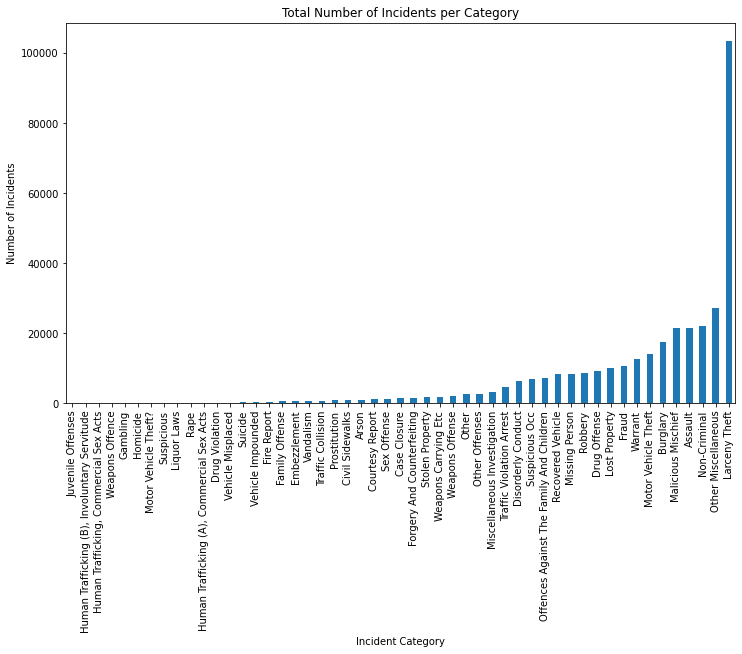

In [92]:
tot_incidents_SF_final_category_sorted.plot(kind='bar', figsize=(12, 7))

plt.xlabel('Incident Category') # add to x-label to the plot
plt.ylabel('Number of Incidents') # add y-label to the plot
plt.title('Total Number of Incidents per Category') # add title to the plot
plt.legend('',frameon=False)


plt.show()

__IMPORTANT__  We see that "Larceny Theft" is the most frequent type of crime in San Francisco, well above all the others. We create then a new dataframe without this particular category to see how the other categories are distributed.

In [93]:
tot_incidents_SF_final_category_sorted_noLarceny = tot_incidents_SF_final_category_sorted.drop(['Larceny Theft'],axis=0)

In [94]:
tot_incidents_SF_final_category_sorted_noLarceny

Neighborhood
Incident Category                                         
Juvenile Offenses                                        1
Human Trafficking (B), Involuntary Servitude             1
Human Trafficking, Commercial Sex Acts                  17
Weapons Offence                                         17
Gambling                                                21
Homicide                                                42
Motor Vehicle Theft?                                    47
Suspicious                                              66
Liquor Laws                                             73
Rape                                                    98
Human Trafficking (A), Commercial Sex Acts             105
Drug Violation                                         116
Vehicle Misplaced                                      156
Suicide                                                167
Vehicle Impounded                                      252
Fire Report                                            391
Family Offense                                         471
Embezzlement                                           513
Vandalism                                              531
Traffic Collision                                      685
Prostitution                                           808
Civil Sidewalks                                        859
Arson                                                  888
Courtesy Report                                       1042
Sex Offense                                           1046
Case Closure                                          1488
Forgery And Counterfeiting                            1540
Stolen Property                                       1860
Weapons Carrying Etc                                  1868
Weapons Offense                                       1948
Other                                                 2563
Other Offenses                                        2631
Miscellaneous Investigation                           3271
Traffic Violation Arrest                              4500
Disorderly Conduct                                    6369
Suspicious Occ                                        6902
Offences Against The Family And Children              7092
Recovered Vehicle                                     8255
Missing Person                                        8302
Robbery                                               8502
Drug Offense                                          9121
Lost Property                                        10138
Fraud                                                10623
Warrant                                              12668
Motor Vehicle Theft                                  14037
Burglary                                             17336
Malicious Mischief                                   21393
Assault                                              21454
Non-Criminal                                         22124
Other Miscellaneous                                  27113

In [95]:
tot_incidents_SF_final_category_sorted_noLarceny.shape

(50, 1)

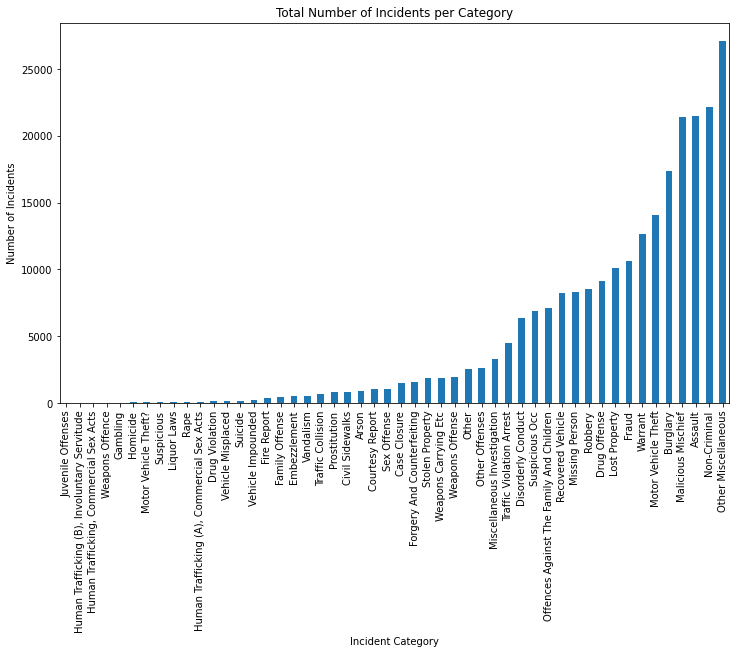

In [96]:
tot_incidents_SF_final_category_sorted_noLarceny.plot(kind='bar', figsize=(12, 7))

plt.xlabel('Incident Category') # add to x-label to the plot
plt.ylabel('Number of Incidents') # add y-label to the plot
plt.title('Total Number of Incidents per Category') # add title to the plot
plt.legend('',frameon=False)

plt.show()

By excluding "Larceny Theft", we see that the most frequent type of incidents are:

1. Other Miscellaneous
2. Non-Criminal
3. Assault
4. Malicious Mischief
5. Burglary
6. Motor Vehicle Theft

------------------

### Total Number of Incidents VS Time

We finally check how the total number of incidents/crimes behaves as a function of time.

From the original dataframe *incidents_SF_full*, we select the attributes "Incident Date" and "Incident Category".

In [97]:
incidents_SF_full[['Incident Date', 'Incident Category']].head()

Incident Date                         Incident Category
0    2019/05/01  Offences Against The Family And Children
1    2019/06/22                              Non-Criminal
2    2019/06/03                            Missing Person
3    2018/11/16  Offences Against The Family And Children
4    2019/05/27                                   Assault

In [98]:
incidents_SF_full[['Incident Date', 'Incident Category']].shape

(364275, 2)

In [99]:
incidents_SF_full[['Incident Date', 'Incident Category']].groupby('Incident Date').count().head()

Incident Category
Incident Date                   
2018/01/01                   510
2018/01/02                   398
2018/01/03                   430
2018/01/04                   472
2018/01/05                   454

In [100]:
incidents_SF_full[['Incident Date', 'Incident Category']].groupby('Incident Date').count().shape

(925, 1)

In [101]:
incidents_SF_full_dates = incidents_SF_full[['Incident Date', 'Incident Category']].groupby('Incident Date').count().reset_index()
incidents_SF_full_dates.head()

Incident Date  Incident Category
0    2018/01/01                510
1    2018/01/02                398
2    2018/01/03                430
3    2018/01/04                472
4    2018/01/05                454

In [102]:
incidents_SF_full_dates.rename(columns={'Incident Category':'Incidents/Crimes','Incident Date':'Date'},inplace=True)
incidents_SF_full_dates.head()

Date  Incidents/Crimes
0  2018/01/01               510
1  2018/01/02               398
2  2018/01/03               430
3  2018/01/04               472
4  2018/01/05               454

In [103]:
incidents_SF_full_dates.dtypes

Date                object
Incidents/Crimes     int64
dtype: object

In [104]:
incidents_SF_full_dates['Date'] = pd.to_datetime(incidents_SF_full_dates['Date'])
incidents_SF_full_dates.head()

Date  Incidents/Crimes
0 2018-01-01               510
1 2018-01-02               398
2 2018-01-03               430
3 2018-01-04               472
4 2018-01-05               454

In [105]:
incidents_SF_full_dates.dtypes

Date                datetime64[ns]
Incidents/Crimes             int64
dtype: object

In [106]:
incidents_SF_full_dates['Date Number'] = pd.factorize(incidents_SF_full_dates['Date'])[0] + 1
incidents_SF_full_dates.head()

Date  Incidents/Crimes  Date Number
0 2018-01-01               510            1
1 2018-01-02               398            2
2 2018-01-03               430            3
3 2018-01-04               472            4
4 2018-01-05               454            5

In [107]:
len(incidents_SF_full_dates)

925

In [108]:
incidents_SF_full_dates[incidents_SF_full_dates['Date Number']==4].index[0]

3

In [109]:
incidents_SF_full_dates['Date'][incidents_SF_full_dates[incidents_SF_full_dates['Date Number']==912].index[0]]

Timestamp('2020-06-30 00:00:00')

In [110]:
mapping = dict(zip(incidents_SF_full_dates['Date Number'], incidents_SF_full_dates['Date'].dt.date))

We finally plot the total number of incidents/crimes per day as a funtion of time:

(-20.0, 940.0)

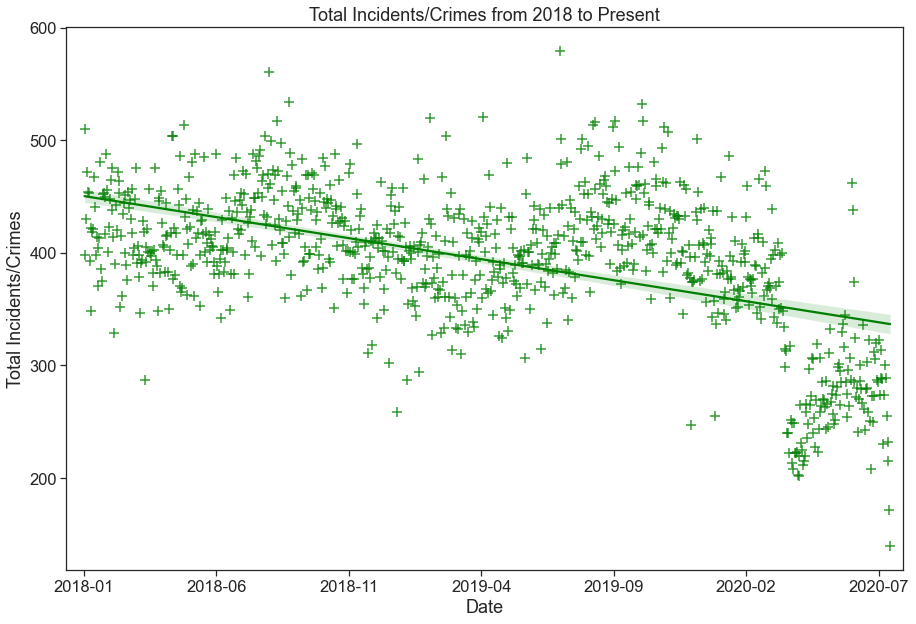

In [111]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.5)
sns.set_style('ticks')

ax = sns.regplot(x='Date Number', y='Incidents/Crimes', data=incidents_SF_full_dates, color='green', marker='+', scatter_kws={'s': 100})
ax.set(xlabel='Date', ylabel='Total Incidents/Crimes')
ax.set_title('Total Incidents/Crimes from 2018 to Present')

ax.set_xticks(range(0,len(incidents_SF_full_dates),152))
# labels = pd.Series(ax.get_xticks()).map(mapping).fillna('')
# ax.set_xticklabels(labels)
ax.set_xticklabels(['2018-01','2018-06','2018-11','2019-04','2019-09','2020-02','2020-07'])
ax.set_xlim(-20,940)

From this plot, we notice that there is a decrease of the number of incidents/crimes with time, especially since the beginning of 2020.

-----------------

<a id='item3'></a>

## 3. Analyzing Each Neighborhood

In order to analyze each neighborhood, we start by applying the **One Hot Encoding**

In [112]:
# one hot encoding
incidents_SF_onehot = pd.get_dummies(incidents_SF_final[['Incident Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
incidents_SF_onehot['Neighborhood'] = incidents_SF_final['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [incidents_SF_onehot.columns[-1]] + list(incidents_SF_onehot.columns[:-1])
incidents_SF_onehot = incidents_SF_onehot[fixed_columns]

incidents_SF_onehot.head()

Neighborhood  Arson  Assault  Burglary  Case Closure  Civil Sidewalks  \
0     Outer Sunset      0        0         0             0                0   
1  South of Market      0        0         0             0                0   
2          Bayview      0        0         0             0                0   
3        Chinatown      0        0         0             0                0   
4           Marina      0        1         0             0                0   

   Courtesy Report  Disorderly Conduct  Drug Offense  Drug Violation  \
0                0                   0             0               0   
1                0                   0             0               0   
2                0                   0             0               0   
3                0                   0             0               0   
4                0                   0             0               0   

   Embezzlement  Family Offense  Fire Report  Forgery And Counterfeiting  \
0             0               0            0                           0   
1             0               0            0                           0   
2             0               0            0                           0   
3             0               0            0                           0   
4             0               0            0                           0   

   Fraud  Gambling  Homicide  Human Trafficking (A), Commercial Sex Acts  \
0      0         0         0                                           0   
1      0         0         0                                           0   
2      0         0         0                                           0   
3      0         0         0                                           0   
4      0         0         0                                           0   

   Human Trafficking (B), Involuntary Servitude  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   Human Trafficking, Commercial Sex Acts  Juvenile Offenses  Larceny Theft  \
0                                       0                  0              0   
1                                       0                  0              0   
2                                       0                  0              0   
3                                       0                  0              0   
4                                       0                  0              0   

   Liquor Laws  Lost Property  Malicious Mischief  \
0            0              0                   0   
1            0              0                   0   
2            0              0                   0   
3            0              0                   0   
4            0              0                   0   

   Miscellaneous Investigation  Missing Person  Motor Vehicle Theft  \
0                            0               0                    0   
1                            0               0                    0   
2                            0               1                    0   
3                            0               0                    0   
4                            0               0                    0   

   Motor Vehicle Theft?  Non-Criminal  \
0                     0             0   
1                     0             1   
2                     0             0   
3                     0             0   
4                     0             0   

   Offences Against The Family And Children  Other  Other Miscellaneous  \
0                                         1      0                    0   
1                                         0      0                    0   
2                                         0      0                    0   
3                                         1      0                    0   
4                                 

In [113]:
incidents_SF_onehot.shape

(344986, 52)

Next, we group the rows by neighborhood and we calculate the mean of the frequency of occurrence of each incident/crime category

In [114]:
incidents_SF_grouped = incidents_SF_onehot.groupby('Neighborhood').mean().reset_index()
incidents_SF_grouped

Neighborhood     Arson   Assault  Burglary  Case Closure  \
0               Bayview  0.005508  0.094765  0.042898      0.002730   
1        Bernal Heights  0.002624  0.067902  0.062982      0.001148   
2   Castro-Upper Market  0.003405  0.072361  0.060348      0.004162   
3             Chinatown  0.004953  0.055790  0.046613      0.004079   
4   Downtown-Tenderloin  0.002227  0.086219  0.025251      0.001893   
5             Excelsior  0.001891  0.071759  0.046333      0.004203   
6    Financial District  0.002329  0.056748  0.063096      0.005455   
7             Glen Park  0.000000  0.052247  0.077528      0.002809   
8      Golden Gate Park  0.005724  0.038158  0.028346      0.008449   
9        Haight-Ashbury  0.003266  0.047095  0.053283      0.007735   
10       Inner Richmond  0.002038  0.039506  0.056034      0.010754   
11         Inner Sunset  0.000485  0.044606  0.069091      0.006545   
12            Lakeshore  0.001696  0.049419  0.031008      0.004118   
13               Marina  0.001536  0.032384  0.082378      0.002127   
14              Mission  0.002504  0.079127  0.036162      0.001846   
15             Nob Hill  0.003169  0.055363  0.068535      0.002179   
16           Noe Valley  0.001198  0.028152  0.123690      0.002695   
17          North Beach  0.000852  0.042432  0.034097      0.003315   
18            Oceanview  0.003374  0.065505  0.050604      0.004217   
19        Outer Mission  0.003526  0.060971  0.049772      0.004770   
20       Outer Richmond  0.001439  0.037928  0.041198      0.003793   
21         Outer Sunset  0.002275  0.046484  0.049154      0.003165   
22      Pacific Heights  0.001684  0.026271  0.091782      0.003368   
23         Potrero Hill  0.002651  0.043832  0.072110      0.003005   
24             Presidio  0.001253  0.040100  0.017544      0.005013   
25     Presidio Heights  0.002382  0.039543  0.074321      0.003811   
26         Russian Hill  0.001399  0.026711  0.060036      0.002035   
27             Seacliff  0.000000  0.018293  0.045122      0.003659   
28      South of Market  0.002432  0.073919  0.048925      0.011015   
29      Treasure Island  0.000883  0.094440  0.085613      0.006178   
30           Twin-Peaks  0.000000  0.033983  0.062396      0.006128   
31    Visitacion Valley  0.005619  0.087801  0.043315      0.005619   
32   West of Twin Peaks  0.001445  0.039740  0.075723      0.004335   
33     Western Addition  0.002724  0.046669  0.048945      0.002602   

    Civil Sidewalks  Courtesy Report  Disorderly Conduct  Drug Offense  \
0          0.000000         0.003364            0.028517      0.009993   
1          0.000000         0.000820            0.020010      0.011153   
2          0.021377         0.000662            0.019864      0.017877   
3          0.000000         0.033649            0.016752      0.010634   
4          0.000278         0.002617            0.016342      0.113335   
5          0.000000         0.001681            0.024795      0.010927   
6          0.000159         0.000766            0.014514      0.008358   
7          0.000000         0.000000            0.014045      0.009551   
8          0.002453         0.003271            0.006814      0.018806   
9          0.086971         0.000688            0.012547      0.033689   
10         0.000792         0.007132            0.016187      0.006339   
11         0.000242         0.000485            0.016242      0.004121   
12         0.000000         0.001938            0.022771      0.004360   
13         0.001182         0.000827            0.020683      0.005555   
14         0.000759         0.002276            0.022127      0.030902   
15         0.000297         0.000495            0.014955      0.012281   
16         0.000000         0.002096            0.013477      0.001797   
17         0.000947         0.000379            0.013450      0.009187   
18         0.000000         0.002249            0.019961      0.005904   
19         0.000000         0.008503         

In [115]:
incidents_SF_grouped.shape

(34, 52)

Let us print each neighborhood along with the top 5 most common incidents/crimes:

In [116]:
num_top_incidents = 5

for hood in incidents_SF_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = incidents_SF_grouped[incidents_SF_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['INCIDENT','FREQ']
    temp = temp.iloc[1:]
    temp['FREQ'] = temp['FREQ'].astype(float)
    temp = temp.round({'FREQ': 2})
    print(temp.sort_values('FREQ', ascending=False).reset_index(drop=True).head(num_top_incidents))
    print('\n')

----Bayview----
              INCIDENT  FREQ
0        Larceny Theft  0.16
1              Assault  0.09
2  Motor Vehicle Theft  0.08
3  Other Miscellaneous  0.08
4   Malicious Mischief  0.07


----Bernal Heights----
              INCIDENT  FREQ
0        Larceny Theft  0.24
1  Other Miscellaneous  0.08
2   Malicious Mischief  0.08
3              Assault  0.07
4  Motor Vehicle Theft  0.07


----Castro-Upper Market----
              INCIDENT  FREQ
0        Larceny Theft  0.30
1   Malicious Mischief  0.07
2              Assault  0.07
3  Other Miscellaneous  0.07
4             Burglary  0.06


----Chinatown----
              INCIDENT  FREQ
0        Larceny Theft  0.29
1         Non-Criminal  0.09
2  Other Miscellaneous  0.07
3   Malicious Mischief  0.07
4        Lost Property  0.07


----Downtown-Tenderloin----
              INCIDENT  FREQ
0        Larceny Theft  0.19
1         Drug Offense  0.11
2              Assault  0.09
3  Other Miscellaneous  0.09
4              Warrant  0.08


----Exc

We are now in a position to put that into a *pandas* dataframe. First, let's write a function to sort the incidents/crimes in descending order.

In [117]:
def return_most_common_incidents(row, num_top_incidents):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_incidents]

Now let's create the new dataframe and display the top 10 incidents/crimes for each neighborhood.

In [118]:
num_top_incidents = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_incidents):
    try:
        columns.append('{}{} Most Common Incident'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Incident'.format(ind+1))

# create a new dataframe
neighborhoods_incidents_sorted = pd.DataFrame(columns=columns)
neighborhoods_incidents_sorted['Neighborhood'] = incidents_SF_grouped['Neighborhood']

for ind in np.arange(incidents_SF_grouped.shape[0]):
    neighborhoods_incidents_sorted.iloc[ind, 1:] = return_most_common_incidents(incidents_SF_grouped.iloc[ind, :], num_top_incidents)

neighborhoods_incidents_sorted.head()

Neighborhood 1st Most Common Incident 2nd Most Common Incident  \
0              Bayview            Larceny Theft                  Assault   
1       Bernal Heights            Larceny Theft      Other Miscellaneous   
2  Castro-Upper Market            Larceny Theft      Other Miscellaneous   
3            Chinatown            Larceny Theft             Non-Criminal   
4  Downtown-Tenderloin            Larceny Theft             Drug Offense   

  3rd Most Common Incident 4th Most Common Incident 5th Most Common Incident  \
0      Other Miscellaneous      Motor Vehicle Theft       Malicious Mischief   
1       Malicious Mischief      Motor Vehicle Theft                  Assault   
2                  Assault       Malicious Mischief             Non-Criminal   
3      Other Miscellaneous            Lost Property       Malicious Mischief   
4      Other Miscellaneous                  Assault             Non-Criminal   

  6th Most Common Incident 7th Most Common Incident 8th Most Common Incident  \
0        Recovered Vehicle             Non-Criminal                 Burglary   
1             Non-Criminal                 Burglary        Recovered Vehicle   
2                 Burglary                  Warrant      Motor Vehicle Theft   
3                  Assault                 Burglary                    Fraud   
4                  Warrant       Malicious Mischief            Lost Property   

                   9th Most Common Incident  \
0  Offences Against The Family And Children   
1                                     Fraud   
2                             Lost Property   
3                           Courtesy Report   
4                                   Robbery   

                  10th Most Common Incident  
0                                   Warrant  
1  Offences Against The Family And Children  
2                                     Fraud  
3                            Suspicious Occ  
4                                  Burglary

In [119]:
neighborhoods_incidents_sorted.shape

(34, 11)

<a id='item4'></a>

## 4. Neighborhoods Clustering

In this section, we group the neighborhoods into clusters by means of the k-means clustering technique and we analyze the resulting clusters.

## 4.1. _K_-means Clustering

How many clusters should we group the neighborhoods into? We can use the elbow method to decide. We plot the so-called Inertia namely the sum of squared distances of the data points from their cluster's center for increasing numbers of clusters and see if we can find a clear cluster number where the decrease in distortion starts to level off.

In [120]:
incidents_SF_grouped_clustering = incidents_SF_grouped.drop('Neighborhood', 1)

inertia = []
K = range(1,12)
for kkk in K:
    kmeanModel = KMeans(init="k-means++", n_clusters=kkk, n_init=2000).fit(incidents_SF_grouped_clustering)
    inertia.append(kmeanModel.inertia_)

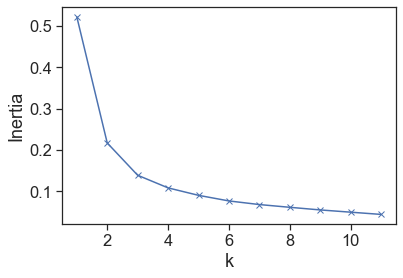

In [121]:
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

We see that the optimal number of clusters is 3 or 4. After trying with different values, even larger than 4, we decided to choose **--- 4 ---** and the results we obtain are shown below.

In [122]:
# set number of clusters
kclusters = 4

incidents_SF_grouped_clustering = incidents_SF_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=2000, random_state=0).fit(incidents_SF_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 3, 3, 0, 0, 2, 3, 2, 3], dtype=int32)

Let us create a new dataframe that includes the cluster as well as the top 10 incidents/crimes for each neighborhood.

In [123]:
# add clustering labels
neighborhoods_incidents_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

incidents_SF_merged = neighborhoods_SF_coord

incidents_SF_merged = incidents_SF_merged.join(neighborhoods_incidents_sorted.set_index('Neighborhood'), on='Neighborhood', how='right')

incidents_SF_merged.head() # check the last columns!

Neighborhood   Latitude   Longitude  Cluster Labels  \
0          Seacliff  37.784973 -122.501423               1   
1    Outer Richmond  37.777818 -122.492410               2   
2  Golden Gate Park  37.769383 -122.481940               2   
3      Outer Sunset  37.755419 -122.493805               3   
5         Lakeshore  37.721792 -122.485235               2   

  1st Most Common Incident 2nd Most Common Incident 3rd Most Common Incident  \
0            Larceny Theft             Non-Criminal       Malicious Mischief   
1            Larceny Theft             Non-Criminal      Other Miscellaneous   
2            Larceny Theft             Non-Criminal      Other Miscellaneous   
3            Larceny Theft             Non-Criminal                    Fraud   
5            Larceny Theft       Malicious Mischief      Other Miscellaneous   

  4th Most Common Incident 5th Most Common Incident 6th Most Common Incident  \
0      Motor Vehicle Theft                 Burglary      Other Miscellaneous   
1       Malicious Mischief      Motor Vehicle Theft                    Fraud   
2       Malicious Mischief           Missing Person                  Assault   
3       Malicious Mischief           Missing Person      Motor Vehicle Theft   
5             Non-Criminal                  Assault      Motor Vehicle Theft   

  7th Most Common Incident 8th Most Common Incident 9th Most Common Incident  \
0                    Fraud        Recovered Vehicle           Suspicious Occ   
1                 Burglary                  Assault        Recovered Vehicle   
2      Motor Vehicle Theft                 Burglary        Recovered Vehicle   
3      Other Miscellaneous                 Burglary                  Assault   
5                    Fraud            Lost Property                 Burglary   

                  10th Most Common Incident  
0                                   Assault  
1                            Suspicious Occ  
2                             Lost Property  
3  Offences Against The Family And Children  
5                        Disorderly Conduct

In [124]:
incidents_SF_merged.shape

(34, 14)

In [125]:
incidents_SF_merged['Neighborhood'].unique()

array(['Seacliff', 'Outer Richmond', 'Golden Gate Park', 'Outer Sunset',
       'Lakeshore', 'Presidio', 'Inner Richmond', 'Inner Sunset',
       'West of Twin Peaks', 'Oceanview', 'Presidio Heights',
       'Haight-Ashbury', 'Twin-Peaks', 'Outer Mission', 'Marina',
       'Pacific Heights', 'Western Addition', 'Castro-Upper Market',
       'Noe Valley', 'Glen Park', 'Russian Hill', 'Nob Hill',
       'Downtown-Tenderloin', 'Mission', 'Bernal Heights', 'Excelsior',
       'Visitacion Valley', 'North Beach', 'Chinatown',
       'Financial District', 'South of Market', 'Potrero Hill', 'Bayview',
       'Treasure Island'], dtype=object)

In [126]:
neighborhoods_SF_coord['Neighborhood'].unique()

array(['Seacliff', 'Outer Richmond', 'Golden Gate Park', 'Outer Sunset',
       'Parkside', 'Lakeshore', 'Presidio', 'Inner Richmond',
       'Inner Sunset', 'West of Twin Peaks', 'Oceanview',
       'Presidio Heights', 'Haight-Ashbury', 'Twin-Peaks',
       'Outer Mission', 'Crocker Amazon', 'Marina', 'Pacific Heights',
       'Western Addition', 'Castro-Upper Market', 'Noe Valley',
       'Diamond Heights', 'Glen Park', 'Russian Hill', 'Nob Hill',
       'Downtown-Tenderloin', 'Mission', 'Bernal Heights', 'Excelsior',
       'Visitacion Valley', 'North Beach', 'Chinatown',
       'Financial District', 'South of Market', 'Potrero Hill', 'Bayview',
       'Treasure Island'], dtype=object)

In [127]:
incidents_SF_merged.dtypes

Neighborhood                  object
Latitude                     float64
Longitude                    float64
Cluster Labels                 int32
1st Most Common Incident      object
2nd Most Common Incident      object
3rd Most Common Incident      object
4th Most Common Incident      object
5th Most Common Incident      object
6th Most Common Incident      object
7th Most Common Incident      object
8th Most Common Incident      object
9th Most Common Incident      object
10th Most Common Incident     object
dtype: object

In [128]:
incidents_SF_merged.dropna().shape

(34, 14)

------------------

### Including "Missing" Neighborhoods

In the dataframe *incidents_SF_merged*, the neighborhoods "Parkside", "Diamond Heights" and "Crocker Amazon" are missing because their data are included into "Outer Sunset", "Glen Park" and "Excelsior", respectively. Here, we include them also by copying the rows for "Outer Sunset", "Glen Park" and "Excelsior" and renaming them into "Parkside", "Diamond Heights" and "Crocker Amazon".

We include the missing neighborhoods as follows

In [129]:
incidents_SF_merged_temp = incidents_SF_merged.set_index(['Neighborhood']).T
incidents_SF_merged_temp

Neighborhood                          Seacliff       Outer Richmond  \
Latitude                                37.785              37.7778   
Longitude                             -122.501             -122.492   
Cluster Labels                               1                    2   
1st Most Common Incident         Larceny Theft        Larceny Theft   
2nd Most Common Incident          Non-Criminal         Non-Criminal   
3rd Most Common Incident    Malicious Mischief  Other Miscellaneous   
4th Most Common Incident   Motor Vehicle Theft   Malicious Mischief   
5th Most Common Incident              Burglary  Motor Vehicle Theft   
6th Most Common Incident   Other Miscellaneous                Fraud   
7th Most Common Incident                 Fraud             Burglary   
8th Most Common Incident     Recovered Vehicle              Assault   
9th Most Common Incident        Suspicious Occ    Recovered Vehicle   
10th Most Common Incident              Assault       Suspicious Occ   

Neighborhood                  Golden Gate Park  \
Latitude                               37.7694   
Longitude                             -122.482   
Cluster Labels                               2   
1st Most Common Incident         Larceny Theft   
2nd Most Common Incident          Non-Criminal   
3rd Most Common Incident   Other Miscellaneous   
4th Most Common Incident    Malicious Mischief   
5th Most Common Incident        Missing Person   
6th Most Common Incident               Assault   
7th Most Common Incident   Motor Vehicle Theft   
8th Most Common Incident              Burglary   
9th Most Common Incident     Recovered Vehicle   
10th Most Common Incident        Lost Property   

Neighborhood                                           Outer Sunset  \
Latitude                                                    37.7554   
Longitude                                                  -122.494   
Cluster Labels                                                    3   
1st Most Common Incident                              Larceny Theft   
2nd Most Common Incident                               Non-Criminal   
3rd Most Common Incident                                      Fraud   
4th Most Common Incident                         Malicious Mischief   
5th Most Common Incident                             Missing Person   
6th Most Common Incident                        Motor Vehicle Theft   
7th Most Common Incident                        Other Miscellaneous   
8th Most Common Incident                                   Burglary   
9th Most Common Incident                                    Assault   
10th Most Common Incident  Offences Against The Family And Children   

Neighborhood                         Lakeshore             Presidio  \
Latitude                               37.7218              37.7977   
Longitude                             -122.485             -122.468   
Cluster Labels                               2                    1   
1st Most Common Incident         Larceny Theft        Larceny Theft   
2nd Most Common Incident    Malicious Mischief         Non-Criminal   
3rd Most Common Incident   Other Miscellaneous                Fraud   
4th Most Common Incident          Non-Criminal  Other Miscellaneous   
5th Most Common Incident               Assault              Assault   
6th Most Common Incident   Motor Vehicle Theft   Malicious Mischief   
7th Most Common Incident                 Fraud                Other   
8th Most Common Incident         Lost Property        Lost Property   
9th Most Common Incident              Burglary       Suspicious Occ   
10th Most Common Incident   Disorderly Conduct              Warrant   

Neighborhood                    Inner Richmond         Inner Sunset  \
Latitude                                37.779              37.7594   
Longitude                             -122.467             -122.465   
Cluster Labels                               3                    3   
1st Most Common Incident      

In [130]:
incidents_SF_merged_temp['Crocker Amazon'] = incidents_SF_merged_temp['Excelsior']
incidents_SF_merged_temp['Diamond Heights'] = incidents_SF_merged_temp['Glen Park']
incidents_SF_merged_temp['Parkside'] = incidents_SF_merged_temp['Outer Sunset']

In [131]:
incidents_SF_merged_temp

Neighborhood                          Seacliff       Outer Richmond  \
Latitude                                37.785              37.7778   
Longitude                             -122.501             -122.492   
Cluster Labels                               1                    2   
1st Most Common Incident         Larceny Theft        Larceny Theft   
2nd Most Common Incident          Non-Criminal         Non-Criminal   
3rd Most Common Incident    Malicious Mischief  Other Miscellaneous   
4th Most Common Incident   Motor Vehicle Theft   Malicious Mischief   
5th Most Common Incident              Burglary  Motor Vehicle Theft   
6th Most Common Incident   Other Miscellaneous                Fraud   
7th Most Common Incident                 Fraud             Burglary   
8th Most Common Incident     Recovered Vehicle              Assault   
9th Most Common Incident        Suspicious Occ    Recovered Vehicle   
10th Most Common Incident              Assault       Suspicious Occ   

Neighborhood                  Golden Gate Park  \
Latitude                               37.7694   
Longitude                             -122.482   
Cluster Labels                               2   
1st Most Common Incident         Larceny Theft   
2nd Most Common Incident          Non-Criminal   
3rd Most Common Incident   Other Miscellaneous   
4th Most Common Incident    Malicious Mischief   
5th Most Common Incident        Missing Person   
6th Most Common Incident               Assault   
7th Most Common Incident   Motor Vehicle Theft   
8th Most Common Incident              Burglary   
9th Most Common Incident     Recovered Vehicle   
10th Most Common Incident        Lost Property   

Neighborhood                                           Outer Sunset  \
Latitude                                                    37.7554   
Longitude                                                  -122.494   
Cluster Labels                                                    3   
1st Most Common Incident                              Larceny Theft   
2nd Most Common Incident                               Non-Criminal   
3rd Most Common Incident                                      Fraud   
4th Most Common Incident                         Malicious Mischief   
5th Most Common Incident                             Missing Person   
6th Most Common Incident                        Motor Vehicle Theft   
7th Most Common Incident                        Other Miscellaneous   
8th Most Common Incident                                   Burglary   
9th Most Common Incident                                    Assault   
10th Most Common Incident  Offences Against The Family And Children   

Neighborhood                         Lakeshore             Presidio  \
Latitude                               37.7218              37.7977   
Longitude                             -122.485             -122.468   
Cluster Labels                               2                    1   
1st Most Common Incident         Larceny Theft        Larceny Theft   
2nd Most Common Incident    Malicious Mischief         Non-Criminal   
3rd Most Common Incident   Other Miscellaneous                Fraud   
4th Most Common Incident          Non-Criminal  Other Miscellaneous   
5th Most Common Incident               Assault              Assault   
6th Most Common Incident   Motor Vehicle Theft   Malicious Mischief   
7th Most Common Incident                 Fraud                Other   
8th Most Common Incident         Lost Property        Lost Property   
9th Most Common Incident              Burglary       Suspicious Occ   
10th Most Common Incident   Disorderly Conduct              Warrant   

Neighborhood                    Inner Richmond         Inner Sunset  \
Latitude                                37.779              37.7594   
Longitude                             -122.467             -122.465   
Cluster Labels                               3                    3   
1st Most Common Incident      

We finally modify the coordinates of "Parkside", "Diamond Heights" and "Crocker Amazon"

In [132]:
incidents_SF_merged_temp['Crocker Amazon']['Latitude'] = neighborhoods_SF_coord[neighborhoods_SF_coord['Neighborhood']=='Crocker Amazon'].iloc[0,1]
incidents_SF_merged_temp['Diamond Heights']['Latitude'] = neighborhoods_SF_coord[neighborhoods_SF_coord['Neighborhood']=='Diamond Heights'].iloc[0,1]
incidents_SF_merged_temp['Parkside']['Latitude'] = neighborhoods_SF_coord[neighborhoods_SF_coord['Neighborhood']=='Parkside'].iloc[0,1]

In [133]:
incidents_SF_merged_temp['Crocker Amazon']['Longitude'] = neighborhoods_SF_coord[neighborhoods_SF_coord['Neighborhood']=='Crocker Amazon'].iloc[0,2]
incidents_SF_merged_temp['Diamond Heights']['Longitude'] = neighborhoods_SF_coord[neighborhoods_SF_coord['Neighborhood']=='Diamond Heights'].iloc[0,2]
incidents_SF_merged_temp['Parkside']['Longitude'] = neighborhoods_SF_coord[neighborhoods_SF_coord['Neighborhood']=='Parkside'].iloc[0,2]

In [134]:
incidents_SF_merged_all = incidents_SF_merged_temp.T.reset_index()
incidents_SF_merged_all.head()

Neighborhood Latitude Longitude Cluster Labels  \
0          Seacliff   37.785  -122.501              1   
1    Outer Richmond  37.7778  -122.492              2   
2  Golden Gate Park  37.7694  -122.482              2   
3      Outer Sunset  37.7554  -122.494              3   
4         Lakeshore  37.7218  -122.485              2   

  1st Most Common Incident 2nd Most Common Incident 3rd Most Common Incident  \
0            Larceny Theft             Non-Criminal       Malicious Mischief   
1            Larceny Theft             Non-Criminal      Other Miscellaneous   
2            Larceny Theft             Non-Criminal      Other Miscellaneous   
3            Larceny Theft             Non-Criminal                    Fraud   
4            Larceny Theft       Malicious Mischief      Other Miscellaneous   

  4th Most Common Incident 5th Most Common Incident 6th Most Common Incident  \
0      Motor Vehicle Theft                 Burglary      Other Miscellaneous   
1       Malicious Mischief      Motor Vehicle Theft                    Fraud   
2       Malicious Mischief           Missing Person                  Assault   
3       Malicious Mischief           Missing Person      Motor Vehicle Theft   
4             Non-Criminal                  Assault      Motor Vehicle Theft   

  7th Most Common Incident 8th Most Common Incident 9th Most Common Incident  \
0                    Fraud        Recovered Vehicle           Suspicious Occ   
1                 Burglary                  Assault        Recovered Vehicle   
2      Motor Vehicle Theft                 Burglary        Recovered Vehicle   
3      Other Miscellaneous                 Burglary                  Assault   
4                    Fraud            Lost Property                 Burglary   

                  10th Most Common Incident  
0                                   Assault  
1                            Suspicious Occ  
2                             Lost Property  
3  Offences Against The Family And Children  
4                        Disorderly Conduct

In [135]:
incidents_SF_merged_all.shape

(37, 14)

----------

Finally, we can visualize the resulting clusters on the San Francisco map below. Click on the circle markers to see a popup with the name of the neighborhood and the cluster number.

In [136]:
# create map
map_SF_incidents_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighborhood, cluster in zip(incidents_SF_merged_all['Latitude'], incidents_SF_merged_all['Longitude'], incidents_SF_merged_all['Neighborhood'], incidents_SF_merged_all['Cluster Labels']):
    label = folium.Popup(str(neighborhood) + ' - ' + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=['black'],
#         color=rainbow[cluster-1],
#         color=['red','orange','green','blue'],
        fill=True,
        fill_color=rainbow[cluster-1],
#         fill_color=['red','orange','green','blue'],
        fill_opacity=1).add_to(map_SF_incidents_clusters)
       
map_SF_incidents_clusters

The clusters shown above have been obatined including the category "Larceny Theft", the one which seemed to be dominant over the others. Let us check that by examining more in details the most common incidents/venues in the clusters.

----------

## 4.2 Examine Clusters

Now, you can examine each cluster and determine the discriminating incidents/crimes categories that distinguish each cluster.

## 4.2.1. Top 10 Most Common Venues per Neighborhood per Cluster

### Cluster 0

In [137]:
incidents_SF_merged_all.loc[incidents_SF_merged_all['Cluster Labels'] == 0, incidents_SF_merged_all.columns[[0] + list(range(3, incidents_SF_merged_all.shape[1]))]]

Neighborhood Cluster Labels 1st Most Common Incident  \
9             Oceanview              0            Larceny Theft   
13        Outer Mission              0            Larceny Theft   
22  Downtown-Tenderloin              0            Larceny Theft   
23              Mission              0            Larceny Theft   
24       Bernal Heights              0            Larceny Theft   
25            Excelsior              0            Larceny Theft   
26    Visitacion Valley              0            Larceny Theft   
30      South of Market              0            Larceny Theft   
32              Bayview              0            Larceny Theft   
33      Treasure Island              0            Larceny Theft   
34       Crocker Amazon              0            Larceny Theft   

   2nd Most Common Incident 3rd Most Common Incident 4th Most Common Incident  \
9              Non-Criminal       Malicious Mischief      Other Miscellaneous   
13      Other Miscellaneous             Non-Criminal       Malicious Mischief   
22             Drug Offense      Other Miscellaneous                  Assault   
23      Other Miscellaneous                  Assault             Non-Criminal   
24      Other Miscellaneous       Malicious Mischief      Motor Vehicle Theft   
25      Other Miscellaneous      Motor Vehicle Theft                  Assault   
26       Malicious Mischief                  Assault      Other Miscellaneous   
30      Other Miscellaneous             Non-Criminal                  Assault   
32                  Assault      Other Miscellaneous      Motor Vehicle Theft   
33                  Assault                 Burglary             Non-Criminal   
34      Other Miscellaneous      Motor Vehicle Theft                  Assault   

   5th Most Common Incident 6th Most Common Incident  \
9       Motor Vehicle Theft                  Assault   
13      Motor Vehicle Theft                  Assault   
22             Non-Criminal                  Warrant   
23       Malicious Mischief                  Warrant   
24                  Assault             Non-Criminal   
25       Malicious Mischief             Non-Criminal   
26             Non-Criminal      Motor Vehicle Theft   
30       Malicious Mischief                  Warrant   
32       Malicious Mischief        Recovered Vehicle   
33       Malicious Mischief           Missing Person   
34       Malicious Mischief             Non-Criminal   

                    7th Most Common Incident 8th Most Common Incident  \
9                                   Burglary                    Fraud   
13                                  Burglary           Missing Person   
22                        Malicious Mischief            Lost Property   
23                       Motor Vehicle Theft                 Burglary   
24                                  Burglary        Recovered Vehicle   
25                                   Robbery                 Burglary   
26  Offences Against The Family And Children        Recovered Vehicle   
30                                  Burglary             Drug Offense   
32                              Non-Criminal                 Burglary   
33                       Other Miscellaneous      Motor Vehicle Theft   
34                                   Robbery                 Burglary   

                    9th Most Common Incident  \
9   Offences Against The Family And Children   
13                                   Robbery   
22                                   Robbery   
23                              Drug Offense   
24                                     Fraud   
25  Offences Against The Family And Children   
26                                  Burglary   
30                                     Fraud   
32  Offences Against The Family And Children   
33                            Suspicious Occ   
34  Offences Against The Family And Children   

                   10th Most Common Incident  
9                             Missing Person  
13          

### Cluster 1

In [138]:
incidents_SF_merged_all.loc[incidents_SF_merged_all['Cluster Labels'] == 1, incidents_SF_merged_all.columns[[0] + list(range(3, incidents_SF_merged_all.shape[1]))]]

Neighborhood Cluster Labels 1st Most Common Incident  \
0       Seacliff              1            Larceny Theft   
5       Presidio              1            Larceny Theft   
12    Twin-Peaks              1            Larceny Theft   
14        Marina              1            Larceny Theft   
20  Russian Hill              1            Larceny Theft   
27   North Beach              1            Larceny Theft   

   2nd Most Common Incident 3rd Most Common Incident 4th Most Common Incident  \
0              Non-Criminal       Malicious Mischief      Motor Vehicle Theft   
5              Non-Criminal                    Fraud      Other Miscellaneous   
12             Non-Criminal                 Burglary       Malicious Mischief   
14                 Burglary       Malicious Mischief             Non-Criminal   
20                 Burglary      Other Miscellaneous       Malicious Mischief   
27       Malicious Mischief      Other Miscellaneous             Non-Criminal   

   5th Most Common Incident 6th Most Common Incident 7th Most Common Incident  \
0                  Burglary      Other Miscellaneous                    Fraud   
5                   Assault       Malicious Mischief                    Other   
12      Other Miscellaneous      Motor Vehicle Theft                    Fraud   
14      Other Miscellaneous                    Fraud                  Assault   
20             Non-Criminal      Motor Vehicle Theft                    Fraud   
27                  Assault            Lost Property                 Burglary   

   8th Most Common Incident 9th Most Common Incident 10th Most Common Incident  
0         Recovered Vehicle           Suspicious Occ                   Assault  
5             Lost Property           Suspicious Occ                   Warrant  
12                  Assault       Disorderly Conduct            Suspicious Occ  
14      Motor Vehicle Theft            Lost Property        Disorderly Conduct  
20                  Assault            Lost Property                   Warrant  
27                    Fraud      Motor Vehicle Theft                   Warrant

### Cluster 2

In [139]:
incidents_SF_merged_all.loc[incidents_SF_merged_all['Cluster Labels'] == 2, incidents_SF_merged_all.columns[[0] + list(range(3, incidents_SF_merged_all.shape[1]))]]

Neighborhood Cluster Labels 1st Most Common Incident  \
1       Outer Richmond              2            Larceny Theft   
2     Golden Gate Park              2            Larceny Theft   
4            Lakeshore              2            Larceny Theft   
15     Pacific Heights              2            Larceny Theft   
16    Western Addition              2            Larceny Theft   
29  Financial District              2            Larceny Theft   
31        Potrero Hill              2            Larceny Theft   

   2nd Most Common Incident 3rd Most Common Incident 4th Most Common Incident  \
1              Non-Criminal      Other Miscellaneous       Malicious Mischief   
2              Non-Criminal      Other Miscellaneous       Malicious Mischief   
4        Malicious Mischief      Other Miscellaneous             Non-Criminal   
15                 Burglary       Malicious Mischief             Non-Criminal   
16       Malicious Mischief      Other Miscellaneous             Non-Criminal   
29      Other Miscellaneous                 Burglary       Malicious Mischief   
31       Malicious Mischief                 Burglary      Motor Vehicle Theft   

   5th Most Common Incident 6th Most Common Incident 7th Most Common Incident  \
1       Motor Vehicle Theft                    Fraud                 Burglary   
2            Missing Person                  Assault      Motor Vehicle Theft   
4                   Assault      Motor Vehicle Theft                    Fraud   
15      Motor Vehicle Theft      Other Miscellaneous                    Fraud   
16                 Burglary                  Assault      Motor Vehicle Theft   
29                  Assault            Lost Property             Non-Criminal   
31      Other Miscellaneous                  Assault             Non-Criminal   

   8th Most Common Incident 9th Most Common Incident 10th Most Common Incident  
1                   Assault        Recovered Vehicle            Suspicious Occ  
2                  Burglary        Recovered Vehicle             Lost Property  
4             Lost Property                 Burglary        Disorderly Conduct  
15                  Assault            Lost Property            Suspicious Occ  
16                    Fraud                  Warrant             Lost Property  
29                    Fraud                  Robbery                   Warrant  
31        Recovered Vehicle                  Warrant                     Fraud

### Cluster 3

In [140]:
incidents_SF_merged_all.loc[incidents_SF_merged_all['Cluster Labels'] == 3, incidents_SF_merged_all.columns[[0] + list(range(3, incidents_SF_merged_all.shape[1]))]]

Neighborhood Cluster Labels 1st Most Common Incident  \
3          Outer Sunset              3            Larceny Theft   
6        Inner Richmond              3            Larceny Theft   
7          Inner Sunset              3            Larceny Theft   
8    West of Twin Peaks              3            Larceny Theft   
10     Presidio Heights              3            Larceny Theft   
11       Haight-Ashbury              3            Larceny Theft   
17  Castro-Upper Market              3            Larceny Theft   
18           Noe Valley              3            Larceny Theft   
19            Glen Park              3            Larceny Theft   
21             Nob Hill              3            Larceny Theft   
28            Chinatown              3            Larceny Theft   
35      Diamond Heights              3            Larceny Theft   
36             Parkside              3            Larceny Theft   

   2nd Most Common Incident 3rd Most Common Incident 4th Most Common Incident  \
3              Non-Criminal                    Fraud       Malicious Mischief   
6              Non-Criminal      Other Miscellaneous       Malicious Mischief   
7        Malicious Mischief             Non-Criminal                 Burglary   
8                  Burglary      Other Miscellaneous       Malicious Mischief   
10                 Burglary       Malicious Mischief             Non-Criminal   
11          Civil Sidewalks             Non-Criminal      Other Miscellaneous   
17      Other Miscellaneous                  Assault       Malicious Mischief   
18                 Burglary      Motor Vehicle Theft       Malicious Mischief   
19                 Burglary             Non-Criminal       Malicious Mischief   
21      Other Miscellaneous       Malicious Mischief                 Burglary   
28             Non-Criminal      Other Miscellaneous            Lost Property   
35                 Burglary             Non-Criminal       Malicious Mischief   
36             Non-Criminal                    Fraud       Malicious Mischief   

   5th Most Common Incident 6th Most Common Incident 7th Most Common Incident  \
3            Missing Person      Motor Vehicle Theft      Other Miscellaneous   
6                  Burglary           Missing Person      Motor Vehicle Theft   
7            Missing Person      Motor Vehicle Theft      Other Miscellaneous   
8              Non-Criminal      Motor Vehicle Theft                    Fraud   
10      Other Miscellaneous      Motor Vehicle Theft                    Fraud   
11       Malicious Mischief                 Burglary      Motor Vehicle Theft   
17             Non-Criminal                 Burglary                  Warrant   
18             Non-Criminal      Other Miscellaneous                    Fraud   
19      Motor Vehicle Theft      Other Miscellaneous                  Assault   
21             Non-Criminal                  Assault      Motor Vehicle Theft   
28       Malicious Mischief                  Assault                 Burglary   
35      Motor Vehicle Theft      Other Miscellaneous                  Assault   
36           Missing Person      Motor Vehicle Theft      Other Miscellaneous   

   8th Most Common Incident 9th Most Common Incident  \
3                  Burglary                  Assault   
6                   Assault                    Fraud   
7                     Fraud                  Assault   
8                   Assault        Recovered Vehicle   
10           Suspicious Occ                  Assault   
11                  Assault                  Warrant   
17      Motor Vehicle Theft            Lost Property   
18        Recovered Vehicle                  Assault   
19        Recovered Vehicle                    Fraud   
21            Lost Property                    Fraud   
28                    Fraud          Courtesy Report   
35        Recovered Vehicle                    Fraud   
36                 Burglary                  Assault   

                 

--------------------

### Discussion

From this first analysis, we clearly see that the most common incident/crime category in each cluster is "Larceny Theft". In other words, this category biases strongly the clustering procedure. In the next section, we will re-cluster San Francisco neighborhoods excluding "Larceny Theft" category.

-----------

<a id='item5'></a>

## 5. Clustering Neighborhoods Without "Larceny Theft"

In this section, we analyze San Francisco neighborhoods in terms of the occurred incidents without considering the "Larceny Theft" cathegory which gives the major contribution in each neighborhood. In other words, to understand better the difference between the different neighborhoods from the incidents point of view we remove the strong bias given by the "Larceny Theft" cathegory.

## 5.1. Removing "Larceny Theft"

The dataframe containing the frequency of the incidents is

In [141]:
incidents_SF_grouped = incidents_SF_onehot.groupby('Neighborhood').mean().reset_index()
incidents_SF_grouped

Neighborhood     Arson   Assault  Burglary  Case Closure  \
0               Bayview  0.005508  0.094765  0.042898      0.002730   
1        Bernal Heights  0.002624  0.067902  0.062982      0.001148   
2   Castro-Upper Market  0.003405  0.072361  0.060348      0.004162   
3             Chinatown  0.004953  0.055790  0.046613      0.004079   
4   Downtown-Tenderloin  0.002227  0.086219  0.025251      0.001893   
5             Excelsior  0.001891  0.071759  0.046333      0.004203   
6    Financial District  0.002329  0.056748  0.063096      0.005455   
7             Glen Park  0.000000  0.052247  0.077528      0.002809   
8      Golden Gate Park  0.005724  0.038158  0.028346      0.008449   
9        Haight-Ashbury  0.003266  0.047095  0.053283      0.007735   
10       Inner Richmond  0.002038  0.039506  0.056034      0.010754   
11         Inner Sunset  0.000485  0.044606  0.069091      0.006545   
12            Lakeshore  0.001696  0.049419  0.031008      0.004118   
13               Marina  0.001536  0.032384  0.082378      0.002127   
14              Mission  0.002504  0.079127  0.036162      0.001846   
15             Nob Hill  0.003169  0.055363  0.068535      0.002179   
16           Noe Valley  0.001198  0.028152  0.123690      0.002695   
17          North Beach  0.000852  0.042432  0.034097      0.003315   
18            Oceanview  0.003374  0.065505  0.050604      0.004217   
19        Outer Mission  0.003526  0.060971  0.049772      0.004770   
20       Outer Richmond  0.001439  0.037928  0.041198      0.003793   
21         Outer Sunset  0.002275  0.046484  0.049154      0.003165   
22      Pacific Heights  0.001684  0.026271  0.091782      0.003368   
23         Potrero Hill  0.002651  0.043832  0.072110      0.003005   
24             Presidio  0.001253  0.040100  0.017544      0.005013   
25     Presidio Heights  0.002382  0.039543  0.074321      0.003811   
26         Russian Hill  0.001399  0.026711  0.060036      0.002035   
27             Seacliff  0.000000  0.018293  0.045122      0.003659   
28      South of Market  0.002432  0.073919  0.048925      0.011015   
29      Treasure Island  0.000883  0.094440  0.085613      0.006178   
30           Twin-Peaks  0.000000  0.033983  0.062396      0.006128   
31    Visitacion Valley  0.005619  0.087801  0.043315      0.005619   
32   West of Twin Peaks  0.001445  0.039740  0.075723      0.004335   
33     Western Addition  0.002724  0.046669  0.048945      0.002602   

    Civil Sidewalks  Courtesy Report  Disorderly Conduct  Drug Offense  \
0          0.000000         0.003364            0.028517      0.009993   
1          0.000000         0.000820            0.020010      0.011153   
2          0.021377         0.000662            0.019864      0.017877   
3          0.000000         0.033649            0.016752      0.010634   
4          0.000278         0.002617            0.016342      0.113335   
5          0.000000         0.001681            0.024795      0.010927   
6          0.000159         0.000766            0.014514      0.008358   
7          0.000000         0.000000            0.014045      0.009551   
8          0.002453         0.003271            0.006814      0.018806   
9          0.086971         0.000688            0.012547      0.033689   
10         0.000792         0.007132            0.016187      0.006339   
11         0.000242         0.000485            0.016242      0.004121   
12         0.000000         0.001938            0.022771      0.004360   
13         0.001182         0.000827            0.020683      0.005555   
14         0.000759         0.002276            0.022127      0.030902   
15         0.000297         0.000495            0.014955      0.012281   
16         0.000000         0.002096            0.013477      0.001797   
17         0.000947         0.000379            0.013450      0.009187   
18         0.000000         0.002249            0.019961      0.005904   
19         0.000000         0.008503         

In [142]:
incidents_SF_grouped.shape

(34, 52)

We remove from it the column of the "Larceny Theft" category. We get

In [143]:
incidents_SF_grouped_noLarceny = incidents_SF_grouped.drop(['Larceny Theft'],axis=1)
incidents_SF_grouped_noLarceny

Neighborhood     Arson   Assault  Burglary  Case Closure  \
0               Bayview  0.005508  0.094765  0.042898      0.002730   
1        Bernal Heights  0.002624  0.067902  0.062982      0.001148   
2   Castro-Upper Market  0.003405  0.072361  0.060348      0.004162   
3             Chinatown  0.004953  0.055790  0.046613      0.004079   
4   Downtown-Tenderloin  0.002227  0.086219  0.025251      0.001893   
5             Excelsior  0.001891  0.071759  0.046333      0.004203   
6    Financial District  0.002329  0.056748  0.063096      0.005455   
7             Glen Park  0.000000  0.052247  0.077528      0.002809   
8      Golden Gate Park  0.005724  0.038158  0.028346      0.008449   
9        Haight-Ashbury  0.003266  0.047095  0.053283      0.007735   
10       Inner Richmond  0.002038  0.039506  0.056034      0.010754   
11         Inner Sunset  0.000485  0.044606  0.069091      0.006545   
12            Lakeshore  0.001696  0.049419  0.031008      0.004118   
13               Marina  0.001536  0.032384  0.082378      0.002127   
14              Mission  0.002504  0.079127  0.036162      0.001846   
15             Nob Hill  0.003169  0.055363  0.068535      0.002179   
16           Noe Valley  0.001198  0.028152  0.123690      0.002695   
17          North Beach  0.000852  0.042432  0.034097      0.003315   
18            Oceanview  0.003374  0.065505  0.050604      0.004217   
19        Outer Mission  0.003526  0.060971  0.049772      0.004770   
20       Outer Richmond  0.001439  0.037928  0.041198      0.003793   
21         Outer Sunset  0.002275  0.046484  0.049154      0.003165   
22      Pacific Heights  0.001684  0.026271  0.091782      0.003368   
23         Potrero Hill  0.002651  0.043832  0.072110      0.003005   
24             Presidio  0.001253  0.040100  0.017544      0.005013   
25     Presidio Heights  0.002382  0.039543  0.074321      0.003811   
26         Russian Hill  0.001399  0.026711  0.060036      0.002035   
27             Seacliff  0.000000  0.018293  0.045122      0.003659   
28      South of Market  0.002432  0.073919  0.048925      0.011015   
29      Treasure Island  0.000883  0.094440  0.085613      0.006178   
30           Twin-Peaks  0.000000  0.033983  0.062396      0.006128   
31    Visitacion Valley  0.005619  0.087801  0.043315      0.005619   
32   West of Twin Peaks  0.001445  0.039740  0.075723      0.004335   
33     Western Addition  0.002724  0.046669  0.048945      0.002602   

    Civil Sidewalks  Courtesy Report  Disorderly Conduct  Drug Offense  \
0          0.000000         0.003364            0.028517      0.009993   
1          0.000000         0.000820            0.020010      0.011153   
2          0.021377         0.000662            0.019864      0.017877   
3          0.000000         0.033649            0.016752      0.010634   
4          0.000278         0.002617            0.016342      0.113335   
5          0.000000         0.001681            0.024795      0.010927   
6          0.000159         0.000766            0.014514      0.008358   
7          0.000000         0.000000            0.014045      0.009551   
8          0.002453         0.003271            0.006814      0.018806   
9          0.086971         0.000688            0.012547      0.033689   
10         0.000792         0.007132            0.016187      0.006339   
11         0.000242         0.000485            0.016242      0.004121   
12         0.000000         0.001938            0.022771      0.004360   
13         0.001182         0.000827            0.020683      0.005555   
14         0.000759         0.002276            0.022127      0.030902   
15         0.000297         0.000495            0.014955      0.012281   
16         0.000000         0.002096            0.013477      0.001797   
17         0.000947         0.000379            0.013450      0.009187   
18         0.000000         0.002249            0.019961      0.005904   
19         0.000000         0.008503         

In [144]:
incidents_SF_grouped_noLarceny.shape

(34, 51)

Let us print now each neighborhood along with the top 5 most common incidents:

In [145]:
num_top_incidents = 5

for hood in incidents_SF_grouped_noLarceny['Neighborhood']:
    print("----"+hood+"----")
    temp = incidents_SF_grouped_noLarceny[incidents_SF_grouped_noLarceny['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['INCIDENT','FREQ']
    temp = temp.iloc[1:]
    temp['FREQ'] = temp['FREQ'].astype(float)
    temp = temp.round({'FREQ': 2})
    print(temp.sort_values('FREQ', ascending=False).reset_index(drop=True).head(num_top_incidents))
    print('\n')

----Bayview----
              INCIDENT  FREQ
0              Assault  0.09
1  Motor Vehicle Theft  0.08
2  Other Miscellaneous  0.08
3    Recovered Vehicle  0.07
4   Malicious Mischief  0.07


----Bernal Heights----
              INCIDENT  FREQ
0   Malicious Mischief  0.08
1  Other Miscellaneous  0.08
2              Assault  0.07
3         Non-Criminal  0.07
4  Motor Vehicle Theft  0.07


----Castro-Upper Market----
              INCIDENT  FREQ
0   Malicious Mischief  0.07
1              Assault  0.07
2  Other Miscellaneous  0.07
3             Burglary  0.06
4         Non-Criminal  0.06


----Chinatown----
              INCIDENT  FREQ
0         Non-Criminal  0.09
1  Other Miscellaneous  0.07
2   Malicious Mischief  0.07
3        Lost Property  0.07
4              Assault  0.06


----Downtown-Tenderloin----
              INCIDENT  FREQ
0         Drug Offense  0.11
1              Assault  0.09
2  Other Miscellaneous  0.09
3              Warrant  0.08
4         Non-Criminal  0.08


----Exc

We are now in a position to put that into a *pandas* dataframe. First, let's write a function to sort the incidents/crimes in descending order.

In [146]:
def return_most_common_incidents(row, num_top_incidents):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_incidents]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [147]:
num_top_incidents = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_incidents):
    try:
        columns.append('{}{} Most Common Incident'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Incident'.format(ind+1))

# create a new dataframe
neighborhoods_incidents_sorted_noLarceny = pd.DataFrame(columns=columns)
neighborhoods_incidents_sorted_noLarceny['Neighborhood'] = incidents_SF_grouped_noLarceny['Neighborhood']

for ind in np.arange(incidents_SF_grouped_noLarceny.shape[0]):
    neighborhoods_incidents_sorted_noLarceny.iloc[ind, 1:] = return_most_common_incidents(incidents_SF_grouped_noLarceny.iloc[ind, :], num_top_incidents)

neighborhoods_incidents_sorted_noLarceny.head()

Neighborhood 1st Most Common Incident 2nd Most Common Incident  \
0              Bayview                  Assault      Other Miscellaneous   
1       Bernal Heights      Other Miscellaneous       Malicious Mischief   
2  Castro-Upper Market      Other Miscellaneous                  Assault   
3            Chinatown             Non-Criminal      Other Miscellaneous   
4  Downtown-Tenderloin             Drug Offense      Other Miscellaneous   

  3rd Most Common Incident 4th Most Common Incident 5th Most Common Incident  \
0      Motor Vehicle Theft       Malicious Mischief        Recovered Vehicle   
1      Motor Vehicle Theft                  Assault             Non-Criminal   
2       Malicious Mischief             Non-Criminal                 Burglary   
3            Lost Property       Malicious Mischief                  Assault   
4                  Assault             Non-Criminal                  Warrant   

  6th Most Common Incident 7th Most Common Incident  \
0             Non-Criminal                 Burglary   
1                 Burglary        Recovered Vehicle   
2                  Warrant      Motor Vehicle Theft   
3                 Burglary                    Fraud   
4       Malicious Mischief            Lost Property   

                   8th Most Common Incident  \
0  Offences Against The Family And Children   
1                                     Fraud   
2                             Lost Property   
3                           Courtesy Report   
4                                   Robbery   

                   9th Most Common Incident  \
0                                   Warrant   
1  Offences Against The Family And Children   
2                                     Fraud   
3                            Suspicious Occ   
4                                  Burglary   

                  10th Most Common Incident  
0                                   Robbery  
1                                   Robbery  
2                           Civil Sidewalks  
3                            Missing Person  
4  Offences Against The Family And Children

In [148]:
neighborhoods_incidents_sorted_noLarceny.shape

(34, 11)

----------

## 5.2. _K_-means Clustering

How many clusters should we group the neighborhoods into? We can use the elbow method to decide. We plot the so-called Inertia namely the sum of squared distances of the data points from their cluster's center for increasing numbers of clusters and see if we can find a clear cluster number where the decrease in distortion starts to level off.

In [149]:
incidents_SF_grouped_clustering_noLarceny = incidents_SF_grouped_noLarceny.drop('Neighborhood', 1)

inertia = []
K = range(1,12)
for kkk in K:
    kmeanModel = KMeans(init="k-means++", n_clusters=kkk, n_init=2000).fit(incidents_SF_grouped_clustering_noLarceny)
    inertia.append(kmeanModel.inertia_)

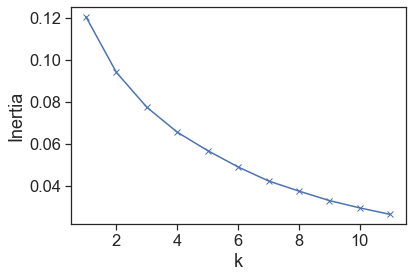

In [150]:
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

We see that the optimal number of clusters is 3 or 4 or 5. After trying with different values, even larger than 5, we decided to choose **--- 7 ---** and the results we obtain are shown below.

In [151]:
# set number of clusters
kclusters = 7

incidents_SF_grouped_clustering_noLarceny = incidents_SF_grouped_noLarceny.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=2000, random_state=0).fit(incidents_SF_grouped_clustering_noLarceny)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 2, 2, 3, 1, 2, 5, 0, 6], dtype=int32)

Let us create a new dataframe that includes the cluster as well as the top 10 incidents/crimes for each neighborhood.

In [152]:
# add clustering labels
neighborhoods_incidents_sorted_noLarceny.insert(0, 'Cluster Labels', kmeans.labels_)

incidents_SF_merged_noLarceny = neighborhoods_SF_coord

incidents_SF_merged_noLarceny = incidents_SF_merged_noLarceny.join(neighborhoods_incidents_sorted_noLarceny.set_index('Neighborhood'), on='Neighborhood', how='right')

incidents_SF_merged_noLarceny.head() # check the last columns!

Neighborhood   Latitude   Longitude  Cluster Labels  \
0          Seacliff  37.784973 -122.501423               4   
1    Outer Richmond  37.777818 -122.492410               4   
2  Golden Gate Park  37.769383 -122.481940               0   
3      Outer Sunset  37.755419 -122.493805               0   
5         Lakeshore  37.721792 -122.485235               4   

  1st Most Common Incident 2nd Most Common Incident 3rd Most Common Incident  \
0             Non-Criminal       Malicious Mischief                 Burglary   
1             Non-Criminal      Other Miscellaneous       Malicious Mischief   
2             Non-Criminal      Other Miscellaneous       Malicious Mischief   
3             Non-Criminal                    Fraud       Malicious Mischief   
5       Malicious Mischief      Other Miscellaneous             Non-Criminal   

  4th Most Common Incident 5th Most Common Incident 6th Most Common Incident  \
0      Motor Vehicle Theft      Other Miscellaneous                    Fraud   
1      Motor Vehicle Theft                    Fraud                 Burglary   
2           Missing Person                  Assault      Motor Vehicle Theft   
3           Missing Person      Motor Vehicle Theft      Other Miscellaneous   
5                  Assault      Motor Vehicle Theft                    Fraud   

  7th Most Common Incident 8th Most Common Incident  \
0        Recovered Vehicle           Suspicious Occ   
1                  Assault        Recovered Vehicle   
2                 Burglary        Recovered Vehicle   
3                 Burglary                  Assault   
5            Lost Property                 Burglary   

                   9th Most Common Incident  \
0                                   Assault   
1                            Suspicious Occ   
2                             Lost Property   
3  Offences Against The Family And Children   
5                        Disorderly Conduct   

                  10th Most Common Incident  
0  Offences Against The Family And Children  
1                             Lost Property  
2                                   Warrant  
3                             Lost Property  
5  Offences Against The Family And Children

In [153]:
incidents_SF_merged_noLarceny.shape

(34, 14)

------------------

### Including "Missing" Neighborhoods

In the dataframe *incidents_SF_merged_noLarceny*, the neighborhoods "Parkside", "Diamond Heights" and "Crocker Amazon" are missing because their data are included into "Outer Sunset", "Glen Park" and "Excelsior", respectively. Here, we include them also by copying the rows for "Outer Sunset", "Glen Park" and "Excelsior" and renaming them into "Parkside", "Diamond Heights" and "Crocker Amazon".

We include the missing neighborhoods as follows

In [154]:
incidents_SF_merged_noLarceny_temp = incidents_SF_merged_noLarceny.set_index(['Neighborhood']).T
incidents_SF_merged_noLarceny_temp

Neighborhood                                               Seacliff  \
Latitude                                                     37.785   
Longitude                                                  -122.501   
Cluster Labels                                                    4   
1st Most Common Incident                               Non-Criminal   
2nd Most Common Incident                         Malicious Mischief   
3rd Most Common Incident                                   Burglary   
4th Most Common Incident                        Motor Vehicle Theft   
5th Most Common Incident                        Other Miscellaneous   
6th Most Common Incident                                      Fraud   
7th Most Common Incident                          Recovered Vehicle   
8th Most Common Incident                             Suspicious Occ   
9th Most Common Incident                                    Assault   
10th Most Common Incident  Offences Against The Family And Children   

Neighborhood                    Outer Richmond     Golden Gate Park  \
Latitude                               37.7778              37.7694   
Longitude                             -122.492             -122.482   
Cluster Labels                               4                    0   
1st Most Common Incident          Non-Criminal         Non-Criminal   
2nd Most Common Incident   Other Miscellaneous  Other Miscellaneous   
3rd Most Common Incident    Malicious Mischief   Malicious Mischief   
4th Most Common Incident   Motor Vehicle Theft       Missing Person   
5th Most Common Incident                 Fraud              Assault   
6th Most Common Incident              Burglary  Motor Vehicle Theft   
7th Most Common Incident               Assault             Burglary   
8th Most Common Incident     Recovered Vehicle    Recovered Vehicle   
9th Most Common Incident        Suspicious Occ        Lost Property   
10th Most Common Incident        Lost Property              Warrant   

Neighborhood                                           Outer Sunset  \
Latitude                                                    37.7554   
Longitude                                                  -122.494   
Cluster Labels                                                    0   
1st Most Common Incident                               Non-Criminal   
2nd Most Common Incident                                      Fraud   
3rd Most Common Incident                         Malicious Mischief   
4th Most Common Incident                             Missing Person   
5th Most Common Incident                        Motor Vehicle Theft   
6th Most Common Incident                        Other Miscellaneous   
7th Most Common Incident                                   Burglary   
8th Most Common Incident                                    Assault   
9th Most Common Incident   Offences Against The Family And Children   
10th Most Common Incident                             Lost Property   

Neighborhood                                              Lakeshore  \
Latitude                                                    37.7218   
Longitude                                                  -122.485   
Cluster Labels                                                    4   
1st Most Common Incident                         Malicious Mischief   
2nd Most Common Incident                        Other Miscellaneous   
3rd Most Common Incident                               Non-Criminal   
4th Most Common Incident                                    Assault   
5th Most Common Incident                        Motor Vehicle Theft   
6th Most Common Incident                                      Fraud   
7th Most Common Incident                              Lost Property   
8th Most Common Incident                                   Burglary   
9th Most Common Incident                         Disorderly Conduct   
10th Most Common Incident  Offences Against The Family And Children   

Neighborhood        

In [155]:
incidents_SF_merged_noLarceny_temp['Crocker Amazon'] = incidents_SF_merged_noLarceny_temp['Excelsior']
incidents_SF_merged_noLarceny_temp['Diamond Heights'] = incidents_SF_merged_noLarceny_temp['Glen Park']
incidents_SF_merged_noLarceny_temp['Parkside'] = incidents_SF_merged_noLarceny_temp['Outer Sunset']

In [156]:
incidents_SF_merged_noLarceny_temp

Neighborhood                                               Seacliff  \
Latitude                                                     37.785   
Longitude                                                  -122.501   
Cluster Labels                                                    4   
1st Most Common Incident                               Non-Criminal   
2nd Most Common Incident                         Malicious Mischief   
3rd Most Common Incident                                   Burglary   
4th Most Common Incident                        Motor Vehicle Theft   
5th Most Common Incident                        Other Miscellaneous   
6th Most Common Incident                                      Fraud   
7th Most Common Incident                          Recovered Vehicle   
8th Most Common Incident                             Suspicious Occ   
9th Most Common Incident                                    Assault   
10th Most Common Incident  Offences Against The Family And Children   

Neighborhood                    Outer Richmond     Golden Gate Park  \
Latitude                               37.7778              37.7694   
Longitude                             -122.492             -122.482   
Cluster Labels                               4                    0   
1st Most Common Incident          Non-Criminal         Non-Criminal   
2nd Most Common Incident   Other Miscellaneous  Other Miscellaneous   
3rd Most Common Incident    Malicious Mischief   Malicious Mischief   
4th Most Common Incident   Motor Vehicle Theft       Missing Person   
5th Most Common Incident                 Fraud              Assault   
6th Most Common Incident              Burglary  Motor Vehicle Theft   
7th Most Common Incident               Assault             Burglary   
8th Most Common Incident     Recovered Vehicle    Recovered Vehicle   
9th Most Common Incident        Suspicious Occ        Lost Property   
10th Most Common Incident        Lost Property              Warrant   

Neighborhood                                           Outer Sunset  \
Latitude                                                    37.7554   
Longitude                                                  -122.494   
Cluster Labels                                                    0   
1st Most Common Incident                               Non-Criminal   
2nd Most Common Incident                                      Fraud   
3rd Most Common Incident                         Malicious Mischief   
4th Most Common Incident                             Missing Person   
5th Most Common Incident                        Motor Vehicle Theft   
6th Most Common Incident                        Other Miscellaneous   
7th Most Common Incident                                   Burglary   
8th Most Common Incident                                    Assault   
9th Most Common Incident   Offences Against The Family And Children   
10th Most Common Incident                             Lost Property   

Neighborhood                                              Lakeshore  \
Latitude                                                    37.7218   
Longitude                                                  -122.485   
Cluster Labels                                                    4   
1st Most Common Incident                         Malicious Mischief   
2nd Most Common Incident                        Other Miscellaneous   
3rd Most Common Incident                               Non-Criminal   
4th Most Common Incident                                    Assault   
5th Most Common Incident                        Motor Vehicle Theft   
6th Most Common Incident                                      Fraud   
7th Most Common Incident                              Lost Property   
8th Most Common Incident                                   Burglary   
9th Most Common Incident                         Disorderly Conduct   
10th Most Common Incident  Offences Against The Family And Children   

Neighborhood        

We finally modify the coordinates of "Parkside", "Diamond Heights" and "Crocker Amazon"

In [157]:
incidents_SF_merged_noLarceny_temp['Crocker Amazon']['Latitude'] = neighborhoods_SF_coord[neighborhoods_SF_coord['Neighborhood']=='Crocker Amazon'].iloc[0,1]
incidents_SF_merged_noLarceny_temp['Diamond Heights']['Latitude'] = neighborhoods_SF_coord[neighborhoods_SF_coord['Neighborhood']=='Diamond Heights'].iloc[0,1]
incidents_SF_merged_noLarceny_temp['Parkside']['Latitude'] = neighborhoods_SF_coord[neighborhoods_SF_coord['Neighborhood']=='Parkside'].iloc[0,1]

In [158]:
incidents_SF_merged_noLarceny_temp['Crocker Amazon']['Longitude'] = neighborhoods_SF_coord[neighborhoods_SF_coord['Neighborhood']=='Crocker Amazon'].iloc[0,2]
incidents_SF_merged_noLarceny_temp['Diamond Heights']['Longitude'] = neighborhoods_SF_coord[neighborhoods_SF_coord['Neighborhood']=='Diamond Heights'].iloc[0,2]
incidents_SF_merged_noLarceny_temp['Parkside']['Longitude'] = neighborhoods_SF_coord[neighborhoods_SF_coord['Neighborhood']=='Parkside'].iloc[0,2]

In [159]:
incidents_SF_merged_noLarceny_all = incidents_SF_merged_noLarceny_temp.T.reset_index()
incidents_SF_merged_noLarceny_all.head()

Neighborhood Latitude Longitude Cluster Labels  \
0          Seacliff   37.785  -122.501              4   
1    Outer Richmond  37.7778  -122.492              4   
2  Golden Gate Park  37.7694  -122.482              0   
3      Outer Sunset  37.7554  -122.494              0   
4         Lakeshore  37.7218  -122.485              4   

  1st Most Common Incident 2nd Most Common Incident 3rd Most Common Incident  \
0             Non-Criminal       Malicious Mischief                 Burglary   
1             Non-Criminal      Other Miscellaneous       Malicious Mischief   
2             Non-Criminal      Other Miscellaneous       Malicious Mischief   
3             Non-Criminal                    Fraud       Malicious Mischief   
4       Malicious Mischief      Other Miscellaneous             Non-Criminal   

  4th Most Common Incident 5th Most Common Incident 6th Most Common Incident  \
0      Motor Vehicle Theft      Other Miscellaneous                    Fraud   
1      Motor Vehicle Theft                    Fraud                 Burglary   
2           Missing Person                  Assault      Motor Vehicle Theft   
3           Missing Person      Motor Vehicle Theft      Other Miscellaneous   
4                  Assault      Motor Vehicle Theft                    Fraud   

  7th Most Common Incident 8th Most Common Incident  \
0        Recovered Vehicle           Suspicious Occ   
1                  Assault        Recovered Vehicle   
2                 Burglary        Recovered Vehicle   
3                 Burglary                  Assault   
4            Lost Property                 Burglary   

                   9th Most Common Incident  \
0                                   Assault   
1                            Suspicious Occ   
2                             Lost Property   
3  Offences Against The Family And Children   
4                        Disorderly Conduct   

                  10th Most Common Incident  
0  Offences Against The Family And Children  
1                             Lost Property  
2                                   Warrant  
3                             Lost Property  
4  Offences Against The Family And Children

In [160]:
incidents_SF_merged_noLarceny_all.shape

(37, 14)

----------

### Clusters re-labelling

In addition, we want to change the number assigned to each cluster in such a way that small numbers are given to the clusters with a high number of elements. This means, for instance, that the number 0 will be assigned to the cluster which has the maximum number of elements. We proceed as follows:

In [161]:
df_new_clusters_names = incidents_SF_merged_noLarceny_all.groupby('Cluster Labels').count()[['Neighborhood']].sort_values(by='Neighborhood',ascending=False).reset_index().reset_index()
df_new_clusters_names

index  Cluster Labels  Neighborhood
0      0               4             9
1      1               1             7
2      2               5             7
3      3               0             6
4      4               2             6
5      5               3             1
6      6               6             1

In [162]:
df_new_clusters_names.rename(columns={'index':'New Cluster Labels'},inplace=True)
df_new_clusters_names.drop(['Neighborhood'],axis=1,inplace=True)
df_new_clusters_names

New Cluster Labels  Cluster Labels
0                   0               4
1                   1               1
2                   2               5
3                   3               0
4                   4               2
5                   5               3
6                   6               6

In [163]:
incidents_SF_merged_noLarceny_all = incidents_SF_merged_noLarceny_all.join(df_new_clusters_names.set_index('Cluster Labels'), on='Cluster Labels', how='left')
incidents_SF_merged_noLarceny_all.head()

Neighborhood Latitude Longitude Cluster Labels  \
0          Seacliff   37.785  -122.501              4   
1    Outer Richmond  37.7778  -122.492              4   
2  Golden Gate Park  37.7694  -122.482              0   
3      Outer Sunset  37.7554  -122.494              0   
4         Lakeshore  37.7218  -122.485              4   

  1st Most Common Incident 2nd Most Common Incident 3rd Most Common Incident  \
0             Non-Criminal       Malicious Mischief                 Burglary   
1             Non-Criminal      Other Miscellaneous       Malicious Mischief   
2             Non-Criminal      Other Miscellaneous       Malicious Mischief   
3             Non-Criminal                    Fraud       Malicious Mischief   
4       Malicious Mischief      Other Miscellaneous             Non-Criminal   

  4th Most Common Incident 5th Most Common Incident 6th Most Common Incident  \
0      Motor Vehicle Theft      Other Miscellaneous                    Fraud   
1      Motor Vehicle Theft                    Fraud                 Burglary   
2           Missing Person                  Assault      Motor Vehicle Theft   
3           Missing Person      Motor Vehicle Theft      Other Miscellaneous   
4                  Assault      Motor Vehicle Theft                    Fraud   

  7th Most Common Incident 8th Most Common Incident  \
0        Recovered Vehicle           Suspicious Occ   
1                  Assault        Recovered Vehicle   
2                 Burglary        Recovered Vehicle   
3                 Burglary                  Assault   
4            Lost Property                 Burglary   

                   9th Most Common Incident  \
0                                   Assault   
1                            Suspicious Occ   
2                             Lost Property   
3  Offences Against The Family And Children   
4                        Disorderly Conduct   

                  10th Most Common Incident  New Cluster Labels  
0  Offences Against The Family And Children                   0  
1                             Lost Property                   0  
2                                   Warrant                   3  
3                             Lost Property                   3  
4  Offences Against The Family And Children                   0

In [164]:
incidents_SF_merged_noLarceny_all['Cluster Labels'] = incidents_SF_merged_noLarceny_all['New Cluster Labels']
incidents_SF_merged_noLarceny_all.head()

Neighborhood Latitude Longitude  Cluster Labels  \
0          Seacliff   37.785  -122.501               0   
1    Outer Richmond  37.7778  -122.492               0   
2  Golden Gate Park  37.7694  -122.482               3   
3      Outer Sunset  37.7554  -122.494               3   
4         Lakeshore  37.7218  -122.485               0   

  1st Most Common Incident 2nd Most Common Incident 3rd Most Common Incident  \
0             Non-Criminal       Malicious Mischief                 Burglary   
1             Non-Criminal      Other Miscellaneous       Malicious Mischief   
2             Non-Criminal      Other Miscellaneous       Malicious Mischief   
3             Non-Criminal                    Fraud       Malicious Mischief   
4       Malicious Mischief      Other Miscellaneous             Non-Criminal   

  4th Most Common Incident 5th Most Common Incident 6th Most Common Incident  \
0      Motor Vehicle Theft      Other Miscellaneous                    Fraud   
1      Motor Vehicle Theft                    Fraud                 Burglary   
2           Missing Person                  Assault      Motor Vehicle Theft   
3           Missing Person      Motor Vehicle Theft      Other Miscellaneous   
4                  Assault      Motor Vehicle Theft                    Fraud   

  7th Most Common Incident 8th Most Common Incident  \
0        Recovered Vehicle           Suspicious Occ   
1                  Assault        Recovered Vehicle   
2                 Burglary        Recovered Vehicle   
3                 Burglary                  Assault   
4            Lost Property                 Burglary   

                   9th Most Common Incident  \
0                                   Assault   
1                            Suspicious Occ   
2                             Lost Property   
3  Offences Against The Family And Children   
4                        Disorderly Conduct   

                  10th Most Common Incident  New Cluster Labels  
0  Offences Against The Family And Children                   0  
1                             Lost Property                   0  
2                                   Warrant                   3  
3                             Lost Property                   3  
4  Offences Against The Family And Children                   0

In [165]:
incidents_SF_merged_noLarceny_all.drop(['New Cluster Labels'],axis=1,inplace=True)
incidents_SF_merged_noLarceny_all.head()

Neighborhood Latitude Longitude  Cluster Labels  \
0          Seacliff   37.785  -122.501               0   
1    Outer Richmond  37.7778  -122.492               0   
2  Golden Gate Park  37.7694  -122.482               3   
3      Outer Sunset  37.7554  -122.494               3   
4         Lakeshore  37.7218  -122.485               0   

  1st Most Common Incident 2nd Most Common Incident 3rd Most Common Incident  \
0             Non-Criminal       Malicious Mischief                 Burglary   
1             Non-Criminal      Other Miscellaneous       Malicious Mischief   
2             Non-Criminal      Other Miscellaneous       Malicious Mischief   
3             Non-Criminal                    Fraud       Malicious Mischief   
4       Malicious Mischief      Other Miscellaneous             Non-Criminal   

  4th Most Common Incident 5th Most Common Incident 6th Most Common Incident  \
0      Motor Vehicle Theft      Other Miscellaneous                    Fraud   
1      Motor Vehicle Theft                    Fraud                 Burglary   
2           Missing Person                  Assault      Motor Vehicle Theft   
3           Missing Person      Motor Vehicle Theft      Other Miscellaneous   
4                  Assault      Motor Vehicle Theft                    Fraud   

  7th Most Common Incident 8th Most Common Incident  \
0        Recovered Vehicle           Suspicious Occ   
1                  Assault        Recovered Vehicle   
2                 Burglary        Recovered Vehicle   
3                 Burglary                  Assault   
4            Lost Property                 Burglary   

                   9th Most Common Incident  \
0                                   Assault   
1                            Suspicious Occ   
2                             Lost Property   
3  Offences Against The Family And Children   
4                        Disorderly Conduct   

                  10th Most Common Incident  
0  Offences Against The Family And Children  
1                             Lost Property  
2                                   Warrant  
3                             Lost Property  
4  Offences Against The Family And Children

----------

Finally, we can visualize the resulting clusters on the San Francisco map below. Click on the circle markers to see a popup with the name of the neighborhood and the cluster number.

In [166]:
# create map
map_SF_incidents_clusters_noLarceny = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighborhood, cluster in zip(incidents_SF_merged_noLarceny_all['Latitude'], incidents_SF_merged_noLarceny_all['Longitude'], incidents_SF_merged_noLarceny_all['Neighborhood'], incidents_SF_merged_noLarceny_all['Cluster Labels']):
    label = folium.Popup(str(neighborhood) + ' - ' + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=['black'],
#         color=rainbow[cluster-1],
#         color=['red','orange','green','blue'],
        fill=True,
        fill_color=rainbow[cluster-1],
#         fill_color=['red','orange','green','blue'],
        fill_opacity=1).add_to(map_SF_incidents_clusters_noLarceny)
       
map_SF_incidents_clusters_noLarceny

We see that the neighborhoods can be grouped into 7 clusters. One of them, __Cluster 0__, is the largest cluster with 9 elements. The smallest clusters are 2 and contain only 1 neighborhood, namely "Downtown-Tenderloin" and "Haight-Ashbury". In the next section, we will analyze more in details the content of each cluster.

------------

## 5.3. Analysis of the Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

## 5.3.1. Top 10 Most Common Incidents per Neighborhood per Cluster

### Cluster 0

In [167]:
incidents_SF_merged_noLarceny_all.loc[incidents_SF_merged_noLarceny_all['Cluster Labels'] == 0, incidents_SF_merged_noLarceny_all.columns[[0] + list(range(3, incidents_SF_merged_noLarceny_all.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Incident  \
0           Seacliff               0             Non-Criminal   
1     Outer Richmond               0             Non-Criminal   
4          Lakeshore               0       Malicious Mischief   
5           Presidio               0             Non-Criminal   
12        Twin-Peaks               0             Non-Criminal   
14            Marina               0                 Burglary   
16  Western Addition               0       Malicious Mischief   
20      Russian Hill               0                 Burglary   
27       North Beach               0       Malicious Mischief   

   2nd Most Common Incident 3rd Most Common Incident 4th Most Common Incident  \
0        Malicious Mischief                 Burglary      Motor Vehicle Theft   
1       Other Miscellaneous       Malicious Mischief      Motor Vehicle Theft   
4       Other Miscellaneous             Non-Criminal                  Assault   
5                     Fraud      Other Miscellaneous                  Assault   
12                 Burglary       Malicious Mischief      Other Miscellaneous   
14       Malicious Mischief             Non-Criminal      Other Miscellaneous   
16      Other Miscellaneous             Non-Criminal                 Burglary   
20      Other Miscellaneous       Malicious Mischief             Non-Criminal   
27      Other Miscellaneous             Non-Criminal                  Assault   

   5th Most Common Incident 6th Most Common Incident 7th Most Common Incident  \
0       Other Miscellaneous                    Fraud        Recovered Vehicle   
1                     Fraud                 Burglary                  Assault   
4       Motor Vehicle Theft                    Fraud            Lost Property   
5        Malicious Mischief                    Other            Lost Property   
12      Motor Vehicle Theft                    Fraud                  Assault   
14                    Fraud                  Assault      Motor Vehicle Theft   
16                  Assault      Motor Vehicle Theft                    Fraud   
20      Motor Vehicle Theft                    Fraud                  Assault   
27            Lost Property                 Burglary                    Fraud   

   8th Most Common Incident 9th Most Common Incident  \
0            Suspicious Occ                  Assault   
1         Recovered Vehicle           Suspicious Occ   
4                  Burglary       Disorderly Conduct   
5            Suspicious Occ                  Warrant   
12       Disorderly Conduct           Suspicious Occ   
14            Lost Property       Disorderly Conduct   
16                  Warrant            Lost Property   
20            Lost Property                  Warrant   
27      Motor Vehicle Theft                  Warrant   

                   10th Most Common Incident  
0   Offences Against The Family And Children  
1                              Lost Property  
4   Offences Against The Family And Children  
5                                   Burglary  
12  Offences Against The Family And Children  
14                                   Robbery  
16                            Missing Person  
20                                   Robbery  
27                                   Robbery

### Cluster 1

In [168]:
incidents_SF_merged_noLarceny_all.loc[incidents_SF_merged_noLarceny_all['Cluster Labels'] == 1, incidents_SF_merged_noLarceny_all.columns[[0] + list(range(3, incidents_SF_merged_noLarceny_all.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Incident  \
9           Oceanview               1             Non-Criminal   
13      Outer Mission               1      Other Miscellaneous   
24     Bernal Heights               1      Other Miscellaneous   
25          Excelsior               1      Other Miscellaneous   
26  Visitacion Valley               1       Malicious Mischief   
32            Bayview               1                  Assault   
34     Crocker Amazon               1      Other Miscellaneous   

   2nd Most Common Incident 3rd Most Common Incident 4th Most Common Incident  \
9        Malicious Mischief      Other Miscellaneous      Motor Vehicle Theft   
13             Non-Criminal       Malicious Mischief      Motor Vehicle Theft   
24       Malicious Mischief      Motor Vehicle Theft                  Assault   
25      Motor Vehicle Theft                  Assault       Malicious Mischief   
26                  Assault      Other Miscellaneous             Non-Criminal   
32      Other Miscellaneous      Motor Vehicle Theft       Malicious Mischief   
34      Motor Vehicle Theft                  Assault       Malicious Mischief   

   5th Most Common Incident                  6th Most Common Incident  \
9                   Assault                                  Burglary   
13                  Assault                                  Burglary   
24             Non-Criminal                                  Burglary   
25             Non-Criminal                                   Robbery   
26      Motor Vehicle Theft  Offences Against The Family And Children   
32        Recovered Vehicle                              Non-Criminal   
34             Non-Criminal                                   Robbery   

   7th Most Common Incident                  8th Most Common Incident  \
9                     Fraud  Offences Against The Family And Children   
13           Missing Person                                   Robbery   
24        Recovered Vehicle                                     Fraud   
25                 Burglary  Offences Against The Family And Children   
26        Recovered Vehicle                                  Burglary   
32                 Burglary  Offences Against The Family And Children   
34                 Burglary  Offences Against The Family And Children   

                    9th Most Common Incident 10th Most Common Incident  
9                             Missing Person         Recovered Vehicle  
13                                     Fraud         Recovered Vehicle  
24  Offences Against The Family And Children                   Robbery  
25                         Recovered Vehicle                     Fraud  
26                                   Robbery            Missing Person  
32                                   Warrant                   Robbery  
34                         Recovered Vehicle                     Fraud

### Cluster 2

In [169]:
incidents_SF_merged_noLarceny_all.loc[incidents_SF_merged_noLarceny_all['Cluster Labels'] == 2, incidents_SF_merged_noLarceny_all.columns[[0] + list(range(3, incidents_SF_merged_noLarceny_all.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Incident  \
8   West of Twin Peaks               2                 Burglary   
10    Presidio Heights               2                 Burglary   
15     Pacific Heights               2                 Burglary   
18          Noe Valley               2                 Burglary   
19           Glen Park               2                 Burglary   
31        Potrero Hill               2       Malicious Mischief   
35     Diamond Heights               2                 Burglary   

   2nd Most Common Incident 3rd Most Common Incident 4th Most Common Incident  \
8       Other Miscellaneous       Malicious Mischief             Non-Criminal   
10       Malicious Mischief             Non-Criminal      Other Miscellaneous   
15       Malicious Mischief             Non-Criminal      Motor Vehicle Theft   
18      Motor Vehicle Theft       Malicious Mischief             Non-Criminal   
19             Non-Criminal       Malicious Mischief      Motor Vehicle Theft   
31                 Burglary      Motor Vehicle Theft      Other Miscellaneous   
35             Non-Criminal       Malicious Mischief      Motor Vehicle Theft   

   5th Most Common Incident 6th Most Common Incident 7th Most Common Incident  \
8       Motor Vehicle Theft                    Fraud                  Assault   
10      Motor Vehicle Theft                    Fraud           Suspicious Occ   
15      Other Miscellaneous                    Fraud                  Assault   
18      Other Miscellaneous                    Fraud        Recovered Vehicle   
19      Other Miscellaneous                  Assault        Recovered Vehicle   
31                  Assault             Non-Criminal        Recovered Vehicle   
35      Other Miscellaneous                  Assault        Recovered Vehicle   

   8th Most Common Incident 9th Most Common Incident  \
8         Recovered Vehicle           Missing Person   
10                  Assault            Lost Property   
15            Lost Property           Suspicious Occ   
18                  Assault           Suspicious Occ   
19                    Fraud           Suspicious Occ   
31                  Warrant                    Fraud   
35                    Fraud           Suspicious Occ   

                   10th Most Common Incident  
8                              Lost Property  
10                            Missing Person  
15                         Recovered Vehicle  
18                             Lost Property  
19  Offences Against The Family And Children  
31  Offences Against The Family And Children  
35  Offences Against The Family And Children

### Cluster 3

In [170]:
incidents_SF_merged_noLarceny_all.loc[incidents_SF_merged_noLarceny_all['Cluster Labels'] == 3, incidents_SF_merged_noLarceny_all.columns[[0] + list(range(3, incidents_SF_merged_noLarceny_all.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Incident  \
2   Golden Gate Park               3             Non-Criminal   
3       Outer Sunset               3             Non-Criminal   
6     Inner Richmond               3             Non-Criminal   
7       Inner Sunset               3       Malicious Mischief   
33   Treasure Island               3                  Assault   
36          Parkside               3             Non-Criminal   

   2nd Most Common Incident 3rd Most Common Incident 4th Most Common Incident  \
2       Other Miscellaneous       Malicious Mischief           Missing Person   
3                     Fraud       Malicious Mischief           Missing Person   
6       Other Miscellaneous       Malicious Mischief                 Burglary   
7              Non-Criminal                 Burglary           Missing Person   
33                 Burglary       Malicious Mischief             Non-Criminal   
36                    Fraud       Malicious Mischief           Missing Person   

   5th Most Common Incident 6th Most Common Incident 7th Most Common Incident  \
2                   Assault      Motor Vehicle Theft                 Burglary   
3       Motor Vehicle Theft      Other Miscellaneous                 Burglary   
6            Missing Person      Motor Vehicle Theft                  Assault   
7       Motor Vehicle Theft      Other Miscellaneous                    Fraud   
33           Missing Person      Other Miscellaneous      Motor Vehicle Theft   
36      Motor Vehicle Theft      Other Miscellaneous                 Burglary   

   8th Most Common Incident                  9th Most Common Incident  \
2         Recovered Vehicle                             Lost Property   
3                   Assault  Offences Against The Family And Children   
6                     Fraud                             Lost Property   
7                   Assault                             Lost Property   
33           Suspicious Occ                        Disorderly Conduct   
36                  Assault  Offences Against The Family And Children   

   10th Most Common Incident  
2                    Warrant  
3              Lost Property  
6             Suspicious Occ  
7          Recovered Vehicle  
33             Lost Property  
36             Lost Property

### Cluster 4 

In [171]:
incidents_SF_merged_noLarceny_all.loc[incidents_SF_merged_noLarceny_all['Cluster Labels'] == 4, incidents_SF_merged_noLarceny_all.columns[[0] + list(range(3, incidents_SF_merged_noLarceny_all.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Incident  \
17  Castro-Upper Market               4      Other Miscellaneous   
21             Nob Hill               4      Other Miscellaneous   
23              Mission               4      Other Miscellaneous   
28            Chinatown               4             Non-Criminal   
29   Financial District               4      Other Miscellaneous   
30      South of Market               4      Other Miscellaneous   

   2nd Most Common Incident 3rd Most Common Incident 4th Most Common Incident  \
17                  Assault       Malicious Mischief             Non-Criminal   
21       Malicious Mischief                 Burglary             Non-Criminal   
23                  Assault             Non-Criminal       Malicious Mischief   
28      Other Miscellaneous            Lost Property       Malicious Mischief   
29                 Burglary       Malicious Mischief                  Assault   
30             Non-Criminal                  Assault       Malicious Mischief   

   5th Most Common Incident 6th Most Common Incident 7th Most Common Incident  \
17                 Burglary                  Warrant      Motor Vehicle Theft   
21                  Assault      Motor Vehicle Theft            Lost Property   
23                  Warrant      Motor Vehicle Theft                 Burglary   
28                  Assault                 Burglary                    Fraud   
29            Lost Property             Non-Criminal                    Fraud   
30                  Warrant                 Burglary             Drug Offense   

   8th Most Common Incident 9th Most Common Incident 10th Most Common Incident  
17            Lost Property                    Fraud           Civil Sidewalks  
21                    Fraud                  Warrant                   Robbery  
23             Drug Offense                  Robbery             Lost Property  
28          Courtesy Report           Suspicious Occ            Missing Person  
29                  Robbery                  Warrant       Motor Vehicle Theft  
30                    Fraud      Motor Vehicle Theft            Missing Person

### Cluster 5 

In [172]:
incidents_SF_merged_noLarceny_all.loc[incidents_SF_merged_noLarceny_all['Cluster Labels'] == 5, incidents_SF_merged_noLarceny_all.columns[[0] + list(range(3, incidents_SF_merged_noLarceny_all.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Incident  \
22  Downtown-Tenderloin               5             Drug Offense   

   2nd Most Common Incident 3rd Most Common Incident 4th Most Common Incident  \
22      Other Miscellaneous                  Assault             Non-Criminal   

   5th Most Common Incident 6th Most Common Incident 7th Most Common Incident  \
22                  Warrant       Malicious Mischief            Lost Property   

   8th Most Common Incident 9th Most Common Incident  \
22                  Robbery                 Burglary   

                   10th Most Common Incident  
22  Offences Against The Family And Children

### Cluster 6

In [173]:
incidents_SF_merged_noLarceny_all.loc[incidents_SF_merged_noLarceny_all['Cluster Labels'] == 6, incidents_SF_merged_noLarceny_all.columns[[0] + list(range(3, incidents_SF_merged_noLarceny_all.shape[1]))]]

Neighborhood  Cluster Labels 1st Most Common Incident  \
11  Haight-Ashbury               6          Civil Sidewalks   

   2nd Most Common Incident 3rd Most Common Incident 4th Most Common Incident  \
11             Non-Criminal      Other Miscellaneous       Malicious Mischief   

   5th Most Common Incident 6th Most Common Incident 7th Most Common Incident  \
11                 Burglary      Motor Vehicle Theft                  Assault   

   8th Most Common Incident 9th Most Common Incident 10th Most Common Incident  
11                  Warrant           Missing Person              Drug Offense

---------------

### Discussion

From this first analysis, we can say that in __Cluster 0__, the largest, the dominant categories seem to be "Non-criminal", "Malicious Mischief" and "Other Miscellaneous". On the othere hand, __Cluster 1__ and __Cluster 4__ contain mainly those neighborhoods where is likely to have "Other Miscellaneous" incidents. In addition, "Barglary" is clearly the main incidents category in __Cluster 2__ whereas __Cluster 3__ seems to be a "Non-Criminal" cluster (except for "Tresure Island" neighborhood). Finally, __Cluster 5__ and __Cluster 6__ have only 1 neighborhood each namely "Downtown-Tenderloin" and "Haight-Ashbury", respectively. The former is characterized by "Drug Offense" incidents, the latter by incidents mostly in the "Civil Sidewalks" category. We explore the description of these two categories below:

In [174]:
incidents_SF[incidents_SF['Incident Category']=='Drug Offense'].head(10)

Incident Category Incident Subcategory  \
10       Drug Offense       Drug Violation   
48       Drug Offense       Drug Violation   
94       Drug Offense       Drug Violation   
105      Drug Offense       Drug Violation   
131      Drug Offense       Drug Violation   
145      Drug Offense       Drug Violation   
211      Drug Offense       Drug Violation   
216      Drug Offense       Drug Violation   
256      Drug Offense       Drug Violation   
274      Drug Offense       Drug Violation   

                          Incident Description Analysis Neighborhood  \
10                     Methamphetamine Offense   Castro/Upper Market   
48              Marijuana, Possession For Sale       South of Market   
94   Controlled Substance, Possession For Sale            Tenderloin   
105                       Hallucinogenic, Sale        Haight Ashbury   
131    Cocaine, Base/rock, Possession For Sale       South of Market   
145                              Heroin, Sales       South of Market   
211                Heroin, Possession For Sale               Mission   
216     Narcotics Paraphernalia, Possession of               Mission   
256                    Methamphetamine Offense             Excelsior   
274                            Opiates Offense   Castro/Upper Market   

      Latitude   Longitude  
10   37.767735 -122.428657  
48   37.783288 -122.408952  
94   37.781863 -122.413866  
105  37.769798 -122.448579  
131  37.780006 -122.411933  
145  37.779212 -122.410937  
211  37.765606 -122.410487  
216  37.763376 -122.420433  
256  37.723130 -122.435977  
274  37.767662 -122.430081

In [175]:
incidents_SF[incidents_SF['Incident Category']=='Civil Sidewalks'].head(10)

Incident Category Incident Subcategory        Incident Description  \
721    Civil Sidewalks                Other   Civil Sidewalks, Citation   
747    Civil Sidewalks                Other   Civil Sidewalks, Citation   
2036   Civil Sidewalks                Other  Civil Sidewalks, Violation   
2177   Civil Sidewalks                Other   Civil Sidewalks, Citation   
4940   Civil Sidewalks                Other   Civil Sidewalks, Citation   
5017   Civil Sidewalks                Other   Civil Sidewalks, Citation   
5899   Civil Sidewalks                Other    Civil Sidewalks, Booking   
7005   Civil Sidewalks                Other    Civil Sidewalks, Booking   
8479   Civil Sidewalks                Other    Civil Sidewalks, Warning   
8689   Civil Sidewalks                Other    Civil Sidewalks, Warning   

               Analysis Neighborhood   Latitude   Longitude  
721                   Haight Ashbury  37.768865 -122.448390  
747                   Haight Ashbury  37.770008 -122.446934  
2036                     North Beach  37.807979 -122.417716  
2177  Financial District/South Beach  37.784205 -122.392119  
4940                  Haight Ashbury  37.770008 -122.446934  
5017                         Mission  37.761902 -122.418271  
5899                  Haight Ashbury  37.769526 -122.450710  
7005             Castro/Upper Market  37.767662 -122.430081  
8479                        Nob Hill  37.790390 -122.410523  
8689                  Haight Ashbury  37.767518 -122.451487

From the "Incident Description" attribute, we see that in the "Drug Offense" category there are all those incidents related to drugs like possession and/or sale of Cocaine and Heroin. On the other hand, it is not really clear the meaning of "Civil Sidewalks". As a result of a careful search on internet, we found that this category refers to those incidents related to non-authorized occupation of sidewalks. Apparently, this involves mainly homeless people living on the sidewalks of "Haight-Ashbury" neighborhood. There has been a discussion about this kind of incident as reported in the article ["The Sidewalks of San Francisco"](https://www.city-journal.org/html/sidewalks-san-francisco-13321.html).

Let us have a look at the descriptions of "Non-Criminal" and "Other Miscellaneous" as well:

In [176]:
incidents_SF[incidents_SF['Incident Category']=='Non-Criminal'].head(10)

Incident Category Incident Subcategory  \
1       Non-Criminal                Other   
8       Non-Criminal         Non-Criminal   
13      Non-Criminal         Non-Criminal   
17      Non-Criminal         Non-Criminal   
21      Non-Criminal         Non-Criminal   
42      Non-Criminal         Non-Criminal   
65      Non-Criminal         Non-Criminal   
70      Non-Criminal         Non-Criminal   
77      Non-Criminal                Other   
89      Non-Criminal         Non-Criminal   

                        Incident Description  Analysis Neighborhood  \
1                    Mental Health Detention        South of Market   
8                     Search Warrant Service       Western Addition   
13                           Found  Property           Russian Hill   
17                           Found  Property               Nob Hill   
21                           Found  Property  Bayview Hunters Point   
42                           Found  Property        Sunset/Parkside   
65                    Search Warrant Service            Mission Bay   
70  Stay Away or Court Order, Non-DV Related           Inner Sunset   
77                   Mental Health Detention                Mission   
89  Stay Away or Court Order, Non-DV Related             Tenderloin   

     Latitude   Longitude  
1   37.780535 -122.408161  
8   37.780802 -122.437260  
13  37.801481 -122.416133  
17  37.790973 -122.417391  
21  37.729910 -122.397177  
42  37.729770 -122.497160  
65  37.772831 -122.391374  
70  37.764366 -122.458815  
77  37.752373 -122.416266  
89  37.786359 -122.419833

In [177]:
incidents_SF[incidents_SF['Incident Category']=='Other Miscellaneous'].head(10)

Incident Category Incident Subcategory  \
7    Other Miscellaneous                Other   
29   Other Miscellaneous                Other   
41   Other Miscellaneous                Other   
43   Other Miscellaneous                Other   
50   Other Miscellaneous                Other   
106  Other Miscellaneous                Other   
107  Other Miscellaneous                Other   
109  Other Miscellaneous                Other   
114  Other Miscellaneous                Other   
121  Other Miscellaneous                Other   

                                  Incident Description  \
7                              Investigative Detention   
29                       Burglary Tools, Possession Of   
41                             Investigative Detention   
43               Driving, License Suspended or Revoked   
50   Resisting, Delaying, or Obstructing  Peace Off...   
106                                  Driving, Reckless   
107                            Investigative Detention   
109                        State Code Felony (general)   
114       Driving While Under The Influence Of Alcohol   
121                            Investigative Detention   

              Analysis Neighborhood   Latitude   Longitude  
7                   South of Market  37.780006 -122.411933  
29   Financial District/South Beach  37.798881 -122.398696  
41                     Hayes Valley  37.774551 -122.422502  
43                  Pacific Heights  37.790160 -122.423975  
50                          Mission  37.770630 -122.412480  
106                  Inner Richmond  37.780822 -122.468564  
107                         Mission  37.773523 -122.421232  
109                       Excelsior  37.724005 -122.435313  
114                  Bernal Heights  37.746941 -122.410619  
121                         Mission  37.763496 -122.418484

From the last two tables, we see that the incidents reported in the categories "Non-Criminal" and "Other Miscellaneous" are both rather miscellaneous. A more careful analysis of these two categories is needed for an improved neighborhoods clustering, but this is out of the scope of this project.

----------

## 5.3.2. Total Incidents per Category per Cluster

In order to have a better understanding of the most common incidents in each cluster, we consider here the total number of incidents grouped per category in each cluster. This analysis will help us to decide the name/label to give to a cluster.

We start from the dataframe *incidents_SF_onehot* containing the One Hot Encoding, then we group by clusters and sum over the categories as follows.

In [178]:
incidents_SF_onehot.head()

Neighborhood  Arson  Assault  Burglary  Case Closure  Civil Sidewalks  \
0     Outer Sunset      0        0         0             0                0   
1  South of Market      0        0         0             0                0   
2          Bayview      0        0         0             0                0   
3        Chinatown      0        0         0             0                0   
4           Marina      0        1         0             0                0   

   Courtesy Report  Disorderly Conduct  Drug Offense  Drug Violation  \
0                0                   0             0               0   
1                0                   0             0               0   
2                0                   0             0               0   
3                0                   0             0               0   
4                0                   0             0               0   

   Embezzlement  Family Offense  Fire Report  Forgery And Counterfeiting  \
0             0               0            0                           0   
1             0               0            0                           0   
2             0               0            0                           0   
3             0               0            0                           0   
4             0               0            0                           0   

   Fraud  Gambling  Homicide  Human Trafficking (A), Commercial Sex Acts  \
0      0         0         0                                           0   
1      0         0         0                                           0   
2      0         0         0                                           0   
3      0         0         0                                           0   
4      0         0         0                                           0   

   Human Trafficking (B), Involuntary Servitude  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   Human Trafficking, Commercial Sex Acts  Juvenile Offenses  Larceny Theft  \
0                                       0                  0              0   
1                                       0                  0              0   
2                                       0                  0              0   
3                                       0                  0              0   
4                                       0                  0              0   

   Liquor Laws  Lost Property  Malicious Mischief  \
0            0              0                   0   
1            0              0                   0   
2            0              0                   0   
3            0              0                   0   
4            0              0                   0   

   Miscellaneous Investigation  Missing Person  Motor Vehicle Theft  \
0                            0               0                    0   
1                            0               0                    0   
2                            0               1                    0   
3                            0               0                    0   
4                            0               0                    0   

   Motor Vehicle Theft?  Non-Criminal  \
0                     0             0   
1                     0             1   
2                     0             0   
3                     0             0   
4                     0             0   

   Offences Against The Family And Children  Other  Other Miscellaneous  \
0                                         1      0                    0   
1                                         0      0                    0   
2                                         0      0                    0   
3                                         1      0                    0   
4                                 

In [179]:
incidents_SF_onehot.shape

(344986, 52)

We remove the "Larceny Theft" category

In [180]:
incidents_SF_onehot_noLarceny = incidents_SF_onehot.drop(['Larceny Theft'],axis=1)
incidents_SF_onehot_noLarceny.head()

Neighborhood  Arson  Assault  Burglary  Case Closure  Civil Sidewalks  \
0     Outer Sunset      0        0         0             0                0   
1  South of Market      0        0         0             0                0   
2          Bayview      0        0         0             0                0   
3        Chinatown      0        0         0             0                0   
4           Marina      0        1         0             0                0   

   Courtesy Report  Disorderly Conduct  Drug Offense  Drug Violation  \
0                0                   0             0               0   
1                0                   0             0               0   
2                0                   0             0               0   
3                0                   0             0               0   
4                0                   0             0               0   

   Embezzlement  Family Offense  Fire Report  Forgery And Counterfeiting  \
0             0               0            0                           0   
1             0               0            0                           0   
2             0               0            0                           0   
3             0               0            0                           0   
4             0               0            0                           0   

   Fraud  Gambling  Homicide  Human Trafficking (A), Commercial Sex Acts  \
0      0         0         0                                           0   
1      0         0         0                                           0   
2      0         0         0                                           0   
3      0         0         0                                           0   
4      0         0         0                                           0   

   Human Trafficking (B), Involuntary Servitude  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   Human Trafficking, Commercial Sex Acts  Juvenile Offenses  Liquor Laws  \
0                                       0                  0            0   
1                                       0                  0            0   
2                                       0                  0            0   
3                                       0                  0            0   
4                                       0                  0            0   

   Lost Property  Malicious Mischief  Miscellaneous Investigation  \
0              0                   0                            0   
1              0                   0                            0   
2              0                   0                            0   
3              0                   0                            0   
4              0                   0                            0   

   Missing Person  Motor Vehicle Theft  Motor Vehicle Theft?  Non-Criminal  \
0               0                    0                     0             0   
1               0                    0                     0             1   
2               1                    0                     0             0   
3               0                    0                     0             0   
4               0                    0                     0             0   

   Offences Against The Family And Children  Other  Other Miscellaneous  \
0                                         1      0                    0   
1                                         0      0                    0   
2                                         0      0                    0   
3                                         1      0                    0   
4                                         0      0                    0   

   Other Offenses  Prostitution  Rape  Recovered Vehicle  Robbery  \
0         

In [181]:
incidents_SF_onehot_noLarceny.shape

(344986, 51)

In [182]:
incidents_SF_merged_noLarceny_tot = incidents_SF_onehot_noLarceny.groupby('Neighborhood').sum()
incidents_SF_merged_noLarceny_tot.head()

Arson  Assault  Burglary  Case Closure  Civil Sidewalks  \
Neighborhood                                                                   
Bayview              113.0   1944.0     880.0          56.0              0.0   
Bernal Heights        16.0    414.0     384.0           7.0              0.0   
Castro-Upper Market   36.0    765.0     638.0          44.0            226.0   
Chinatown             34.0    383.0     320.0          28.0              0.0   
Downtown-Tenderloin   80.0   3097.0     907.0          68.0             10.0   

                     Courtesy Report  Disorderly Conduct  Drug Offense  \
Neighborhood                                                             
Bayview                         69.0               585.0         205.0   
Bernal Heights                   5.0               122.0          68.0   
Castro-Upper Market              7.0               210.0         189.0   
Chinatown                      231.0               115.0          73.0   
Downtown-Tenderloin             94.0               587.0        4071.0   

                     Drug Violation  Embezzlement  Family Offense  \
Neighborhood                                                        
Bayview                        11.0          60.0            99.0   
Bernal Heights                  4.0           6.0             8.0   
Castro-Upper Market             1.0           7.0            11.0   
Chinatown                       1.0           8.0             6.0   
Downtown-Tenderloin            34.0          70.0            31.0   

                     Fire Report  Forgery And Counterfeiting  Fraud  Gambling  \
Neighborhood                                                                    
Bayview                     70.0                        78.0  475.0       2.0   
Bernal Heights               7.0                        25.0  182.0       1.0   
Castro-Upper Market         10.0                        40.0  319.0       0.0   
Chinatown                    2.0                        50.0  253.0       0.0   
Downtown-Tenderloin         17.0                       146.0  686.0       1.0   

                     Homicide  Human Trafficking (A), Commercial Sex Acts  \
Neighborhood                                                                
Bayview                   4.0                                         3.0   
Bernal Heights            1.0                                         0.0   
Castro-Upper Market       0.0                                         0.0   
Chinatown                 0.0                                         0.0   
Downtown-Tenderloin       9.0                                         3.0   

                     Human Trafficking (B), Involuntary Servitude  \
Neighborhood                                                        
Bayview                                                       0.0   
Bernal Heights                                                0.0   
Castro-Upper Market                                           0.0   
Chinatown                                                     0.0   
Downtown-Tenderloin                                           0.0   

                     Human Trafficking, Commercial Sex Acts  \
Neighborhood                                                  
Bayview                                                 0.0   
Bernal Heights                                          1.0   
Castro-Upper Market                                     0.0   
Chinatown                                               0.0   
Downtown-Tenderloin                                     1.0   

                     Juvenile Offenses  Liquor Laws  Lost Property  \
Neighborhood                                                         
Bayview                            0.0          2.0          319.0   
Bernal Heights                     0.0          1.0          111.0   
Castro-Upper Market                0.0          4.0          387.0   
Chinatown                          0.0          1.0          452.0   
Dow

In [183]:
incidents_SF_merged_noLarceny_tot.shape

(34, 50)

In [184]:
incidents_SF_merged_noLarceny_tot.reset_index(inplace=True)

In [185]:
incidents_SF_merged_noLarceny_tot.shape

(34, 51)

In [186]:
incidents_SF_merged_noLarceny_clusters = incidents_SF_merged_noLarceny[['Neighborhood', 'Cluster Labels']]
incidents_SF_merged_noLarceny_clusters

Neighborhood  Cluster Labels
0              Seacliff               4
1        Outer Richmond               4
2      Golden Gate Park               0
3          Outer Sunset               0
5             Lakeshore               4
6              Presidio               4
7        Inner Richmond               0
8          Inner Sunset               0
9    West of Twin Peaks               5
10            Oceanview               1
11     Presidio Heights               5
12       Haight-Ashbury               6
13           Twin-Peaks               4
14        Outer Mission               1
16               Marina               4
17      Pacific Heights               5
18     Western Addition               4
19  Castro-Upper Market               2
20           Noe Valley               5
22            Glen Park               5
23         Russian Hill               4
24             Nob Hill               2
25  Downtown-Tenderloin               3
26              Mission               2
27       Bernal Heights               1
28            Excelsior               1
29    Visitacion Valley               1
30          North Beach               4
31            Chinatown               2
32   Financial District               2
33      South of Market               2
34         Potrero Hill               5
35              Bayview               1
36      Treasure Island               0

In [187]:
incidents_SF_merged_noLarceny_clusters.shape

(34, 2)

In [188]:
incidents_SF_merged_noLarceny_tot_clusters = incidents_SF_merged_noLarceny_clusters.join(incidents_SF_merged_noLarceny_tot.set_index('Neighborhood'), on='Neighborhood', how='left')

incidents_SF_merged_noLarceny_tot_clusters.head()

Neighborhood  Cluster Labels  Arson  Assault  Burglary  Case Closure  \
0          Seacliff               4    0.0     15.0      37.0           3.0   
1    Outer Richmond               4   11.0    290.0     315.0          29.0   
2  Golden Gate Park               0   21.0    140.0     104.0          31.0   
3      Outer Sunset               0   23.0    470.0     497.0          32.0   
5         Lakeshore               4    7.0    204.0     128.0          17.0   

   Civil Sidewalks  Courtesy Report  Disorderly Conduct  Drug Offense  \
0              0.0              1.0                 3.0           6.0   
1              5.0             14.0               140.0          64.0   
2              9.0             12.0                25.0          69.0   
3              0.0             57.0               223.0          67.0   
5              0.0              8.0                94.0          18.0   

   Drug Violation  Embezzlement  Family Offense  Fire Report  \
0             0.0           0.0             1.0          0.0   
1             0.0           6.0            11.0         12.0   
2             0.0           2.0             5.0          8.0   
3             1.0           8.0            27.0         12.0   
5             0.0          13.0             9.0          3.0   

   Forgery And Counterfeiting  Fraud  Gambling  Homicide  \
0                         2.0   23.0       0.0       0.0   
1                        33.0  332.0       0.0       1.0   
2                        13.0   73.0       0.0       0.0   
3                        52.0  647.0       0.0       1.0   
5                        21.0  197.0       0.0       1.0   

   Human Trafficking (A), Commercial Sex Acts  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                        18.0   
5                                         1.0   

   Human Trafficking (B), Involuntary Servitude  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
5                                           0.0   

   Human Trafficking, Commercial Sex Acts  Juvenile Offenses  Liquor Laws  \
0                                     0.0                0.0          0.0   
1                                     0.0                0.0          1.0   
2                                     0.0                0.0          0.0   
3                                     0.0                0.0          2.0   
5                                     0.0                0.0          1.0   

   Lost Property  Malicious Mischief  Miscellaneous Investigation  \
0            9.0                57.0                          1.0   
1          170.0               457.0                         72.0   
2           81.0               232.0                         22.0   
3          315.0               644.0                        197.0   
5          134.0               262.0                         50.0   

   Missing Person  Motor Vehicle Theft  Motor Vehicle Theft?  Non-Criminal  \
0             8.0                 37.0                   0.0          63.0   
1           165.0                396.0                   1.0         499.0   
2           209.0                130.0                   2.0         279.0   
3           635.0                553.0                   4.0         896.0   
5            66.0                201.0                   1.0         212.0   

   Offences Against The Family And Children  Other  Other Miscellaneous  \
0                                      11.0    5.0                 28.0   
1                                     155.0   54.0                494.0   
2                                      45.0   25.0                252.0   
3                                     348.0   81.0                546.0   
5                      

In [189]:
incidents_SF_merged_noLarceny_tot_clusters.shape

(34, 52)

In [190]:
incidents_SF_merged_noLarceny_tot_clusters_only = incidents_SF_merged_noLarceny_tot_clusters.drop(['Neighborhood'],axis=1)
incidents_SF_merged_noLarceny_tot_clusters_only.head()

Cluster Labels  Arson  Assault  Burglary  Case Closure  Civil Sidewalks  \
0               4    0.0     15.0      37.0           3.0              0.0   
1               4   11.0    290.0     315.0          29.0              5.0   
2               0   21.0    140.0     104.0          31.0              9.0   
3               0   23.0    470.0     497.0          32.0              0.0   
5               4    7.0    204.0     128.0          17.0              0.0   

   Courtesy Report  Disorderly Conduct  Drug Offense  Drug Violation  \
0              1.0                 3.0           6.0             0.0   
1             14.0               140.0          64.0             0.0   
2             12.0                25.0          69.0             0.0   
3             57.0               223.0          67.0             1.0   
5              8.0                94.0          18.0             0.0   

   Embezzlement  Family Offense  Fire Report  Forgery And Counterfeiting  \
0           0.0             1.0          0.0                         2.0   
1           6.0            11.0         12.0                        33.0   
2           2.0             5.0          8.0                        13.0   
3           8.0            27.0         12.0                        52.0   
5          13.0             9.0          3.0                        21.0   

   Fraud  Gambling  Homicide  Human Trafficking (A), Commercial Sex Acts  \
0   23.0       0.0       0.0                                         0.0   
1  332.0       0.0       1.0                                         0.0   
2   73.0       0.0       0.0                                         0.0   
3  647.0       0.0       1.0                                        18.0   
5  197.0       0.0       1.0                                         1.0   

   Human Trafficking (B), Involuntary Servitude  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
5                                           0.0   

   Human Trafficking, Commercial Sex Acts  Juvenile Offenses  Liquor Laws  \
0                                     0.0                0.0          0.0   
1                                     0.0                0.0          1.0   
2                                     0.0                0.0          0.0   
3                                     0.0                0.0          2.0   
5                                     0.0                0.0          1.0   

   Lost Property  Malicious Mischief  Miscellaneous Investigation  \
0            9.0                57.0                          1.0   
1          170.0               457.0                         72.0   
2           81.0               232.0                         22.0   
3          315.0               644.0                        197.0   
5          134.0               262.0                         50.0   

   Missing Person  Motor Vehicle Theft  Motor Vehicle Theft?  Non-Criminal  \
0             8.0                 37.0                   0.0          63.0   
1           165.0                396.0                   1.0         499.0   
2           209.0                130.0                   2.0         279.0   
3           635.0                553.0                   4.0         896.0   
5            66.0                201.0                   1.0         212.0   

   Offences Against The Family And Children  Other  Other Miscellaneous  \
0                                      11.0    5.0                 28.0   
1                                     155.0   54.0                494.0   
2                                      45.0   25.0                252.0   
3                                     348.0   81.0                546.0   
5                                      83.0   25.0                237.0   

   Other Offenses  Prostitution  Rape  Recovered Vehicle  Robbery  \
0            

-------------

### Clusters re-labelling

In addition, we want to change the number assigned to each cluster in such a way that small numbers are given to the clusters with a high number of elements. This means, for instance, that the number 0 will be assigned to the cluster which has the maximum number of elements. We proceed as follows:

In [191]:
incidents_SF_merged_noLarceny_tot_clusters_only = incidents_SF_merged_noLarceny_tot_clusters_only.join(df_new_clusters_names.set_index('Cluster Labels'), on='Cluster Labels', how='left')
incidents_SF_merged_noLarceny_tot_clusters_only.head()

Cluster Labels  Arson  Assault  Burglary  Case Closure  Civil Sidewalks  \
0               4    0.0     15.0      37.0           3.0              0.0   
1               4   11.0    290.0     315.0          29.0              5.0   
2               0   21.0    140.0     104.0          31.0              9.0   
3               0   23.0    470.0     497.0          32.0              0.0   
5               4    7.0    204.0     128.0          17.0              0.0   

   Courtesy Report  Disorderly Conduct  Drug Offense  Drug Violation  \
0              1.0                 3.0           6.0             0.0   
1             14.0               140.0          64.0             0.0   
2             12.0                25.0          69.0             0.0   
3             57.0               223.0          67.0             1.0   
5              8.0                94.0          18.0             0.0   

   Embezzlement  Family Offense  Fire Report  Forgery And Counterfeiting  \
0           0.0             1.0          0.0                         2.0   
1           6.0            11.0         12.0                        33.0   
2           2.0             5.0          8.0                        13.0   
3           8.0            27.0         12.0                        52.0   
5          13.0             9.0          3.0                        21.0   

   Fraud  Gambling  Homicide  Human Trafficking (A), Commercial Sex Acts  \
0   23.0       0.0       0.0                                         0.0   
1  332.0       0.0       1.0                                         0.0   
2   73.0       0.0       0.0                                         0.0   
3  647.0       0.0       1.0                                        18.0   
5  197.0       0.0       1.0                                         1.0   

   Human Trafficking (B), Involuntary Servitude  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
5                                           0.0   

   Human Trafficking, Commercial Sex Acts  Juvenile Offenses  Liquor Laws  \
0                                     0.0                0.0          0.0   
1                                     0.0                0.0          1.0   
2                                     0.0                0.0          0.0   
3                                     0.0                0.0          2.0   
5                                     0.0                0.0          1.0   

   Lost Property  Malicious Mischief  Miscellaneous Investigation  \
0            9.0                57.0                          1.0   
1          170.0               457.0                         72.0   
2           81.0               232.0                         22.0   
3          315.0               644.0                        197.0   
5          134.0               262.0                         50.0   

   Missing Person  Motor Vehicle Theft  Motor Vehicle Theft?  Non-Criminal  \
0             8.0                 37.0                   0.0          63.0   
1           165.0                396.0                   1.0         499.0   
2           209.0                130.0                   2.0         279.0   
3           635.0                553.0                   4.0         896.0   
5            66.0                201.0                   1.0         212.0   

   Offences Against The Family And Children  Other  Other Miscellaneous  \
0                                      11.0    5.0                 28.0   
1                                     155.0   54.0                494.0   
2                                      45.0   25.0                252.0   
3                                     348.0   81.0                546.0   
5                                      83.0   25.0                237.0   

   Other Offenses  Prostitution  Rape  Recovered Vehicle  Robbery  \
0            

In [192]:
incidents_SF_merged_noLarceny_tot_clusters_only['Cluster Labels'] = incidents_SF_merged_noLarceny_tot_clusters_only['New Cluster Labels']
incidents_SF_merged_noLarceny_tot_clusters_only.head()

Cluster Labels  Arson  Assault  Burglary  Case Closure  Civil Sidewalks  \
0               0    0.0     15.0      37.0           3.0              0.0   
1               0   11.0    290.0     315.0          29.0              5.0   
2               3   21.0    140.0     104.0          31.0              9.0   
3               3   23.0    470.0     497.0          32.0              0.0   
5               0    7.0    204.0     128.0          17.0              0.0   

   Courtesy Report  Disorderly Conduct  Drug Offense  Drug Violation  \
0              1.0                 3.0           6.0             0.0   
1             14.0               140.0          64.0             0.0   
2             12.0                25.0          69.0             0.0   
3             57.0               223.0          67.0             1.0   
5              8.0                94.0          18.0             0.0   

   Embezzlement  Family Offense  Fire Report  Forgery And Counterfeiting  \
0           0.0             1.0          0.0                         2.0   
1           6.0            11.0         12.0                        33.0   
2           2.0             5.0          8.0                        13.0   
3           8.0            27.0         12.0                        52.0   
5          13.0             9.0          3.0                        21.0   

   Fraud  Gambling  Homicide  Human Trafficking (A), Commercial Sex Acts  \
0   23.0       0.0       0.0                                         0.0   
1  332.0       0.0       1.0                                         0.0   
2   73.0       0.0       0.0                                         0.0   
3  647.0       0.0       1.0                                        18.0   
5  197.0       0.0       1.0                                         1.0   

   Human Trafficking (B), Involuntary Servitude  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
5                                           0.0   

   Human Trafficking, Commercial Sex Acts  Juvenile Offenses  Liquor Laws  \
0                                     0.0                0.0          0.0   
1                                     0.0                0.0          1.0   
2                                     0.0                0.0          0.0   
3                                     0.0                0.0          2.0   
5                                     0.0                0.0          1.0   

   Lost Property  Malicious Mischief  Miscellaneous Investigation  \
0            9.0                57.0                          1.0   
1          170.0               457.0                         72.0   
2           81.0               232.0                         22.0   
3          315.0               644.0                        197.0   
5          134.0               262.0                         50.0   

   Missing Person  Motor Vehicle Theft  Motor Vehicle Theft?  Non-Criminal  \
0             8.0                 37.0                   0.0          63.0   
1           165.0                396.0                   1.0         499.0   
2           209.0                130.0                   2.0         279.0   
3           635.0                553.0                   4.0         896.0   
5            66.0                201.0                   1.0         212.0   

   Offences Against The Family And Children  Other  Other Miscellaneous  \
0                                      11.0    5.0                 28.0   
1                                     155.0   54.0                494.0   
2                                      45.0   25.0                252.0   
3                                     348.0   81.0                546.0   
5                                      83.0   25.0                237.0   

   Other Offenses  Prostitution  Rape  Recovered Vehicle  Robbery  \
0            

In [193]:
incidents_SF_merged_noLarceny_tot_clusters_only.drop(['New Cluster Labels'],axis=1,inplace=True)
incidents_SF_merged_noLarceny_tot_clusters_only.head()

Cluster Labels  Arson  Assault  Burglary  Case Closure  Civil Sidewalks  \
0               0    0.0     15.0      37.0           3.0              0.0   
1               0   11.0    290.0     315.0          29.0              5.0   
2               3   21.0    140.0     104.0          31.0              9.0   
3               3   23.0    470.0     497.0          32.0              0.0   
5               0    7.0    204.0     128.0          17.0              0.0   

   Courtesy Report  Disorderly Conduct  Drug Offense  Drug Violation  \
0              1.0                 3.0           6.0             0.0   
1             14.0               140.0          64.0             0.0   
2             12.0                25.0          69.0             0.0   
3             57.0               223.0          67.0             1.0   
5              8.0                94.0          18.0             0.0   

   Embezzlement  Family Offense  Fire Report  Forgery And Counterfeiting  \
0           0.0             1.0          0.0                         2.0   
1           6.0            11.0         12.0                        33.0   
2           2.0             5.0          8.0                        13.0   
3           8.0            27.0         12.0                        52.0   
5          13.0             9.0          3.0                        21.0   

   Fraud  Gambling  Homicide  Human Trafficking (A), Commercial Sex Acts  \
0   23.0       0.0       0.0                                         0.0   
1  332.0       0.0       1.0                                         0.0   
2   73.0       0.0       0.0                                         0.0   
3  647.0       0.0       1.0                                        18.0   
5  197.0       0.0       1.0                                         1.0   

   Human Trafficking (B), Involuntary Servitude  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
5                                           0.0   

   Human Trafficking, Commercial Sex Acts  Juvenile Offenses  Liquor Laws  \
0                                     0.0                0.0          0.0   
1                                     0.0                0.0          1.0   
2                                     0.0                0.0          0.0   
3                                     0.0                0.0          2.0   
5                                     0.0                0.0          1.0   

   Lost Property  Malicious Mischief  Miscellaneous Investigation  \
0            9.0                57.0                          1.0   
1          170.0               457.0                         72.0   
2           81.0               232.0                         22.0   
3          315.0               644.0                        197.0   
5          134.0               262.0                         50.0   

   Missing Person  Motor Vehicle Theft  Motor Vehicle Theft?  Non-Criminal  \
0             8.0                 37.0                   0.0          63.0   
1           165.0                396.0                   1.0         499.0   
2           209.0                130.0                   2.0         279.0   
3           635.0                553.0                   4.0         896.0   
5            66.0                201.0                   1.0         212.0   

   Offences Against The Family And Children  Other  Other Miscellaneous  \
0                                      11.0    5.0                 28.0   
1                                     155.0   54.0                494.0   
2                                      45.0   25.0                252.0   
3                                     348.0   81.0                546.0   
5                                      83.0   25.0                237.0   

   Other Offenses  Prostitution  Rape  Recovered Vehicle  Robbery  \
0            

-----------

In [194]:
incidents_SF_merged_noLarceny_tot_clusters_only_grouped = incidents_SF_merged_noLarceny_tot_clusters_only.groupby('Cluster Labels').sum()
incidents_SF_merged_noLarceny_tot_clusters_only_grouped

Arson  Assault  Burglary  Case Closure  Civil Sidewalks  \
Cluster Labels                                                            
0               119.0   2682.0    3339.0         197.0             56.0   
1               200.0   3943.0    2310.0         165.0              0.0   
2                44.0    949.0    2184.0          89.0              0.0   
3                65.0   1250.0    1478.0         192.0             17.0   
4               361.0   9259.0    6808.0         732.0            270.0   
5                80.0   3097.0     907.0          68.0             10.0   
6                19.0    274.0     310.0          45.0            506.0   

                Courtesy Report  Disorderly Conduct  Drug Offense  \
Cluster Labels                                                      
0                          96.0              1156.0         523.0   
1                         146.0              1249.0         499.0   
2                          32.0               374.0         219.0   
3                         136.0               494.0         211.0   
4                         534.0              2436.0        3402.0   
5                          94.0               587.0        4071.0   
6                           4.0                73.0         196.0   

                Drug Violation  Embezzlement  Family Offense  Fire Report  \
Cluster Labels                                                              
0                          2.0          63.0            59.0         51.0   
1                         23.0          81.0           174.0        114.0   
2                          4.0          27.0            28.0         29.0   
3                          1.0          39.0            47.0         42.0   
4                         51.0         231.0           130.0        129.0   
5                         34.0          70.0            31.0         17.0   
6                          1.0           2.0             2.0          9.0   

                Forgery And Counterfeiting   Fraud  Gambling  Homicide  \
Cluster Labels                                                           
0                                    276.0  2150.0       4.0       5.0   
1                                    204.0  1418.0      10.0       5.0   
2                                    107.0   927.0       1.0       4.0   
3                                    107.0  1266.0       0.0       1.0   
4                                    674.0  4023.0       5.0      18.0   
5                                    146.0   686.0       1.0       9.0   
6                                     26.0   153.0       0.0       0.0   

                Human Trafficking (A), Commercial Sex Acts  \
Cluster Labels                                               
0                                                      3.0   
1                                                      5.0   
2                                                      2.0   
3                                                     18.0   
4                                                     74.0   
5                                                      3.0   
6                                                      0.0   

                Human Trafficking (B), Involuntary Servitude  \
Cluster Labels                                                 
0                                                        0.0   
1                                                        0.0   
2                                                        0.0   
3                                                        0.0   
4                                                        1.0   
5                                                        0.0   
6                                                        0.0   

                Human Trafficking, Commercial Sex Acts  Juvenile Offenses  \
Cluster Labels                                                              
0                                                  0.0             

In [195]:
incidents_SF_merged_noLarceny_tot_clusters_only_grouped.reset_index(inplace=True, drop=True)

------------

### Cluster 0 - Malicious Mischief, Miscellaneous, Non-Criminal

### OR ----- Malicious Mischief + Burglary + Motor Vehicle Theft + Lost Property = Property at risk!!!

### Property at risk - Malicious Mischief - Miscellaneous

In [196]:
incidents_SF_merged_noLarceny_tot_clusters_only_grouped[0:1].sort_values(by=0,ascending=False,axis=1).T.head(10)

0
Malicious Mischief   4172.0
Other Miscellaneous  3935.0
Non-Criminal         3722.0
Burglary             3339.0
Assault              2682.0
Motor Vehicle Theft  2388.0
Fraud                2150.0
Lost Property        1764.0
Warrant              1339.0
Disorderly Conduct   1156.0

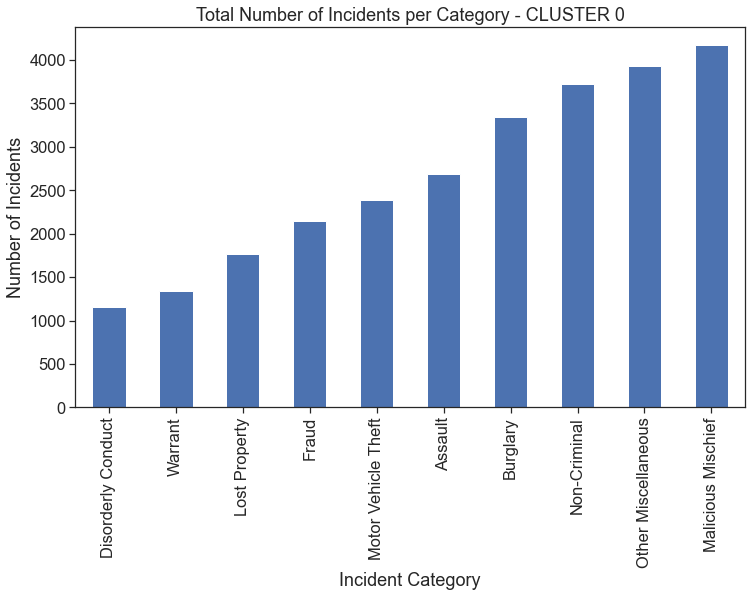

In [197]:
incidents_SF_merged_noLarceny_tot_clusters_only_grouped[0:1].sort_values(by=0,ascending=True,axis=1).T.tail(10).plot(kind='bar', figsize=(12, 7))

plt.xlabel('Incident Category') # add to x-label to the plot
plt.ylabel('Number of Incidents') # add y-label to the plot
plt.title('Total Number of Incidents per Category - CLUSTER 0') # add title to the plot
plt.legend('',frameon=False)

plt.show()

### Cluster 1 - Miscellaneous, Assault, and Malicious Mischief

### OR ----- Malicious Mischief + Burglary + Motor Vehicle Theft + Robbery = Property at risk!!!

### Property at risk - Miscellaneous - Assault

In [198]:
incidents_SF_merged_noLarceny_tot_clusters_only_grouped[1:2].sort_values(by=1,ascending=False,axis=1).T.head(10)

1
Other Miscellaneous                       4029.0
Assault                                   3943.0
Malicious Mischief                        3616.0
Motor Vehicle Theft                       3481.0
Non-Criminal                              3067.0
Recovered Vehicle                         2341.0
Burglary                                  2310.0
Offences Against The Family And Children  1773.0
Robbery                                   1748.0
Missing Person                            1450.0

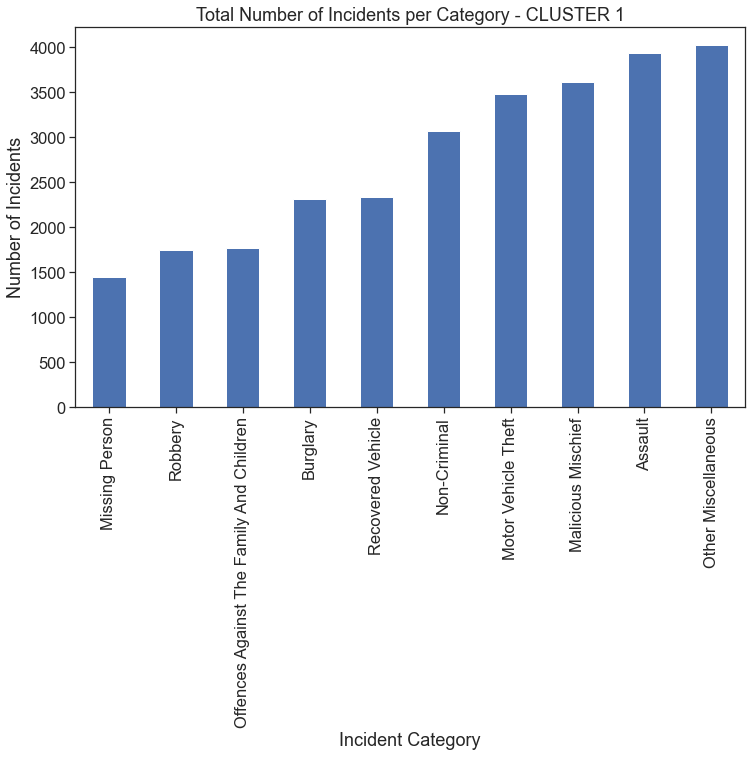

In [199]:
incidents_SF_merged_noLarceny_tot_clusters_only_grouped[1:2].sort_values(by=1,ascending=True,axis=1).T.tail(10).plot(kind='bar', figsize=(12, 7))

plt.xlabel('Incident Category') # add to x-label to the plot
plt.ylabel('Number of Incidents') # add y-label to the plot
plt.title('Total Number of Incidents per Category - CLUSTER 1') # add title to the plot
plt.legend('',frameon=False)

plt.show()

### Cluster 2 - Burglary, Malicious Mischief & Motor Vehicle Theft - Properties at risk!!!

### Property at risk - Burglary

In [200]:
incidents_SF_merged_noLarceny_tot_clusters_only_grouped[2:3].sort_values(by=2,ascending=False,axis=1).T.head(10)

2
Burglary             2184.0
Malicious Mischief   1899.0
Motor Vehicle Theft  1586.0
Non-Criminal         1526.0
Other Miscellaneous  1470.0
Assault               949.0
Fraud                 927.0
Recovered Vehicle     761.0
Suspicious Occ        606.0
Lost Property         580.0

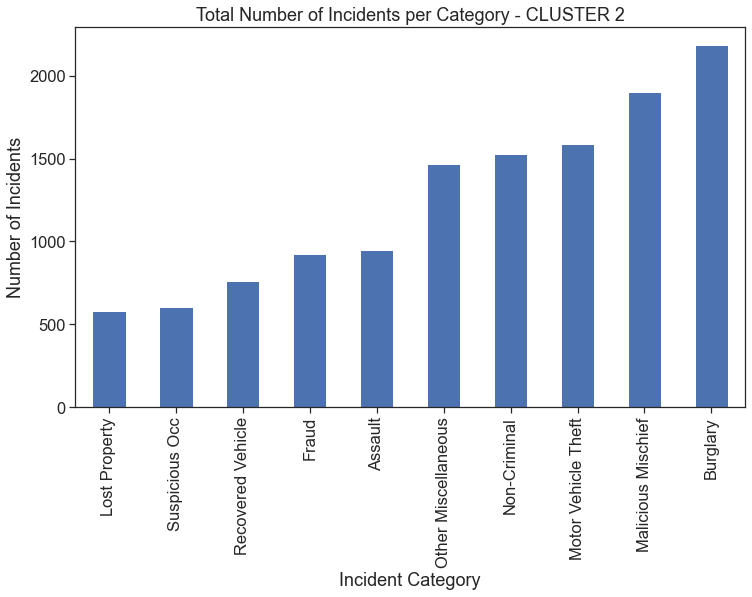

In [201]:
incidents_SF_merged_noLarceny_tot_clusters_only_grouped[2:3].sort_values(by=2,ascending=True,axis=1).T.tail(10).plot(kind='bar', figsize=(12, 7))

plt.xlabel('Incident Category') # add to x-label to the plot
plt.ylabel('Number of Incidents') # add y-label to the plot
plt.title('Total Number of Incidents per Category - CLUSTER 2') # add title to the plot
plt.legend('',frameon=False)

plt.show()

### Cluster 3 - Non-Criminal, Malicious Mischief, Missing Person

### OR ----- Malicious Mischief + Burglary + Motor Vehicle Theft + Lost Property = Property at risk!!!

### Property at risk - Non-Criminal - Missing Person

In [202]:
incidents_SF_merged_noLarceny_tot_clusters_only_grouped[3:4].sort_values(by=3,ascending=False,axis=1).T.head(10)

3
Non-Criminal         2207.0
Malicious Mischief   1799.0
Missing Person       1634.0
Other Miscellaneous  1597.0
Burglary             1478.0
Motor Vehicle Theft  1403.0
Fraud                1266.0
Assault              1250.0
Lost Property         818.0
Suspicious Occ        709.0

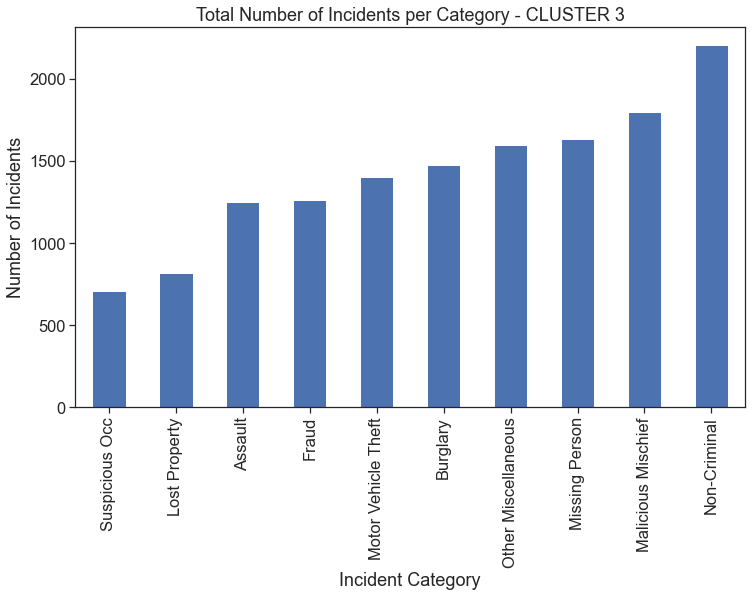

In [203]:
incidents_SF_merged_noLarceny_tot_clusters_only_grouped[3:4].sort_values(by=3,ascending=True,axis=1).T.tail(10).plot(kind='bar', figsize=(12, 7))

plt.xlabel('Incident Category') # add to x-label to the plot
plt.ylabel('Number of Incidents') # add y-label to the plot
plt.title('Total Number of Incidents per Category - CLUSTER 3') # add title to the plot
plt.legend('',frameon=False)

plt.show()

### Cluster 4 - Miscellaneous, Assault, Non-Criminal

### OR ----- Malicious Mischief + Burglary + Motor Vehicle Theft + Lost Property + Robbery = Property at risk!!!

### Property at risk - Miscellaneous

In [204]:
incidents_SF_merged_noLarceny_tot_clusters_only_grouped[4:5].sort_values(by=4,ascending=False,axis=1).T.head(10)

4
Other Miscellaneous  12342.0
Assault               9259.0
Non-Criminal          8239.0
Malicious Mischief    8142.0
Burglary              6808.0
Warrant               6001.0
Lost Property         4853.0
Motor Vehicle Theft   4182.0
Fraud                 4023.0
Robbery               3688.0

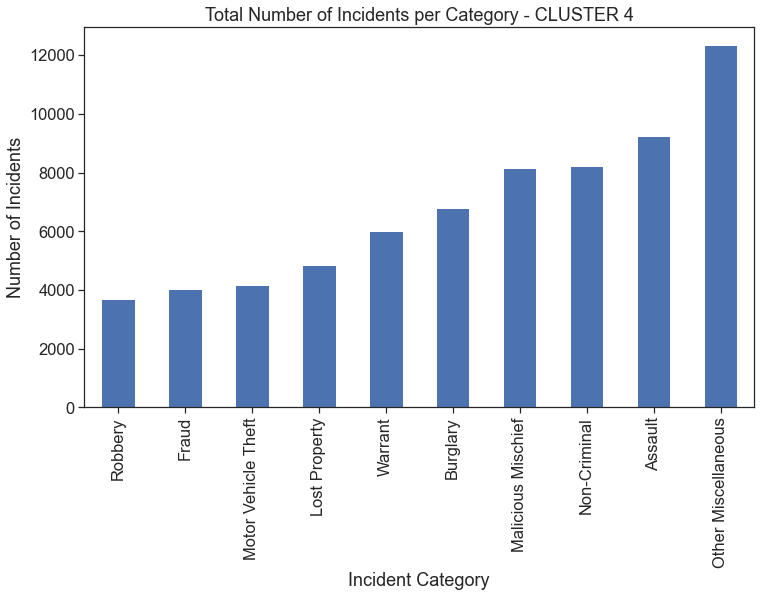

In [205]:
incidents_SF_merged_noLarceny_tot_clusters_only_grouped[4:5].sort_values(by=4,ascending=True,axis=1).T.tail(10).plot(kind='bar', figsize=(12, 7))

plt.xlabel('Incident Category') # add to x-label to the plot
plt.ylabel('Number of Incidents') # add y-label to the plot
plt.title('Total Number of Incidents per Category - CLUSTER 4') # add title to the plot
plt.legend('',frameon=False)

plt.show()

### Cluster 5 - Drug Offense

### OR ----- Drug Offense, (Malicious Mischief + Burglary + Lost Property + Robbery = Property at risk!!!

### Property at risk - Drug Offense

In [206]:
incidents_SF_merged_noLarceny_tot_clusters_only_grouped[5:6].sort_values(by=5,ascending=False,axis=1).T.head(10)

5
Drug Offense                              4071.0
Other Miscellaneous                       3396.0
Assault                                   3097.0
Non-Criminal                              2953.0
Warrant                                   2702.0
Malicious Mischief                        1431.0
Lost Property                             1119.0
Robbery                                   1112.0
Burglary                                   907.0
Offences Against The Family And Children   832.0

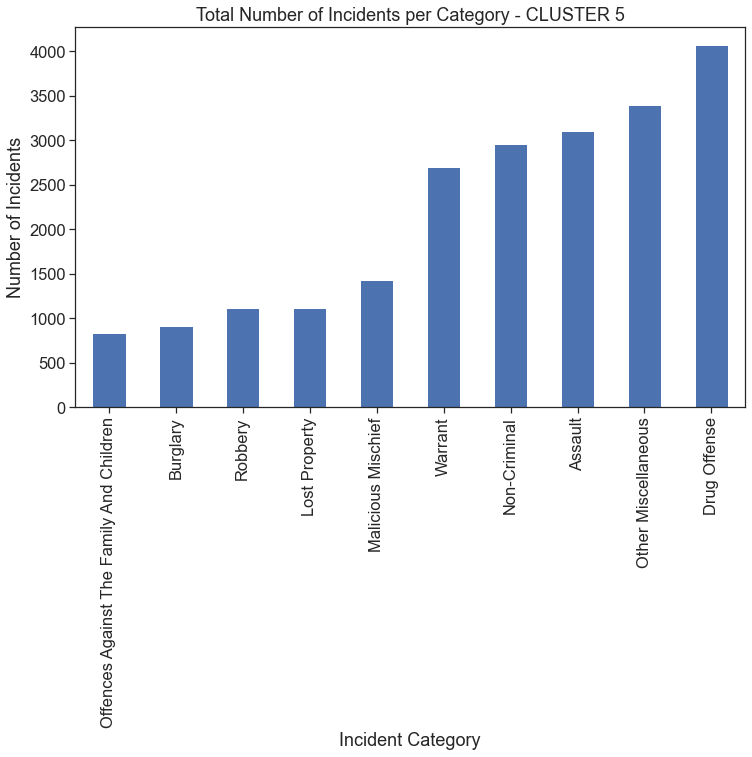

In [207]:
incidents_SF_merged_noLarceny_tot_clusters_only_grouped[5:6].sort_values(by=5,ascending=True,axis=1).T.tail(10).plot(kind='bar', figsize=(12, 7))

plt.xlabel('Incident Category') # add to x-label to the plot
plt.ylabel('Number of Incidents') # add y-label to the plot
plt.title('Total Number of Incidents per Category - CLUSTER 5') # add title to the plot
plt.legend('',frameon=False)

plt.show()

### Cluster 6 - Civil Sidewalks & Non-Criminal

### OR ----- Malicious Mischief + Burglary + Motor Vehicle Theft = Property at risk!!!

### Property at risk - Civil Sidewalks - Non-Criminal

In [208]:
incidents_SF_merged_noLarceny_tot_clusters_only_grouped[6:7].sort_values(by=6,ascending=False,axis=1).T.head(10)

6
Civil Sidewalks      506.0
Non-Criminal         410.0
Other Miscellaneous  344.0
Malicious Mischief   334.0
Burglary             310.0
Motor Vehicle Theft  294.0
Assault              274.0
Warrant              243.0
Missing Person       212.0
Drug Offense         196.0

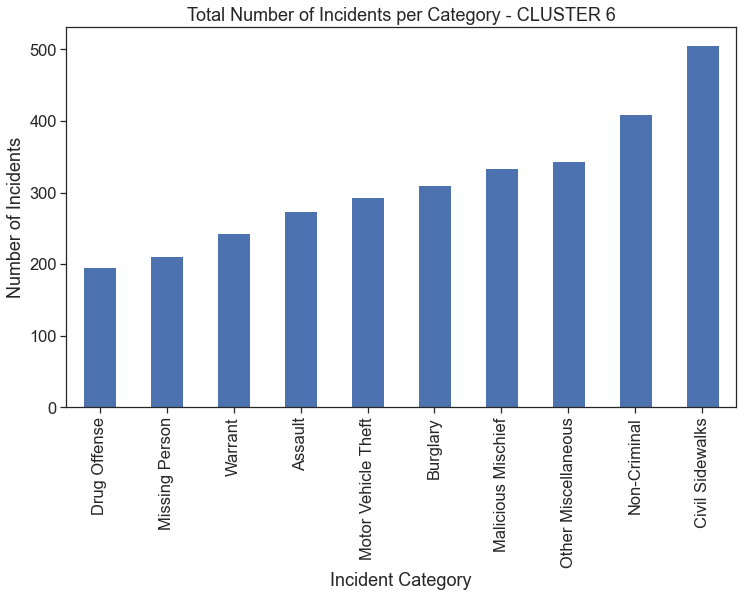

In [209]:
incidents_SF_merged_noLarceny_tot_clusters_only_grouped[6:7].sort_values(by=6,ascending=True,axis=1).T.tail(10).plot(kind='bar', figsize=(12, 7))

plt.xlabel('Incident Category') # add to x-label to the plot
plt.ylabel('Number of Incidents') # add y-label to the plot
plt.title('Total Number of Incidents per Category - CLUSTER 6') # add title to the plot
plt.legend('',frameon=False)

plt.show()

---------------

### Discussion

The analysis of the most common incidents carried out above shows that among the most represented categories we find "Other Miscellaneous", "Non-Criminal" and "Malicious Mischief". However, we noticed that the sum of the elements in the categories "Malicious Mischief", "Burglary", "Robbery", "Motor Vehicle Theft" and "Lost Property" which are related to peoples properties is well above all the other categories in each cluster. In other words, the category that one would call "Property at Risk" is the most represented everywhere in San Francisco (together with "Larceny Theft" that we removed from our analysis). Keeping in mind that, we label the 7 clusters as follows:

- Cluster 0 - Malicious Mischief - Miscellaneous - Non-Criminal
- Cluster 1 - Miscellaneous - Assault
- Cluster 2 - Burglary
- Cluster 3 - Non-Criminal - Missing Person
- Cluster 4 - Miscellaneous - Assault
- Cluster 5 - Drug Offense - Miscellaneous
- Cluster 6 - Civil Sidewalks - Non-Criminal


Here, beside __Cluster 0__, __Cluster 1__, and __Cluster 4__ which are rather miscellaneous, the other clusters have a more defined identity. In __Cluster 2__, we see that "Burglary" type of incidents are common while __Cluster 3__ is mostly "Non-Criminal" but crimes in the "Missing Person" category are frequent. Finally, __Cluster 5__ and __Cluster 6__ deserve a special attention. They are the smallest with just one neighborhood but they stand out from the other clusters for their peculiar type of crimes belonging to the categories "Drug Offense" and "Civil Sidewalks", respectively, discussed previuosly.

----------

<a id='item6'></a>

## 6. Conclusions

In this Notebook, we analyzed the neighborhoods of San Francisco in terms of the most common incidents/crimes reported by the Police Department. We used the data available at the [link](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783) to group the neighborhoods in clusters. To this end, we applied the _k-means_ clustering method and we grouped the neighborhoods in 7 clusters depending on the incidents/crimes categories. We labelled them by considering the most common incidents as described at the end of the previous section. In our analysis, we removed the "Larceny Theft" category because it is the dominant one in every neighborhood. In addition, we took into account in a qualitative way the fact that the categories "Malicious Mischief", "Burglary", "Robbery", "Motor Vehicle Theft" and "Lost Property" give a large contribution to the total number of crimes in each neighborhood.

--------------
--------------